In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def coth(a):
    if a>0: return (1+tf.math.exp(-2*a))/(1-tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)+1)/(tf.math.exp(2*a)-1)
    if a==0: return 0

def tanh(a):
    if a>0: return (1-tf.math.exp(-2*a))/(1+tf.math.exp(-2*a))
    if a<0: return (tf.math.exp(2*a)-1)/(tf.math.exp(2*a)+1)
    if a==0: return 0

In [49]:
data=1000
batch=100
set=10
layer=10
n_ini=1.0
n_fin=0.1
dn=-0.1
m2=-1
lam=1
c_reg1=0.003
c_reg2=0.0001

m^2= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8803363876503172>
lam= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.1196548577944498>
alpha= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-0.4979823811773798>
beta= <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.24302798585315233>
<tf.Variable 'Variable:0' shape=(10,) dtype=float64, numpy=
array([1.06794358, 1.12942495, 3.7246767 , 1.69126558, 0.12223803,
       3.06123964, 3.02650048, 1.89048634, 2.80378855, 2.57081626])>


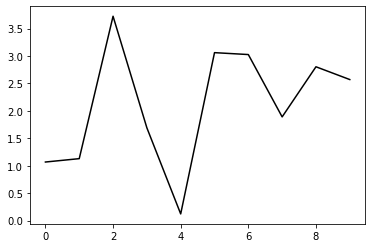

In [65]:
h=tf.zeros(layer)
h_in=[]
for i in range (layer):
    h_inn=np.float64(np.random.normal(2, 1))
    h_in.append(h_inn)
h=tf.Variable(h_in)
m2=tf.Variable(np.float64(np.random.normal(2, 1)))
lam=tf.Variable(np.float64(np.random.normal(1, 1)))
alpha=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
beta=tf.Variable(np.float64(np.random.uniform(-0.5, 0.5)))
#m2=tf.constant(np.float64(5.6))
#lam=tf.constant(np.float64(0.61))
#alpha=tf.constant(np.float64(1.444635))
#beta=tf.constant(np.float64(0.00615))
print("m^2=", m2)
print("lam=", lam)
print("alpha=", alpha)
print("beta=", beta)
print(h)
plt.plot(h.numpy(), 'k-')
plt.show()

In [5]:
def F_func(m, la, a,b):
    return 2*b/n_fin-m*a-la*(a**3)

def t_func(a):
    return 0.5*(tf.math.tanh(100*(a-0.1))-tf.math.tanh(100*(a+0.1))+2)

In [6]:
x=[i*0.1 for i in range (30)]
y=[0.0, 0.018, 0.035, 0.053, 0.0715, 0.0895, 0.107, 0.125, 0.146, 0.1665, 0.1875, 0.2085, 0.229, 0.25, 0.265, 0.281, 0.296, 0.3115, 0.3275, 0.343, 0.3565, 0.385, 0.4375, 0.5, 0.6, 0.675, 0.735, 0.815, 0.865, 0.885]
fp1 = np.polyfit(x, y, 15)
print(fp1)

[ 2.60581612e-01 -5.58472955e+00  5.38266808e+01 -3.08275478e+02
  1.16790041e+03 -3.08347723e+03  5.82285230e+03 -7.94502014e+03
  7.81868298e+03 -5.47798636e+03  2.66286328e+03 -8.59692413e+02
  1.71291955e+02 -1.84108983e+01  9.55260239e-01 -6.54557458e-05]


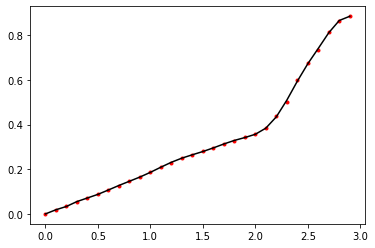

In [7]:
def f(x):
    y=0
    for i in range (16):
        y=y+fp1[i]*x**(15-i)
    return y
yy=[f(i*0.1) for i in range (30)]
plt.plot(x, y, 'r.')
plt.plot(x, yy, 'k-')
plt.show()

In [11]:
def NN_func_p(f):
    Positive=[]
    append=Positive.append
    while len(Positive)<batch:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))<=noise: append([H, M])
        else: continue
    return Positive
def NN_func_n(f):
    Negative=[]
    append=Negative.append
    while len(Negative)<batch:
        H=np.random.uniform(0.0, 3.0)
        M=np.random.uniform(0.0, 1.0)
        noise=np.abs(np.random.normal(0, 0.025))
        if np.abs(M-f(H))>noise: append([H, M])
        else: continue
    return Negative

In [13]:
Positive=[]
Negative=[]
for i in range (set):
    Positive.insert(i, NN_func_p(f))
    Negative.insert(i, NN_func_n(f))

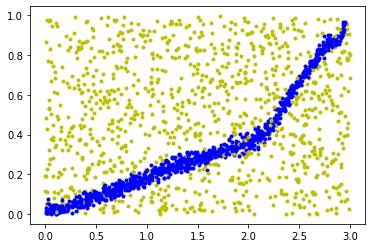

In [16]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive[i]])
    y_data1.insert(i, [v[1] for v in Positive[i]])
    x_data2.insert(i, [v[0] for v in Negative[i]])
    y_data2.insert(i, [v[1] for v in Negative[i]])
    plt.plot(x_data2[i], y_data2[i], 'y.')
    plt.plot(x_data1[i], y_data1[i], 'b.')
plt.show()

In [17]:
def Dfunc(hh, m):
    D=tf.math.sqrt(tf.math.abs(1+4*m/(hh[0]**2)))
    return D

In [18]:
def LP2(hh, m, la, alpha, beta, HH, MM):
    D=Dfunc(hh, m)
    phi=alpha*HH+beta*MM
    pi=1.5*(D-1)*alpha*HH+1.5*(-D-1)*beta*MM
    for j in range (layer-1):
        phi1=phi+dn*pi
        pi1 =phi*m*dn+(1-dn*hh[j])*pi+dn*la*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi
def NN_func_01(hh, m, la, alpha, beta, list_hr):
    PP=[]
    NN=[]
    H=np.array(list_hr)[:, 0]
    M=np.array(list_hr)[:, 1]
    F=np.array(tf.math.abs(LP2(hh, m, la, alpha, beta, H, M)[1]))
    for i in range (len(H[F<0.1])):
        PP.append([H[F<0.1][i], M[F<0.1][i]])
    for i in range (len(H[F>=0.1])):
        NN.append([H[F>=0.1][i], M[F>=0.1][i]])
    return PP, NN

In [66]:
Positive0=[]
Positive1=[]
Negative0=[]
Negative1=[]
for i in range (set):
    Positive0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[0])
    Positive1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Positive[i])[1])
    Negative0.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[0])
    Negative1.insert(i, NN_func_01(h, m2, lam, alpha, beta, Negative[i])[1])

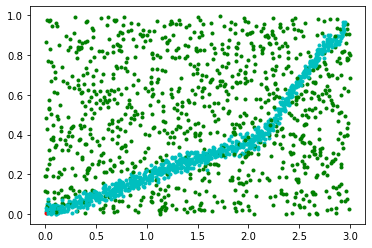

In [67]:
x_data1=[]
y_data1=[]
x_data2=[]
y_data2=[]
x_data3=[]
y_data3=[]
x_data4=[]
y_data4=[]
for i in range (set):
    x_data1.insert(i, [v[0] for v in Positive0[i]])
    y_data1.insert(i, [v[1] for v in Positive0[i]])
    x_data2.insert(i, [v[0] for v in Positive1[i]])
    y_data2.insert(i, [v[1] for v in Positive1[i]])
    x_data3.insert(i, [v[0] for v in Negative0[i]])
    y_data3.insert(i, [v[1] for v in Negative0[i]])
    x_data4.insert(i, [v[0] for v in Negative1[i]])
    y_data4.insert(i, [v[1] for v in Negative1[i]])
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()

# Error function

$E=\sum_{data} \left\vert y(\bar{x}^{(1)}) - \bar{y} \right\vert+E_{reg}(W)$
, $E_{reg}=c_{reg}^{(1)}\sum_{n=1}^{N-1}(\eta^{(n)})^{4}(h(\eta^{(n+1)})-h(\eta^{(n)}))^{2}+c_{reg}^{(2)}(h(\eta^{(N)})-1/\eta^{(N)})^{2}$

In [68]:
def Error_func(hh, m, la, alpha, beta, list1, list2):
    H0=np.array([v[0] for v in list1])
    M0=np.array([v[1] for v in list1])
    H1=np.array([v[0] for v in list2])
    M1=np.array([v[1] for v in list2])
    H_0, M_0=LP2(hh, m, la, alpha, beta, H0, M0)
    H_1, M_1=LP2(hh, m, la, alpha, beta, H1, M1)
    PPlist=t_func(M_0)
    NNlist=t_func(M_1)
    sum_p=sum(PPlist)/batch
    sum_n=(batch-sum(NNlist))/batch

    inside=0
    for k in range (layer-1):
        second=((n_ini+k*dn)**4)*((hh[k+1]-hh[k])**2)
        inside=inside+second
    E_reg1=c_reg1*inside
    E_reg2=c_reg2*((hh[layer-1]-1/n_fin)**2)
    return sum_p+sum_n+E_reg1+E_reg2

In [69]:
for i in range (set):
    print(Error_func(h, m2, lam, alpha, beta, Positive[i], Negative[i]))

tf.Tensor(1.0291200511555325, shape=(), dtype=float64)
tf.Tensor(1.0291200511555325, shape=(), dtype=float64)
tf.Tensor(1.0291177702224275, shape=(), dtype=float64)
tf.Tensor(1.0291200511555263, shape=(), dtype=float64)
tf.Tensor(1.0291200511555325, shape=(), dtype=float64)
tf.Tensor(1.0198777979604277, shape=(), dtype=float64)
tf.Tensor(1.0291200511555325, shape=(), dtype=float64)
tf.Tensor(1.0291200511555314, shape=(), dtype=float64)
tf.Tensor(1.0291200511555325, shape=(), dtype=float64)
tf.Tensor(1.0291200511555325, shape=(), dtype=float64)


# Optimize

0 1.0255766143706322
1.8803363876503172 1.1196548577944498 -0.4979823811773798 0.24302798585315233
[1.1677832  1.22941893 3.6246806  1.79124393 0.222225   2.96126543
 2.92686577 1.99021648 2.70503717 2.67077644]


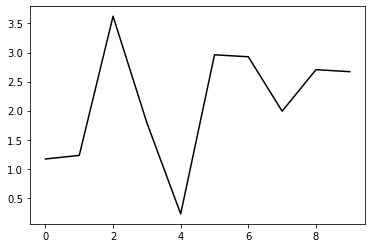

1100 1.0530673843437774
1.4625266205164331 1.2151557594908242 -0.07859512825152272 -0.17397286125123723
[2.46427049 1.36132377 2.50671581 1.39190552 0.31489981 1.64922101
 1.56550677 1.01863779 1.37625354 3.72464808]


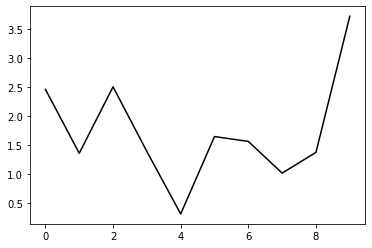

2200 0.9874589678446433
1.442094773568195 1.2201285915287126 -0.06620300451018889 -0.17158912858841927
[2.52158932 1.50371037 2.16814155 1.28839216 0.30117589 1.37244686
 1.33692751 0.77860768 1.09098814 4.7123275 ]


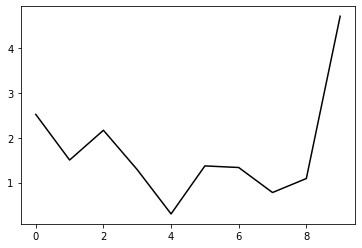

3300 0.8697005117463898
1.3893661239501605 1.2355503339730256 -0.14660365275072965 -0.15494286863319423
[ 2.67055841  1.44258522  1.53470538  0.74814169 -0.18737256  0.55798583
  0.4972994  -0.07104863  0.25699636  5.64815836]


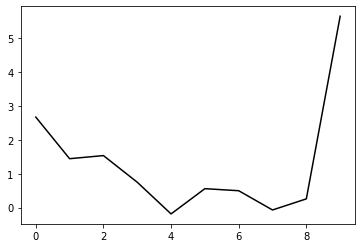

4400 0.9162687675297735
1.32234013848347 1.2523746432599854 -0.2024449534987907 -0.13165576386468228
[ 2.73270909  1.51850378  1.04553355  0.2454718  -0.63212685 -0.1708528
 -0.22258832 -0.75552979 -0.39332845  6.53142644]


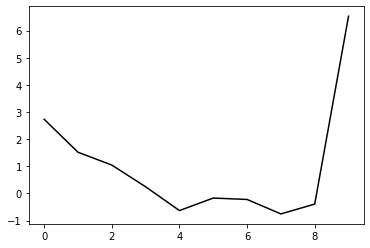

5500 0.7498167055166649
1.1592312287747952 1.2638563402850378 -0.1798729076511695 -0.08168914906297492
[ 2.44483047  1.64502445  0.74022525 -0.2658119  -1.25272278 -1.09611155
 -1.22656221 -1.79125594 -1.44691911  7.35169432]


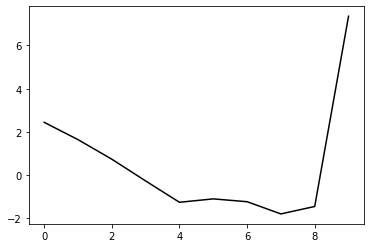

6600 0.6256858811427282
1.0617796281425034 1.228937850420863 -0.058679750817713 -0.07105384762489357
[ 1.79468637  1.99777407  1.27628762  0.15572133 -0.99299496 -1.17670087
 -1.4268451  -2.0753116  -1.80342942  8.08636403]


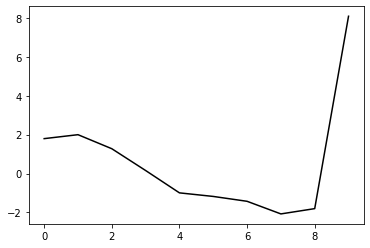

7700 0.9974311511197848
1.1821004260222512 1.1682193841426272 -0.2980961728723011 0.03356748304420961
[ 0.92789091  2.02238414  1.8076936   0.74696494 -0.44982876 -0.80990255
 -1.14679343 -1.86538704 -1.66864108  8.71294557]


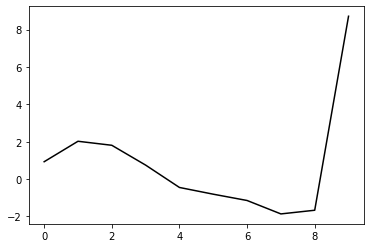

8800 0.8751439066452371
1.0808517218491123 1.1549077663073681 -0.13507947903834408 0.08427318210196137
[ 1.6283609   1.20755062  1.04724891  0.21553839 -0.90177286 -1.34377288
 -1.64873488 -2.30075191 -2.03782488  9.16363608]


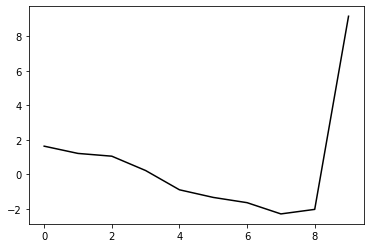

9900 0.7253491350278558
1.0080169531665069 1.1477005183643076 -0.05596624546936413 0.06893895473809095
[ 1.95060261  0.90001589  0.58272179 -0.1672214  -1.23285639 -1.7299166
 -2.04243303 -2.67836949 -2.39941948  9.38652778]


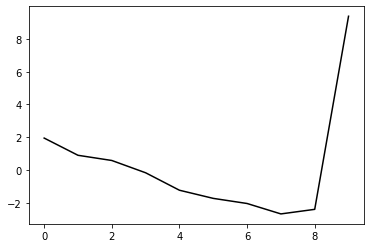

11000 0.5730799797198796
0.9834884597462853 1.1587218467714981 -0.07319209264907106 0.084689597670867
[ 2.0895753   0.98692202  0.49977377 -0.2216632  -1.24871716 -1.76747553
 -2.07702525 -2.69367124 -2.39552815  9.43019126]


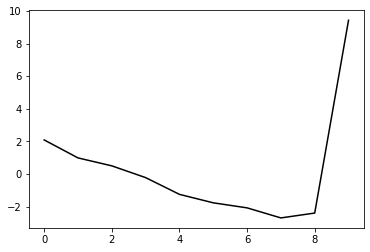

12100 0.7022986339228221
0.9641492252631976 1.1691281879797715 -0.12073959792055851 0.09095634958170734
[ 2.38244424  0.90669479  0.29352615 -0.42451563 -1.41967841 -1.9576698
 -2.26712644 -2.86885468 -2.55605792  9.4322737 ]


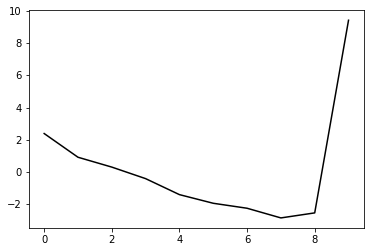

13200 0.61864240032857
1.0112004068331353 1.2166628538195063 -0.15758097811738378 0.13812987613194477
[ 2.42866142  1.17624155  0.45618775 -0.26626997 -1.23027596 -1.77663889
 -2.07903462 -2.65887492 -2.32242227  9.43878792]


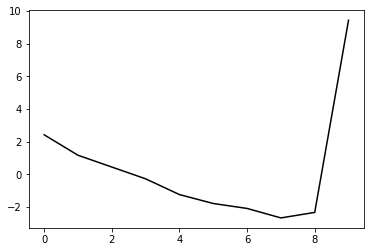

14300 0.3841042393695434
1.0600339456699577 1.37287600658656 -0.3300693324950362 0.16656846466255598
[ 2.81070511  1.22647923  0.43761302 -0.26262587 -1.16506846 -1.68016014
 -1.93290421 -2.43992533 -2.01833224  9.44580275]


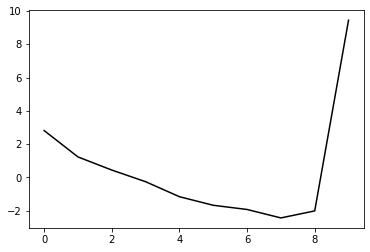

15400 0.45773908615912706
1.0173855266369214 1.3462068478460514 -0.33089693946095977 0.18665907149929417
[ 2.92110725  1.18886896  0.3045489  -0.45902207 -1.40656334 -2.00278423
 -2.34977351 -2.95833593 -2.61346104  9.4365808 ]


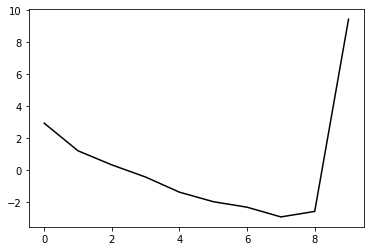

16500 0.3610842168342894
0.9954602499361804 1.3747275782470725 -0.3565910395491781 0.2135715818626043
[ 2.90392514  1.3318321   0.4124823  -0.34472032 -1.262973   -1.84677569
 -2.17653746 -2.75869452 -2.40012097  9.42108238]


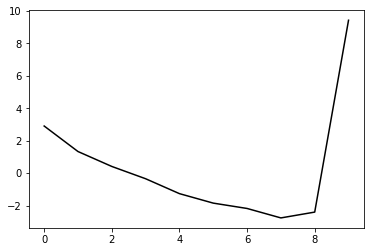

17600 0.3784242893837232
1.0721819867806233 1.4092779196272083 -0.37519896131304714 0.23326905112068397
[ 2.94011872  1.49793909  0.55729116 -0.18592979 -1.05420558 -1.59958226
 -1.87240437 -2.36476738 -1.88919012  9.3534378 ]


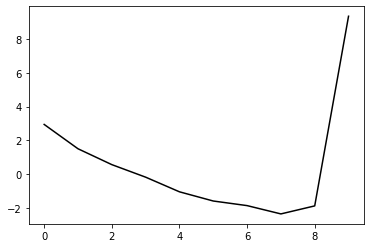

18700 0.4894923959707347
1.1216173773719174 1.4314976323810333 -0.39571708465716837 0.235573920762223
[ 3.07707223  1.55154871  0.56417417 -0.18946785 -1.0264827  -1.55551841
 -1.79753831 -2.23084411 -1.67696778  9.44833537]


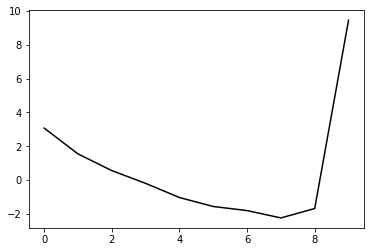

19800 0.4601840340562597
1.1104083671445624 1.427181682940942 -0.40131982245310394 0.2326390876393597
[ 3.14619693  1.59137102  0.54878219 -0.2314758  -1.06115827 -1.60112592
 -1.8520394  -2.28335164 -1.74051031  9.46656321]


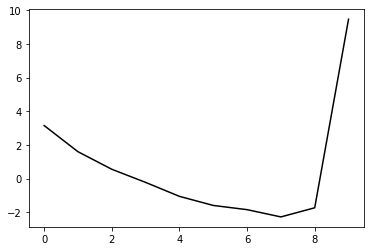

20900 0.36902546179515994
1.0731224876842633 1.4192825796609712 -0.4043294173946764 0.22586642042857305
[ 3.08503706  1.69812288  0.61802975 -0.20548137 -1.04860326 -1.62898321
 -1.9328451  -2.42343569 -1.97249991  9.5214796 ]


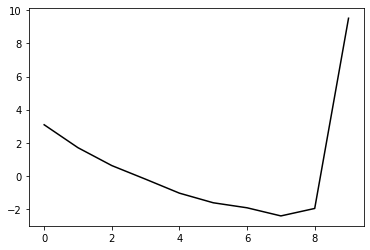

22000 0.3677339895372809
1.1067641672984003 1.4321857867243868 -0.42068601384247517 0.222937784437245
[ 3.27217917  1.64683646  0.55831427 -0.28072803 -1.10533007 -1.67400228
 -1.95551316 -2.3953072  -1.87377143  9.43883044]


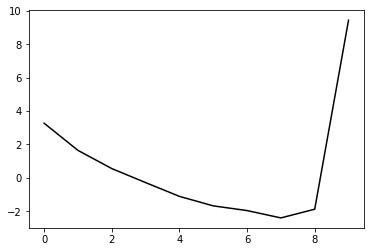

23100 0.44282303492129615
1.0360880890058388 1.410776963721997 -0.41172677441724537 0.22858631382273964
[ 3.21426208  1.75941477  0.63703453 -0.24578863 -1.09620662 -1.70867502
 -2.04858053 -2.56236815 -2.17990475  9.46930104]


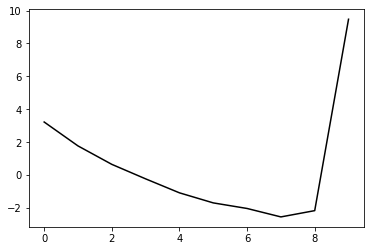

24200 0.3094877406295045
1.103163804834357 1.4010604341396944 -0.410433454877552 0.2416671095936241
[ 3.28478196  1.80537251  0.67543478 -0.22162674 -1.06468661 -1.67006083
 -1.99333979 -2.46510857 -2.01515888  9.39927958]


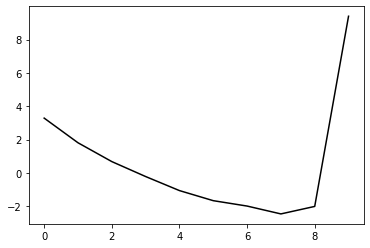

25300 0.33538695941440083
0.9394997752040593 1.3541112939189677 -0.3858189294179811 0.2617689179314749
[ 3.1618504   1.92431764  0.74707469 -0.19965725 -1.0874219  -1.75539353
 -2.16525654 -2.76287715 -2.53956648  9.47965039]


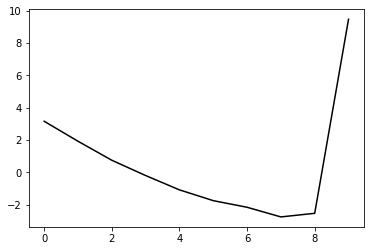

26400 0.36716759939376065
0.9093165252629585 1.3601367015762886 -0.41332061216107124 0.2423572866952167
[ 3.24807502  1.85001039  0.657619   -0.31394415 -1.21703376 -1.9054508
 -2.33897765 -2.95953971 -2.77082014  9.40206564]


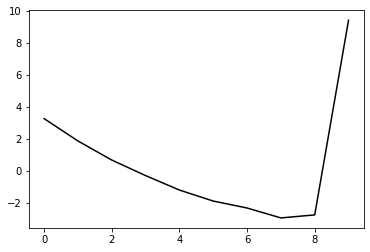

27500 0.33800349847294897
0.9905932172981123 1.39825471027712 -0.43809881081002916 0.24833616130893849
[ 3.28309717  1.94320096  0.78018963 -0.17138371 -1.03725261 -1.68512624
 -2.06510027 -2.59750671 -2.27708064  9.43963006]


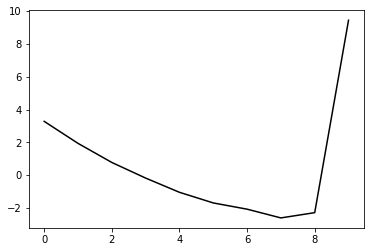

28600 0.6889609648978875
0.8768715219120742 1.428040847171103 -0.47353041066247487 0.20709301060919386
[ 3.31659327  1.88945177  0.72667734 -0.24898297 -1.13367939 -1.81284267
 -2.2382734  -2.828845   -2.60935301  9.49083773]


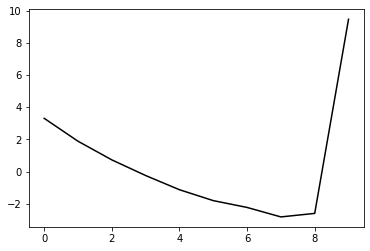

29700 0.5065131962619114
0.8981001868155136 1.379491138831117 -0.4337509624497216 0.25450377747289427
[ 3.19720949  2.09249044  0.93841591 -0.05635006 -0.94940634 -1.63760131
 -2.0702573  -2.6558942  -2.44142851  9.424458  ]


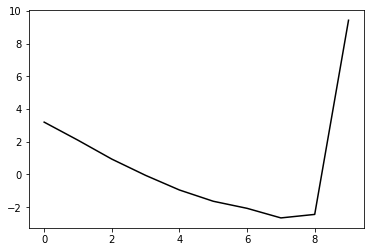

30800 0.45966828078373617
0.7466259385951266 1.4260025036852402 -0.4697553477865974 0.23870060121108325
[ 3.03397435  2.26380676  1.16235278  0.19890698 -0.6641521  -1.33402035
 -1.76002614 -2.3435602  -2.15791164  9.32444506]


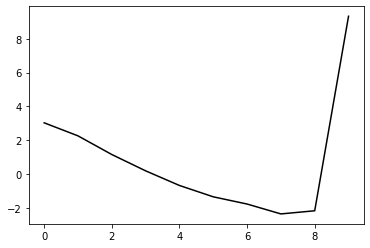

31900 0.40070997783773504
0.7014338195047737 1.3452766066286372 -0.4284698326262206 0.24957892324527622
[ 3.06961967  2.19769713  1.07889664  0.05460479 -0.86878067 -1.60474022
 -2.10633594 -2.77660621 -2.7199984   9.41314026]


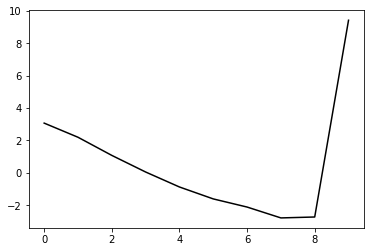

33000 0.30093388509539953
0.7124614339349806 1.3631114121388512 -0.4484679419497435 0.24214953052853672
[ 3.17284711  2.14442835  1.04320463  0.01490916 -0.90997777 -1.64697883
 -2.1473888  -2.80351684 -2.72729052  9.43101907]


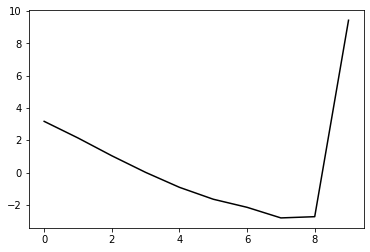

34100 0.5150588781168842
0.7700229957912714 1.3158538408932787 -0.4141391322079878 0.27934363883562635
[ 3.12796589  2.25033296  1.14168983  0.09280882 -0.85197276 -1.60785233
 -2.12433561 -2.78459287 -2.71987292  9.40710121]


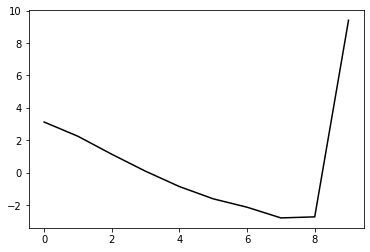

35200 0.38875009287181805
0.7452330321299352 1.2988585562424753 -0.41618365845102356 0.2755143359739825
[ 3.23457185  2.1455368   1.01369855 -0.05951833 -1.03154192 -1.81779532
 -2.36896465 -3.0673292  -3.07583762  9.40989578]


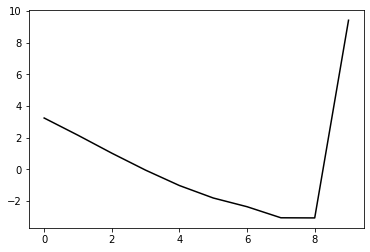

36300 0.32880884642203195
0.7694655465008563 1.320713589218971 -0.4435909898729067 0.2596860343881509
[ 3.28495108  2.15508969  1.03235953 -0.03199022 -0.99458317 -1.77018604
 -2.30624753 -2.97087736 -2.92483186  9.33593964]


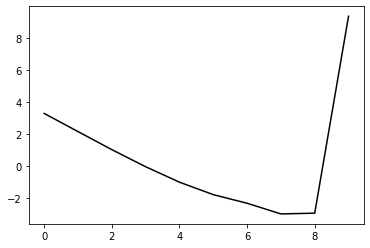

37400 0.39465282137965596
0.7733938341912062 1.3095353119742925 -0.4381038140213682 0.266497317805334
[ 3.33483573  2.1611225   1.03869045 -0.03438387 -1.00584738 -1.79000901
 -2.33275034 -2.99250031 -2.94246847  9.38677012]


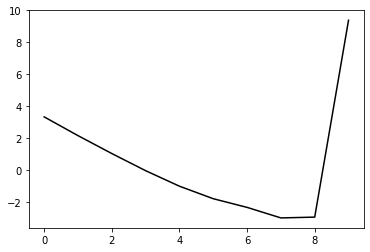

38500 0.38288427961403304
0.74592120905202 1.331996481206525 -0.46367892489682155 0.25410299356656674
[ 3.40728392  2.13894849  1.03017542 -0.0312794  -0.99361407 -1.77010437
 -2.30439139 -2.9436488  -2.86369626  9.41348789]


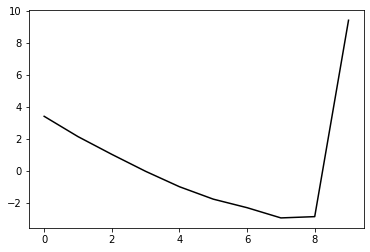

39600 0.35139878763916854
0.6169691021702038 1.3203148896097738 -0.46023067670018564 0.2594705626465723
[ 3.20024134  2.32312798  1.22225449  0.15823906 -0.8138157  -1.60765956
 -2.16901399 -2.84465653 -2.84718761  9.53598757]


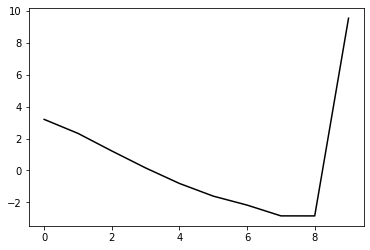

40700 0.4017850131000267
0.47870839454271047 1.3182004916414205 -0.4778371127227711 0.24409220509347862
[ 3.33581014e+00  2.19510016e+00  1.08125096e+00 -4.95569067e-03
 -1.00512939e+00 -1.83386051e+00 -2.44058190e+00 -3.17537167e+00
 -3.29013603e+00  9.40662583e+00]


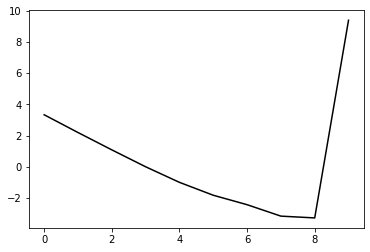

41800 0.44628178075388775
0.475458784058554 1.3035831758990377 -0.471127057529607 0.26407351889109304
[ 3.31596469  2.29666114  1.20917411  0.1350421  -0.85563995 -1.67590883
 -2.27345918 -2.99036552 -3.08745929  9.37428364]


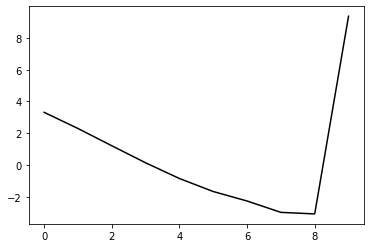

42900 0.5593682279543056
0.4588054043399695 1.2256742769815947 -0.41328659317682304 0.3047952647440391
[ 3.12293334  2.40180919  1.29792584  0.18607398 -0.85351713 -1.73296981
 -2.40438177 -3.21986393 -3.50054417  9.46323351]


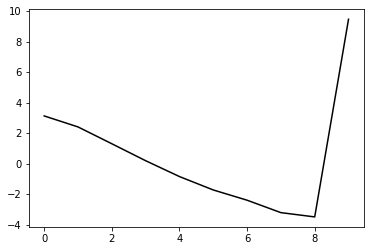

44000 0.31859875192522413
0.6103838006949274 1.2655945860018323 -0.46044590480046954 0.27484263914997376
[ 3.36071849  2.25622996  1.13650487  0.01510311 -1.03572423 -1.92451124
 -2.59957361 -3.40180737 -3.63928934  9.38282705]


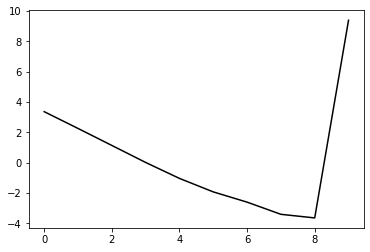

45100 0.392161667991896
0.6223447611263807 1.2537179609012117 -0.4537180089570509 0.2821043504565608
[ 3.18661793  2.40451824  1.29568997  0.18206746 -0.86756093 -1.75951796
 -2.43976987 -3.2417299  -3.48945543  9.37964313]


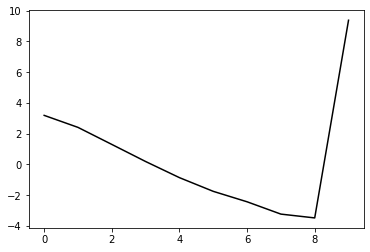

46200 0.3372986327352347
0.5787057551592678 1.2513966960056309 -0.45759294441172377 0.282835777903146
[ 3.3060383   2.33996377  1.24804764  0.14117227 -0.90663873 -1.79883642
 -2.4789215  -3.2715347  -3.52268971  9.47999661]


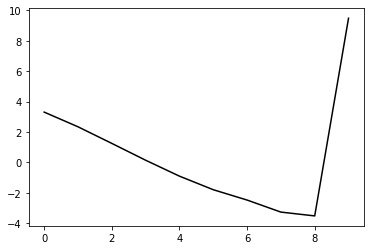

47300 0.321461615891996
0.5759210107024317 1.2550908469207942 -0.4675555395508996 0.2759237909263136
[ 3.24143888  2.41339421  1.3460373   0.25330994 -0.78496471 -1.67007411
 -2.34291135 -3.11911974 -3.35596354  9.37532547]


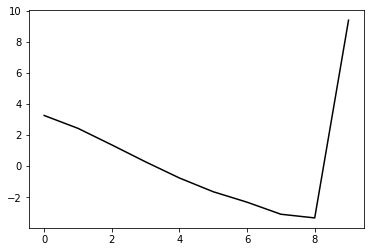

48400 0.3559632325152103
0.6551783886155373 1.2527706674672237 -0.4708201268342203 0.2735883811843352
[ 3.41598713  2.31501807  1.25693701  0.15597429 -0.89434127 -1.79087293
 -2.47035107 -3.23706454 -3.45293826  9.39438602]


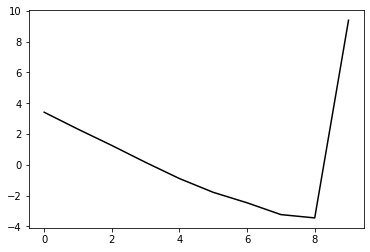

49500 0.39675638375767425
0.7335186524475827 1.2644705849480626 -0.48510422228978367 0.26732607864079794
[ 3.54131225  2.3047827   1.24933745  0.15143881 -0.90031485 -1.79779241
 -2.47237444 -3.21471388 -3.38301352  9.35044208]


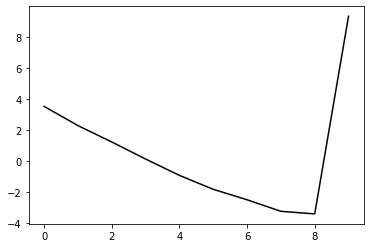

50600 0.3631332406201053
0.6847470912722079 1.2429255619485091 -0.4773479893992254 0.26319095157921457
[ 3.4598443   2.33839725  1.27364478  0.16375119 -0.90927451 -1.83416005
 -2.54058145 -3.31693361 -3.54954062  9.44982513]


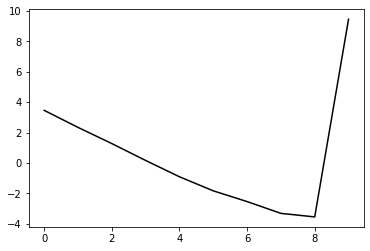

51700 0.4175465289515266
0.6236764783324504 1.2396703147586714 -0.4900172018930822 0.24534808004743006
[ 3.47011774  2.24885696  1.17837656  0.0621092  -1.02566111 -1.97156048
 -2.70352205 -3.50751989 -3.79415751  9.35949103]


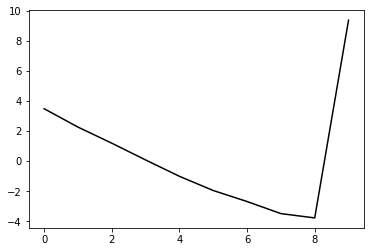

52800 0.7673624755828233
0.4122255474245783 1.2418536105186957 -0.5108249578563822 0.21174183307462252
[ 3.40102377  2.18770296  1.14328335  0.03764807 -1.05021799 -2.0070476
 -2.76232124 -3.60510184 -3.98514389  9.37501173]


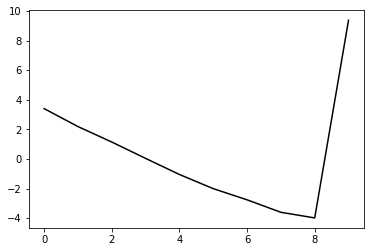

53900 0.36171405214539865
0.4808533326959734 1.2250394129843665 -0.5001256011179362 0.24904425721201
[ 3.36005822  2.38172154  1.35716291  0.26299032 -0.8168514  -1.76797642
 -2.51690117 -3.34546769 -3.71037983  9.31107165]


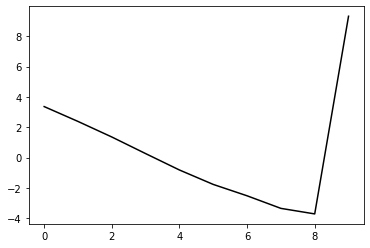

55000 0.3189328166535369
0.4734447461735319 1.1925808940104747 -0.4791450420270481 0.2708538378361987
[ 3.17280164  2.58056465  1.57628361  0.48156981 -0.60794789 -1.5750447
 -2.34429787 -3.19571187 -3.60815922  9.36898852]


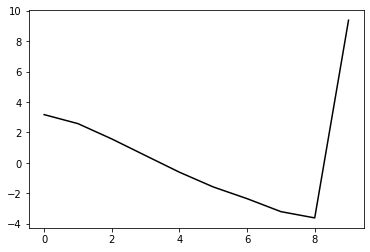

56100 0.3910265500586379
0.5223738425231511 1.1907629494901528 -0.483585016083795 0.2749113843621065
[ 3.23428831  2.58868978  1.61104778  0.53439341 -0.54413431 -1.50345644
 -2.26362452 -3.09534146 -3.47895826  9.36265196]


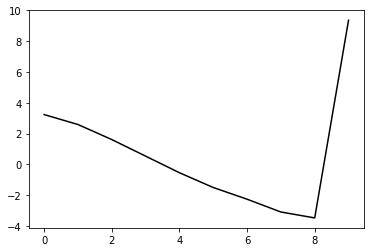

57200 0.6676870781181944
0.3391063776477941 1.2267427673789733 -0.5281112463176976 0.23149527514463603
[ 3.34136288  2.41476875  1.44727327  0.38407108 -0.69197813 -1.65734923
 -2.43078682 -3.28003096 -3.70338612  9.40823503]


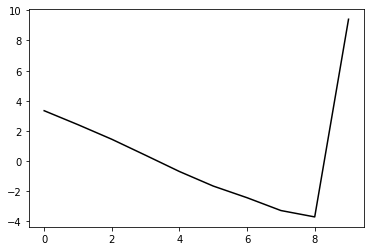

58300 0.2540204793649325
0.4529698178370277 1.1931045843869434 -0.511381547833765 0.25749213306121743
[ 3.41829358  2.47539674  1.50950601  0.44181239 -0.64481906 -1.62494153
 -2.41418589 -3.27637919 -3.72381907  9.36403531]


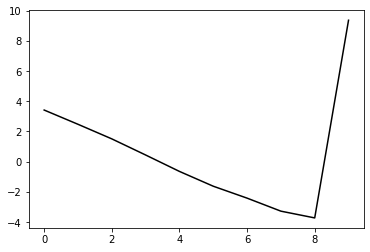

59400 0.3670530718897394
0.5484489467420652 1.1675553424092515 -0.4904654509511017 0.28022675153271076
[ 3.49647223  2.49472134  1.52428186  0.4400755  -0.66811216 -1.67124326
 -2.47843075 -3.34225561 -3.77211395  9.37885207]


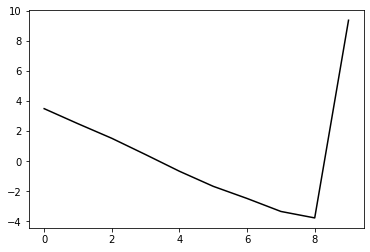

60500 0.31972897872239386
0.6462469160788468 1.1625938636769262 -0.48475049381630025 0.2959811155777711
[ 3.50690423  2.62661335  1.64835306  0.56921573 -0.53811642 -1.54204887
 -2.34500148 -3.18757097 -3.57596652  9.41458623]


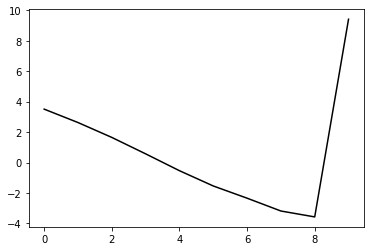

61600 0.350331486368353
0.6869010091723282 1.1718248017895252 -0.49872384420073607 0.29127976235503783
[ 3.63398753  2.59473417  1.60958315  0.5451398  -0.55231407 -1.55182939
 -2.34924033 -3.17237073 -3.52947043  9.38154569]


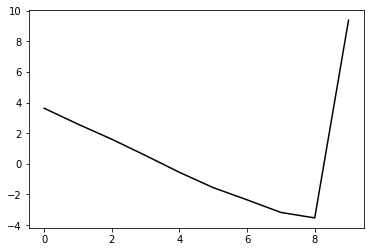

62700 0.5498714044547264
0.7148904809713593 1.1329489257009258 -0.471381572472505 0.3086480104378458
[ 3.55922679  2.65982095  1.63425203  0.53618946 -0.59861408 -1.64170447
 -2.48613649 -3.3583002  -3.79564654  9.28670583]


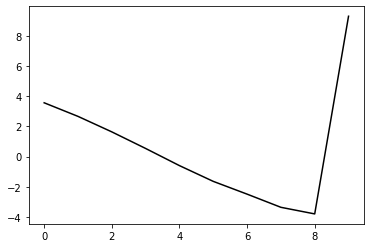

63800 0.7236262997081089
0.7691099807617962 1.1927805905184428 -0.5423733564499774 0.2405182095963759
[ 3.88993953  2.315807    1.29395178  0.21148071 -0.90968454 -1.94355633
 -2.77811787 -3.62812898 -4.02102729  9.37112393]


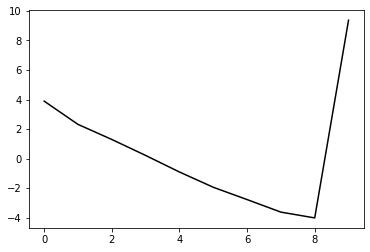

64900 0.39899191766168624
0.7353078751407944 1.133142750012311 -0.4916771036975467 0.30916565868289636
[ 3.63617356  2.63572643  1.5868518   0.48183506 -0.66419761 -1.72851664
 -2.59739341 -3.48496903 -3.94912806  9.35262515]


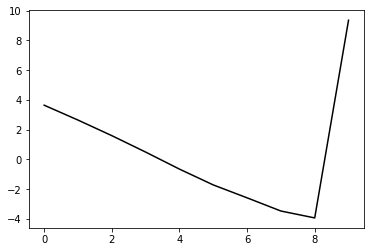

66000 0.3181240994000218
0.804341699567011 1.149420166842587 -0.5079740474354368 0.30631908919409956
[ 3.64936074  2.69869701  1.65652842  0.561481   -0.5739327  -1.62999493
 -2.48776641 -3.34818584 -3.75874331  9.41481786]


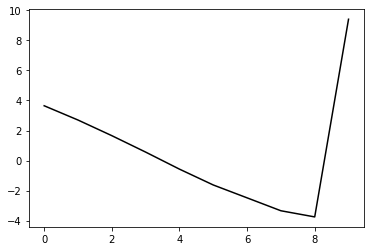

67100 0.3918356714560162
0.8846019547505041 1.1476131685989646 -0.5065476978273866 0.31894738046439647
[ 3.63954502  2.80857031  1.7756303   0.69064278 -0.43351164 -1.48124024
 -2.32694944 -3.15420329 -3.49996645  9.3358949 ]


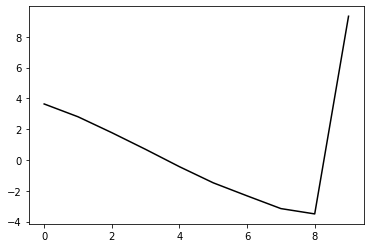

68200 0.3155328605531232
0.9779612075024428 1.1157822880670913 -0.4892448352074953 0.32144625987081765
[ 3.82278952  2.67078625  1.59332304  0.4628265  -0.70309255 -1.79285199
 -2.67566508 -3.52163479 -3.8715177   9.41953259]


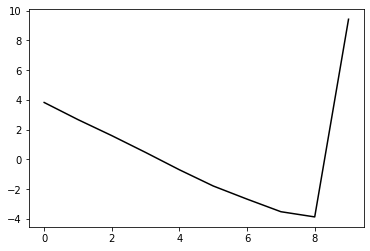

69300 0.33394974593523064
1.10752318638478 1.1225780472316151 -0.5077162985882491 0.308337441534403
[ 3.95091829  2.63192118  1.5362268   0.40467617 -0.75909508 -1.84622928
 -2.72076539 -3.53756586 -3.8227685   9.34520164]


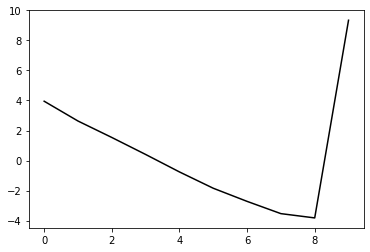

70400 0.3720913572283271
1.0193564661314183 1.1147649445921581 -0.5063915945845324 0.306442217498227
[ 3.89170572  2.68851522  1.57096701  0.41904836 -0.76753488 -1.88278516
 -2.79065687 -3.64635763 -4.00099562  9.37710441]


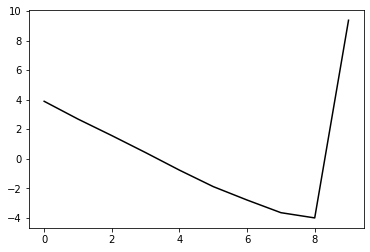

71500 0.289746932344234
1.0659347581512986 1.100665968045996 -0.4965894862612168 0.32181737514643927
[ 3.83599427  2.79124498  1.66384532  0.50026776 -0.69657137 -1.82376377
 -2.7427727  -3.60060772 -3.95234482  9.33380809]


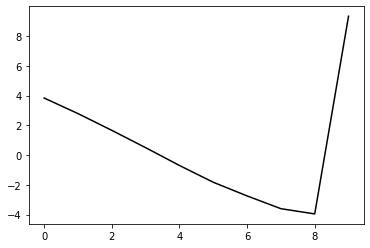

72600 0.6069036128590377
1.1434366789311652 1.0709242336193725 -0.47081887782074233 0.35850593723701785
[ 3.79132097  2.94625911  1.82164206  0.6605393  -0.53017297 -1.64982444
 -2.55456899 -3.3746027  -3.65593151  9.44348267]


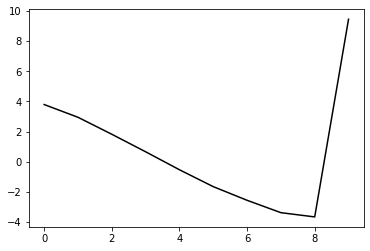

73700 0.4542521269195306
1.2185613340961288 1.0963178309333586 -0.5169317219035425 0.31092437769345194
[ 4.07856283  2.67495064  1.52221027  0.34455331 -0.86106522 -1.99615514
 -2.91451185 -3.73690242 -4.00016328  9.33348586]


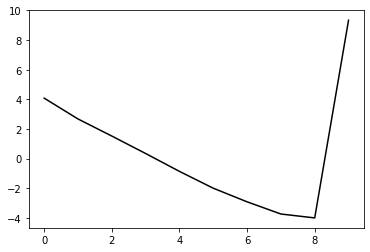

74800 0.45176196042398997
1.1472497259320176 1.0782000342395128 -0.5082372980684688 0.31140582555185187
[ 3.95070416  2.74885262  1.57203354  0.36702984 -0.87010197 -2.04475809
 -3.01233726 -3.89585382 -4.2616272   9.34798602]


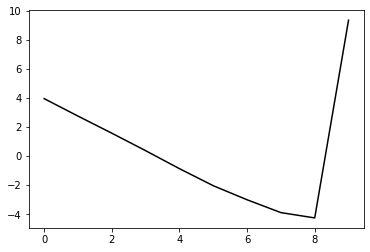

75900 0.36036235985041687
1.225925089211093 1.0657845042232534 -0.49855258224525306 0.3371316647414257
[ 3.93865146  2.88074545  1.72487166  0.52659048 -0.70078065 -1.86378473
 -2.81188685 -3.64920999 -3.92900996  9.32482335]


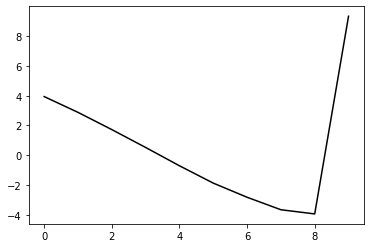

77000 0.3185939877623267
1.279264349899336 1.062593218624338 -0.5040496878317322 0.33807457281129066
[ 4.03444183  2.84640582  1.68807341  0.48146269 -0.75347949 -1.92417868
 -2.87670386 -3.70062265 -3.93887477  9.41566903]


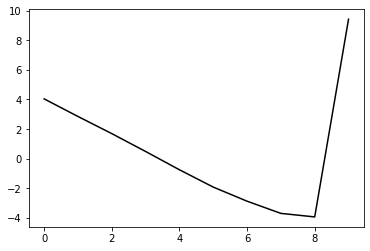

78100 0.3655217521860435
1.2664972980881632 1.0795314196612593 -0.5137845027889463 0.3396288438396242
[ 3.92167662  2.99517668  1.84419906  0.63995748 -0.59609105 -1.77205434
 -2.73270027 -3.55864403 -3.80060809  9.3631126 ]


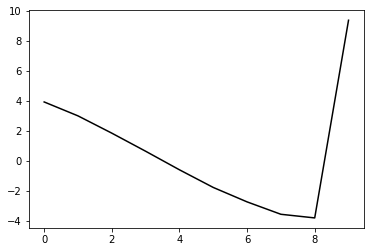

79200 0.286611231229274
1.3254291269837224 1.059495525664402 -0.5125132108108482 0.3370422542457278
[ 4.06789345  2.89003934  1.73051994  0.50952415 -0.74387016 -1.93768624
 -2.91387002 -3.74068891 -3.96214546  9.39379302]


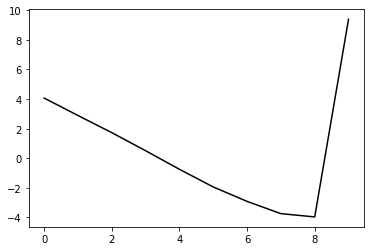

80300 0.29098981324167145
1.3270324732210788 1.0342704994991234 -0.5056612856047051 0.33973983142045966
[ 4.03635169  2.94398317  1.76433576  0.52175284 -0.7560312  -1.97709706
 -2.98287874 -3.83824634 -4.10535608  9.36094584]


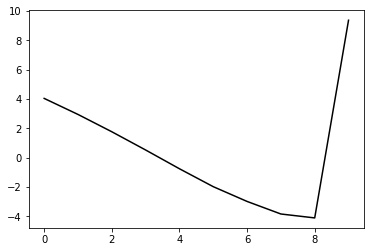

81400 0.42967331470266973
1.218176267461186 1.0500437294928642 -0.5219455137021881 0.31620171533841945
[ 4.00331243  2.89632825  1.71707637  0.45684118 -0.85018886 -2.11303315
 -3.17698371 -4.11681129 -4.54845827  9.33950849]


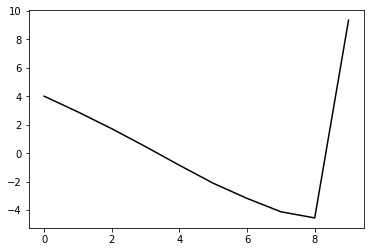

82500 0.28119725316480915
1.2398668032902798 1.0444097315531398 -0.5119617929385509 0.34157419911674375
[ 3.91909444  3.04536722  1.90362704  0.65463476 -0.6458441  -1.90466734
 -2.96364161 -3.8845755  -4.28759504  9.28540961]


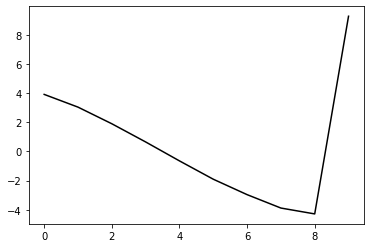

83600 0.3586347807503161
1.2856620372952976 1.0217059430981685 -0.5022608297081894 0.35308225264248566
[ 3.94387496  3.06512536  1.93221813  0.67620571 -0.63552026 -1.9060133
 -2.97333088 -3.88491791 -4.25748634  9.4017524 ]


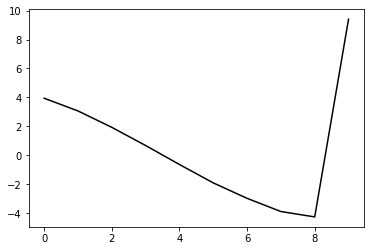

84700 0.4701745607138903
1.3386050354150554 1.045794136759589 -0.5295364680878455 0.33874687321501673
[ 4.11366223  2.98410638  1.85982592  0.61104662 -0.69956363 -1.97082555
 -3.03592353 -3.92487571 -4.22521592  9.3265151 ]


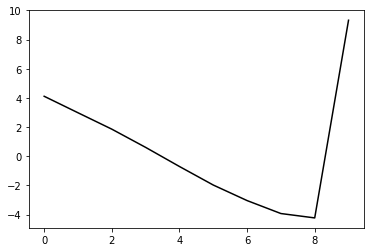

85800 0.46476213847084424
1.30490021070819 1.0851169535600158 -0.5586808539191519 0.32059154015933433
[ 4.07966952  3.01919749  1.893167    0.64919606 -0.66701282 -1.95233435
 -3.03976685 -3.95586528 -4.31251342  9.35561569]


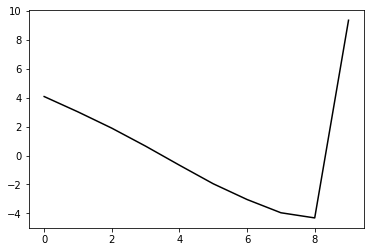

86900 0.4214225464934741
1.1823704424136732 1.091581066717517 -0.5633984065148905 0.3020949355444048
[ 3.94448846  3.01902251  1.91098859  0.64947699 -0.70431178 -2.04748804
 -3.21902275 -4.26466789 -4.8978952   9.29525102]


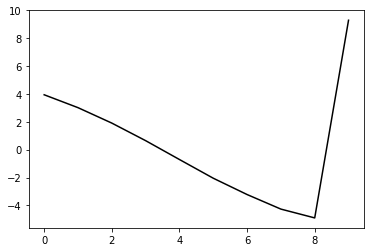

88000 0.3101766323650015
1.1521105410228023 1.045240301893929 -0.5321732762111191 0.33246642504546947
[ 3.77750289  3.16943348  2.09344298  0.82331829 -0.55129232 -1.92393787
 -3.1313651  -4.21684946 -4.94209562  9.36104982]


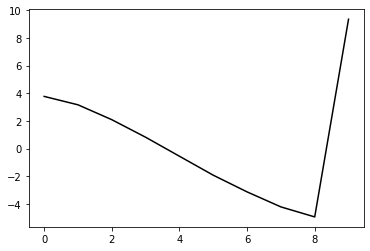

89100 0.42480330845483966
1.1500317909634512 1.0422091962959361 -0.5397222124926645 0.3269179703548593
[ 3.82200075  3.14139848  2.09337144  0.82182369 -0.56777631 -1.96147816
 -3.19139346 -4.29146567 -5.0305237   9.31792473]


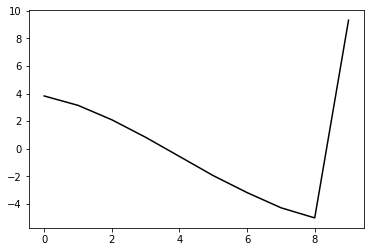

90200 0.38634337773775135
1.2163467946624118 1.0284150333963331 -0.5272606702118097 0.3559439260938289
[ 3.78832183  3.25045003  2.24021928  0.9842364  -0.40010975 -1.79187917
 -3.01755649 -4.09776001 -4.78943262  9.32349497]


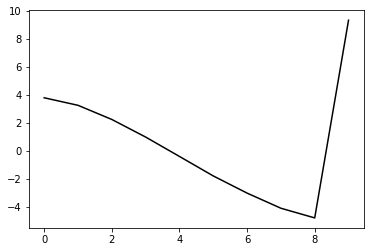

91300 0.3174212685707228
1.2636380368780997 1.0489094509254782 -0.551865245601865 0.34037112518721485
[ 4.00005029  3.08884973  2.0889735   0.84584267 -0.53707609 -1.93196186
 -3.15911415 -4.2231031  -4.85981224  9.29500241]


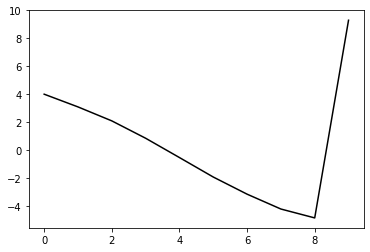

92400 0.3728042630262643
1.3166515583222944 1.0219928932684565 -0.5424181912194899 0.35105997385626037
[ 4.08614967  3.05367709  2.05164051  0.8075189  -0.5868035  -1.99851005
 -3.24107793 -4.3050472  -4.91941973  9.31384052]


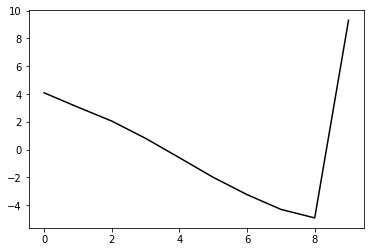

93500 0.31100440906915183
1.3289522290596076 0.995412509829697 -0.5238687761886038 0.3699321030313114
[ 3.92828528  3.23407008  2.21975351  0.97396521 -0.43323814 -1.86634685
 -3.13365247 -4.21715858 -4.85490287  9.3815324 ]


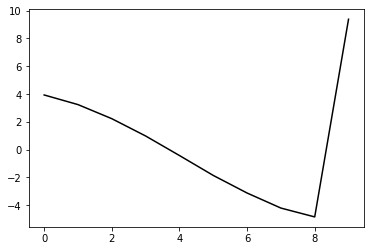

94600 0.3830490615600668
1.3802240412903048 0.9897746747125569 -0.5371804493115689 0.3551063757300028
[ 4.14735619  3.05053855  2.02588027  0.78021615 -0.63242377 -2.07570939
 -3.35162113 -4.42696403 -5.01980824  9.28121927]


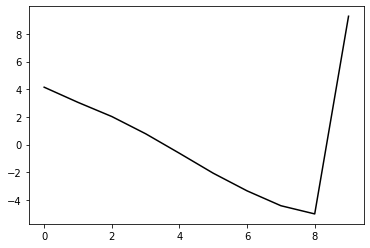

95700 0.4619965554989417
1.429133746481939 0.9916450027194411 -0.5393699169608855 0.36688612053798686
[ 4.14688554  3.13196815  2.10456306  0.86949695 -0.53925564 -1.98593265
 -3.26474703 -4.32531015 -4.86996004  9.3383677 ]


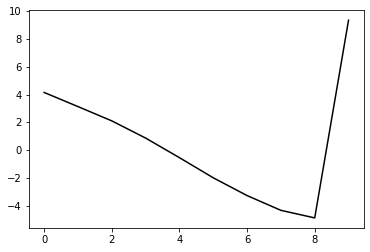

96800 0.38763917931130903
1.4932293974665747 0.9772152822474577 -0.5372537448627952 0.37573640870848285
[ 4.18303763  3.17949867  2.14008454  0.9083305  -0.50020982 -1.95249169
 -3.23589466 -4.28252968 -4.7752233   9.29698882]


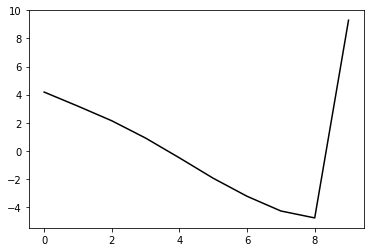

97900 0.34776358007845654
1.4828799412142317 0.9638697865168446 -0.531247155664456 0.38139075239111603
[ 4.09413172  3.27069494  2.20874266  0.96540125 -0.46006046 -1.94107205
 -3.26365344 -4.35600091 -4.9261632   9.36115597]


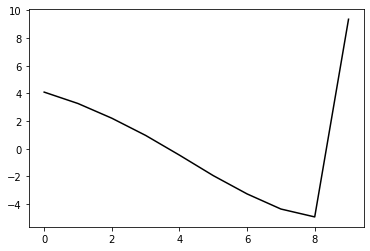

99000 0.32505097646334996
1.5083334917298006 0.9370966250931966 -0.5274829378405209 0.3845952123665772
[ 4.19962426  3.18597806  2.10467693  0.84354199 -0.60286852 -2.11451788
 -3.47523367 -4.60667869 -5.22750601  9.27920068]


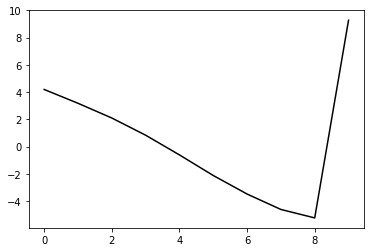

100100 0.352814423452834
1.5727587668189118 0.9468207102749744 -0.535072843736705 0.3913031517420237
[ 4.21264761  3.23827313  2.16100726  0.91232834 -0.52065133 -2.02323725
 -3.3748422  -4.47927822 -5.03401117  9.31048927]


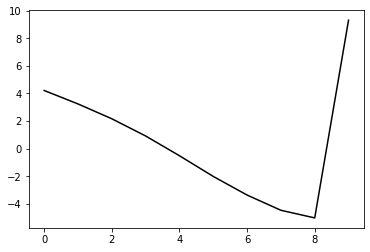

101200 0.41537076663237327
1.5191782944284309 0.9054646963392325 -0.510616025689521 0.40460567823222676
[ 4.15209123  3.27649726  2.16586093  0.88927846 -0.57570776 -2.12249337
 -3.53086263 -4.70397109 -5.37368923  9.20450624]


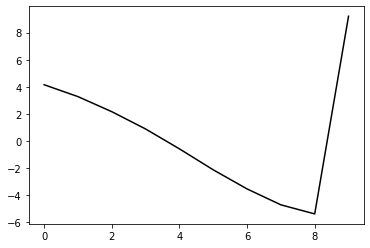

102300 0.290493395349576
1.5790303185051247 0.9271168601970091 -0.5421885735681045 0.3868682524205156
[ 4.27453423  3.22283627  2.11604588  0.84479672 -0.61367203 -2.15685562
 -3.5600529  -4.70738271 -5.29678143  9.29980113]


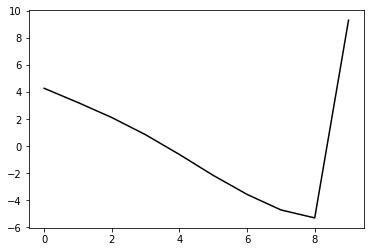

103400 0.4135213393162707
1.6156933029725957 0.9424269308658723 -0.5617744893675827 0.3731553954085988
[ 4.35137683  3.16658556  2.05137255  0.77711904 -0.68691514 -2.24320876
 -3.66379999 -4.81700247 -5.38155043  9.27579369]


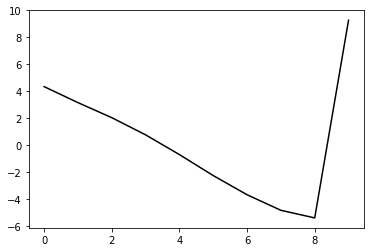

104500 0.30923593192474486
1.5729625093661914 0.8928780671656252 -0.5249866354291289 0.40175514844342675
[ 4.08438532  3.39270192  2.26357106  0.9667289  -0.52498378 -2.12214596
 -3.59775975 -4.81614475 -5.48519512  9.28716308]


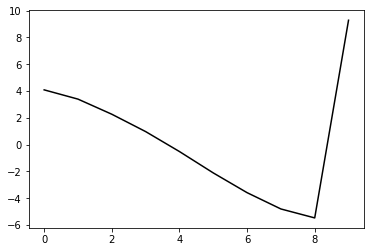

105600 0.3562076740745997
1.6398497406053243 0.9050103177085751 -0.5401760989239717 0.40139366101322815
[ 4.16979859  3.39685626  2.27753381  0.98777808 -0.49619076 -2.08970589
 -3.56109459 -4.74539201 -5.30397688  9.29357511]


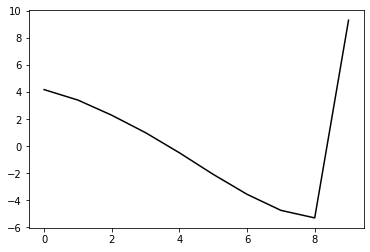

106700 0.45756963006928547
1.6821623310466427 0.895174403932766 -0.547293406687299 0.39568654012630966
[ 4.32325011  3.27624564  2.15621267  0.86381182 -0.62212265 -2.22192284
 -3.70164778 -4.87186911 -5.35401749  9.24909428]


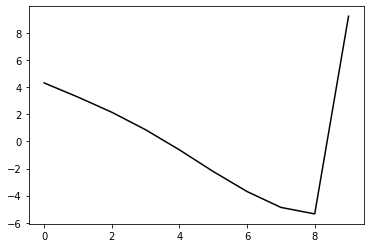

107800 0.3969532987684714
1.6916382976546005 0.928587065270979 -0.5632079619151045 0.395011067930923
[ 4.342725    3.33159129  2.23108554  0.9575608  -0.51267172 -2.1031609
 -3.57782417 -4.72465593 -5.15205544  9.31694088]


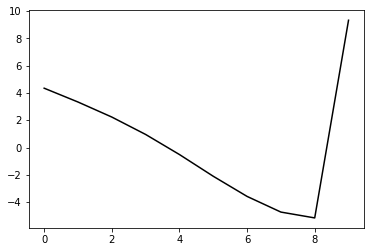

108900 0.34043650717499685
1.6828884272934392 0.9018057265924614 -0.558729481633915 0.3995496650854971
[ 4.34401905  3.35988357  2.24272541  0.95231099 -0.53712196 -2.15402148
 -3.66375253 -4.84800643 -5.3428244   9.30199741]


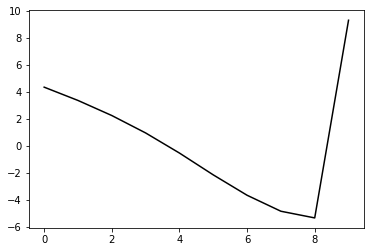

110000 0.3258280072170996
1.7321463170120157 0.8999005385401029 -0.5536676788361399 0.4221870759045845
[ 4.33106351  3.42395893  2.31619308  1.03352544 -0.44749423 -2.05736964
 -3.56031562 -4.72441159 -5.16046998  9.41216485]


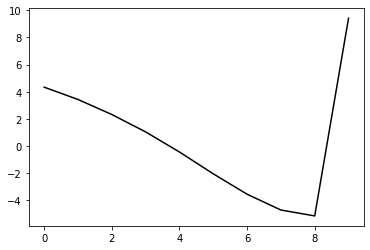

111100 0.3908344900512092
1.700945892630906 0.8761269558571481 -0.5555450681730418 0.4079503850383555
[ 4.35449007  3.35693042  2.2281682   0.92382478 -0.58057357 -2.21999535
 -3.76239777 -4.97514554 -5.48675555  9.30151316]


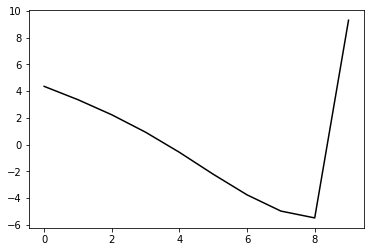

112200 0.29938581165137435
1.7200155910980388 0.8832558340412644 -0.5601419565020602 0.41106197244660353
[ 4.38341348  3.34380359  2.22101059  0.91905342 -0.58443484 -2.2272749
 -3.7777602  -4.98670554 -5.451102    9.28436465]


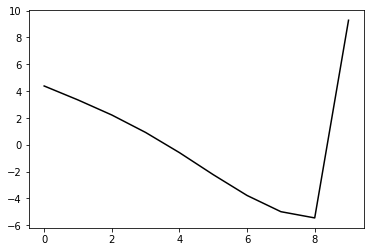

113300 0.31031848873617135
1.8057923149688813 0.8816306202847851 -0.575596038528827 0.40364419414567215
[ 4.50507428  3.32354569  2.20028104  0.90704384 -0.58485933 -2.21617507
 -3.75266972 -4.91817607 -5.26582852  9.32413002]


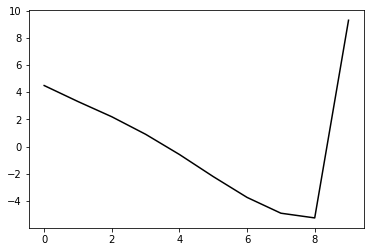

114400 0.5476225340965819
1.792411110212377 0.8987795176902994 -0.591215887890671 0.3874899539624701
[ 4.59628958  3.20794744  2.08296195  0.78901793 -0.7059841  -2.34621883
 -3.8996909  -5.07771651 -5.41077263  9.30045077]


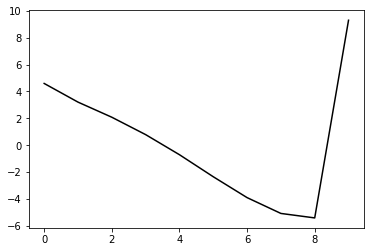

115500 0.2855603917645877
1.6970421450395565 0.8819802598110207 -0.5580255647119936 0.4244642559702523
[ 4.34820438  3.45188703  2.32588433  1.0178942  -0.49970276 -2.17627279
 -3.7868134  -5.05087249 -5.56812704  9.32504617]


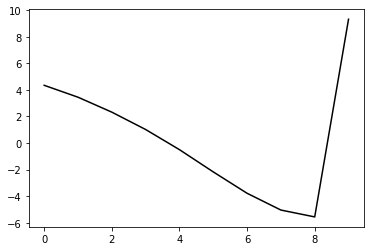

116600 0.3482724492673323
1.7184330569795168 0.9314812896904108 -0.5882722053708225 0.4130893506183703
[ 4.42645965  3.44954231  2.33867073  1.04787809 -0.45395448 -2.11736954
 -3.71693199 -4.9537549  -5.41381825  9.29954539]


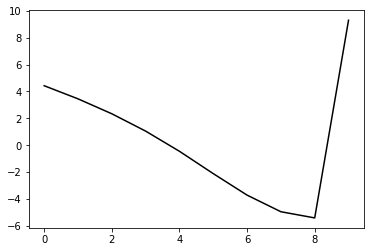

117700 0.5042917043698646
1.7232230411432634 0.9098516544430609 -0.5712618855776809 0.43643848718109046
[ 4.33313492  3.58080134  2.47166481  1.18129229 -0.32102758 -1.98798053
 -3.59421458 -4.82767501 -5.26315037  9.27237076]


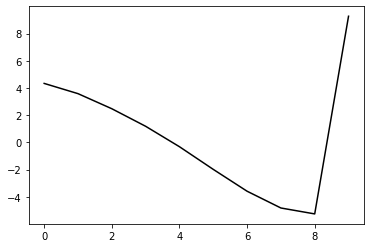

118800 0.3926944573789979
1.6887730336197262 0.8967040688732895 -0.5750946583734851 0.4236087712541164
[ 4.37665358  3.50527712  2.38302715  1.07204477 -0.45604925 -2.15668973
 -3.80708332 -5.09347907 -5.60770738  9.33129702]


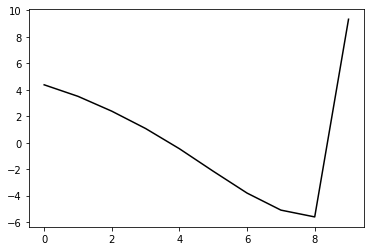

119900 0.34225778766231585
1.6786779896384152 0.89718999164736 -0.5804910077739985 0.41993122198830163
[ 4.41263135  3.46648361  2.34962745  1.0305411  -0.50989965 -2.22913392
 -3.90614135 -5.21907876 -5.75635367  9.23564389]


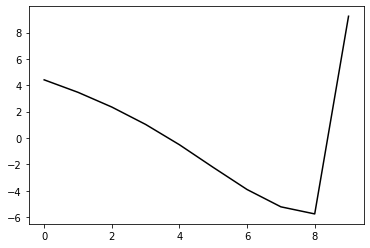

121000 0.30988228021437825
1.6823218593455902 0.9111378803279612 -0.5926436075021271 0.41229468879006054
[ 4.44478793  3.41835759  2.31369769  0.99563101 -0.54924487 -2.27935812
 -3.97631768 -5.30870082 -5.85202326  9.28910812]


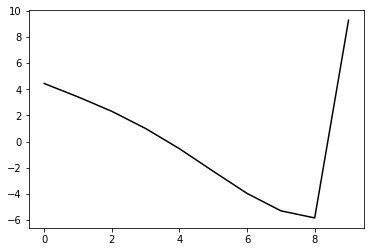

122100 0.3808578799632307
1.7063954821958338 0.8863230942465317 -0.572215607820215 0.43644032416849826
[ 4.25243379  3.62184502  2.549216    1.23886048 -0.30304215 -2.03506721
 -3.74020537 -5.06929798 -5.57801426  9.26631621]


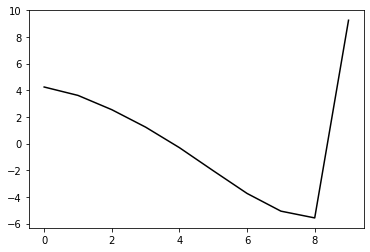

123200 0.2981333672660202
1.7146369634536123 0.8681495386974896 -0.5781043842791497 0.4250738976278994
[ 4.46817773  3.40643946  2.33200134  1.01190495 -0.54531099 -2.29736734
 -4.02913881 -5.3797097  -5.88578653  9.32963417]


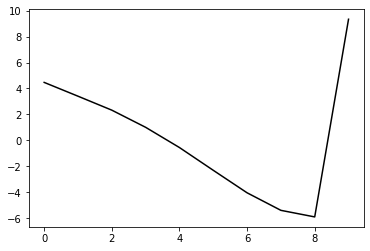

124300 0.2937326632045453
1.757701735720099 0.8783925846856464 -0.5912517066219772 0.4222909159238042
[ 4.52414826  3.4152402   2.34990247  1.04342085 -0.50708899 -2.25751089
 -3.99155374 -5.32711064 -5.76192259  9.21463981]


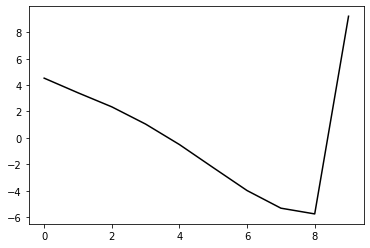

125400 0.4318297507832136
1.7576067353880196 0.9017842196931328 -0.6042908817086114 0.4160536146582267
[ 4.5316807   3.41839641  2.35993533  1.06446403 -0.4822365  -2.23598376
 -3.98199331 -5.32353733 -5.72716439  9.28875132]


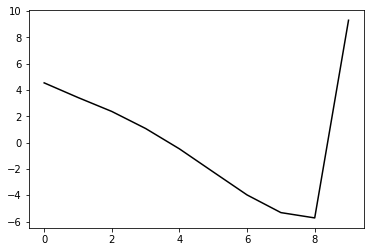

126500 0.5157606805057607
1.73297544873699 0.9324333839382638 -0.6237514628411036 0.40149349221781705
[ 4.51599402  3.44560712  2.3849421   1.09053363 -0.46269123 -2.23255783
 -4.00702724 -5.3844995  -5.84689125  9.26954012]


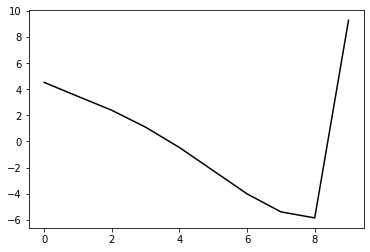

127600 0.381857623727036
1.6525362236447645 0.8892697396162269 -0.5735451857693605 0.45323010535130165
[ 4.22593328  3.7112159   2.67671869  1.38213456 -0.18124864 -1.97457424
 -3.79035508 -5.22825919 -5.82549722  9.28464088]


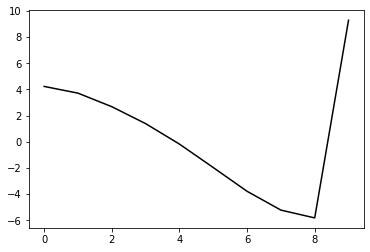

128700 0.48312348900486773
1.715823200980511 0.902011734703577 -0.5920015399660628 0.4452527975184605
[ 4.38176712  3.61301666  2.59603971  1.31486854 -0.23944199 -2.02796227
 -3.84236939 -5.26152395 -5.76736241  9.2850144 ]


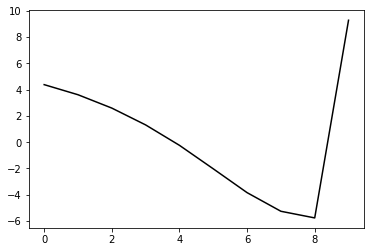

129800 0.40482689856062903
1.7372461844595264 0.9073101393988143 -0.605141313581721 0.43618296552391483
[ 4.51331138  3.51211055  2.48937275  1.20933395 -0.34879721 -2.14745693
 -3.9787652  -5.40863456 -5.8940471   9.33094827]


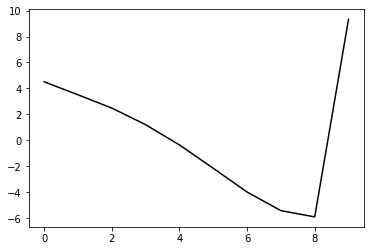

130900 0.326853646966628
1.7468957494166812 0.8768955585649574 -0.5910315319026409 0.45004151335696546
[ 4.43915952  3.60913714  2.58093475  1.29849794 -0.2658752  -2.07696618
 -3.92697413 -5.36962647 -5.84129563  9.27088459]


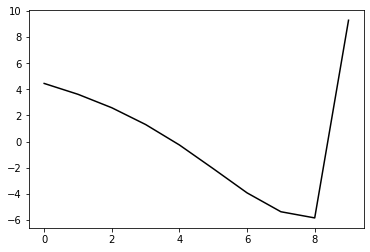

132000 0.3375239527306711
1.7414582476651828 0.8959564845096851 -0.6180338278242375 0.4248817951222412
[ 4.52557413  3.5241111   2.48926189  1.20434285 -0.36796288 -2.19554094
 -4.07248816 -5.54766163 -6.06847928  9.20922851]


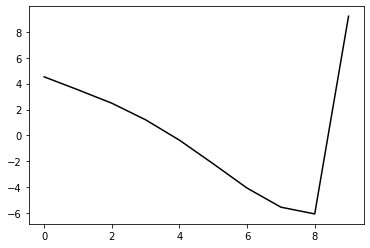

133100 0.36556482045221195
1.764937034739002 0.8801761700101484 -0.6024694277291394 0.44957827210258416
[ 4.46053454  3.61351931  2.58626288  1.30526716 -0.26408311 -2.0922008
 -3.97403753 -5.44906443 -5.94432638  9.2711638 ]


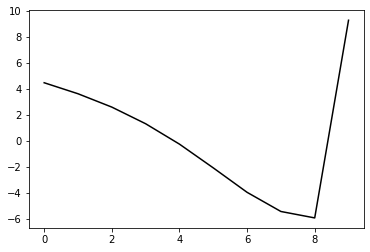

134200 0.30407527858009287
1.7056715019090718 0.8477193526956817 -0.5942687140170932 0.44605830967127874
[ 4.4705618   3.56109352  2.51471452  1.21542574 -0.3752764  -2.23208077
 -4.15405691 -5.68079456 -6.25640718  9.28338801]


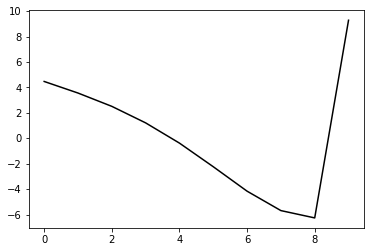

135300 0.2868472823859105
1.7785958134802355 0.8320098390414068 -0.6015149139216037 0.4401493651103993
[ 4.57331576  3.47421374  2.42624951  1.13091438 -0.45428258 -2.30799439
 -4.23138474 -5.74766226 -6.24514784  9.27472034]


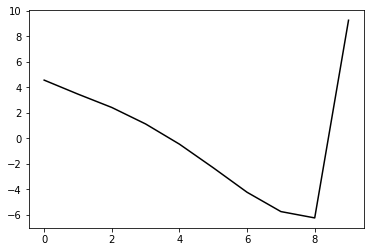

136400 0.3596136815705243
1.7900167651306456 0.8092640325889378 -0.6003991426143046 0.43735709182607063
[ 4.55345112  3.47986735  2.4033419   1.0946323  -0.50562765 -2.38202467
 -4.34034603 -5.89787544 -6.43902575  9.2570908 ]


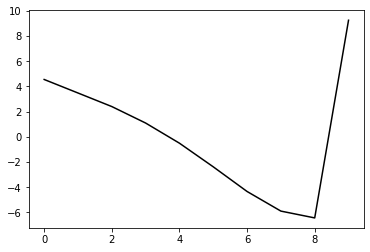

137500 0.30201500831020855
1.8333761726334217 0.8542683411823193 -0.6118076573034955 0.4485273733591471
[ 4.47829257  3.66260335  2.60788136  1.32711322 -0.24998418 -2.1111738
 -4.0615184  -5.59733659 -6.07069528  9.36557102]


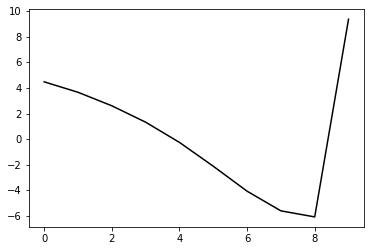

138600 0.42895902819585785
1.811967735236631 0.8446058382886202 -0.5876530807685706 0.4868223161651463
[ 4.39504744  3.80206328  2.75816153  1.48909448 -0.07548574 -1.92755242
 -3.87368905 -5.39548122 -5.81520686  9.29198492]


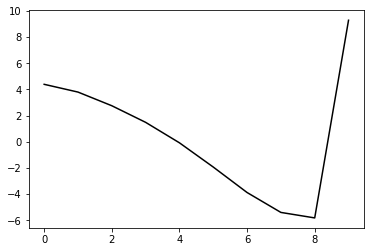

139700 0.4941022686648532
1.8026090395040402 0.8256129809235695 -0.5947126865614001 0.4742635628113758
[ 4.51053043  3.67170222  2.60842539  1.32239122 -0.25910605 -2.13348867
 -4.11049562 -5.66813804 -6.12848706  9.26322257]


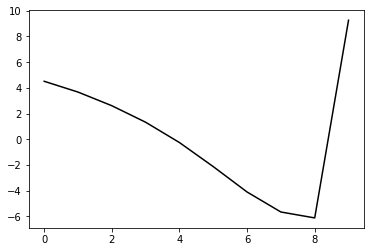

140800 0.38164626936381
1.8324124113049058 0.8349819655298498 -0.6074966416999061 0.4648356448170399
[ 4.49104123  3.69907567  2.63582972  1.35322839 -0.22521483 -2.10213254
 -4.0906854  -5.65739591 -6.0909118   9.33842419]


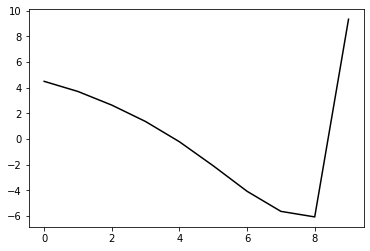

141900 0.3661142113502304
1.8474950929750733 0.8270377165364581 -0.6235665184135345 0.4485616955275955
[ 4.67798318  3.54291508  2.47087742  1.17934125 -0.40594472 -2.29287083
 -4.29730202 -5.87451072 -6.28735123  9.25074383]


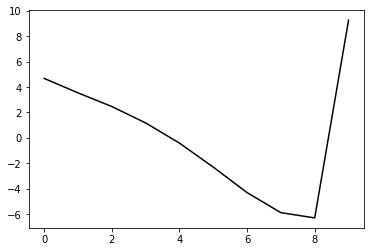

143000 0.32778910918005677
1.8959479062218156 0.8090273188535178 -0.6148524827510318 0.4689499682067782
[ 4.66188042  3.61547447  2.54397354  1.2553892  -0.3250495  -2.20861698
 -4.21284977 -5.77946372 -6.12747235  9.26463901]


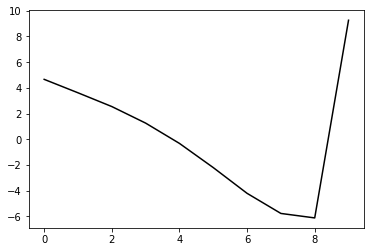

144100 0.3929006578268419
1.852382790159531 0.817904199279798 -0.619838964065379 0.47067912304317616
[ 4.61339106  3.67286997  2.59111934  1.29612698 -0.29294987 -2.19120754
 -4.22023445 -5.82097012 -6.2363463   9.17933624]


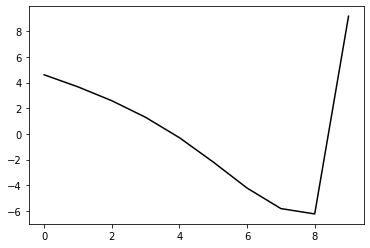

145200 0.35008010605468287
1.89165147538125 0.8144518306348023 -0.6124791958750369 0.4872552951033516
[ 4.62338072  3.70279945  2.63585867  1.34892902 -0.23045349 -2.12047158
 -4.14514606 -5.73333637 -6.08768899  9.27261399]


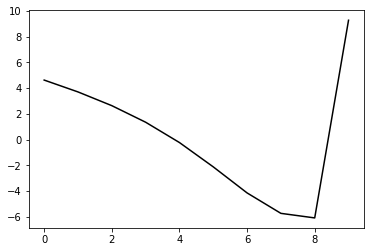

146300 0.27366975194174326
1.906210511912119 0.8226543902263824 -0.6261402142757488 0.4774800838019564
[ 4.64985076  3.69585308  2.62512037  1.33720606 -0.24266498 -2.13586976
 -4.17104223 -5.77123755 -6.11642806  9.24278157]


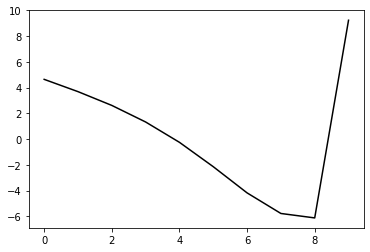

147400 0.437176327039082
1.8991313878073137 0.8315605108693516 -0.6395069085574271 0.461745269025663
[ 4.73763452  3.56949596  2.48851428  1.19375204 -0.39331957 -2.29877756
 -4.35900956 -5.99310448 -6.35288215  9.3399744 ]


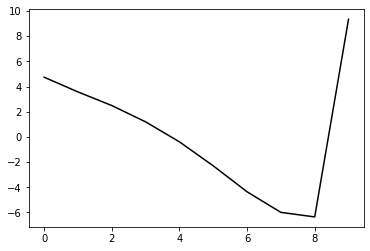

148500 0.2819078368358912
1.843210215872515 0.7952479887827554 -0.617769299037908 0.47955740662709334
[ 4.52230265  3.76089383  2.66681446  1.34956711 -0.26455952 -2.20710379
 -4.32259759 -6.03789301 -6.57623083  9.2165164 ]


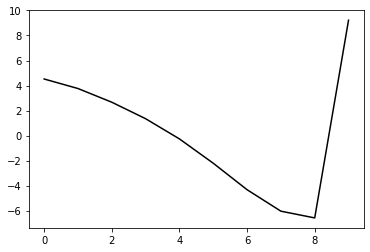

149600 0.34976866176399996
1.8387037336702285 0.8171127406226464 -0.6217896409686555 0.48460370886927173
[ 4.49048369  3.80730801  2.73916138  1.43359655 -0.17363673 -2.1155756
 -4.24241039 -5.97130721 -6.48865044  9.2646934 ]


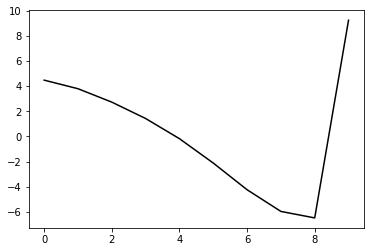

150700 0.46985090002295454
1.8178999808814604 0.8047337807954134 -0.6254229832683681 0.4758895965906027
[ 4.6020325   3.65794347  2.59893927  1.27959459 -0.34448225 -2.30842966
 -4.47121051 -6.24731741 -6.77816564  9.20522904]


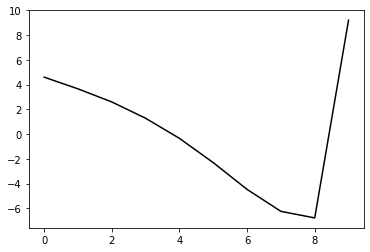

151800 0.42003468464434013
1.908487861435128 0.832402336852196 -0.6452477394332893 0.4739375375152115
[ 4.70728352  3.63906271  2.6112961   1.32230952 -0.27397766 -2.2101397
 -4.34618411 -6.07024094 -6.44232728  9.30778139]


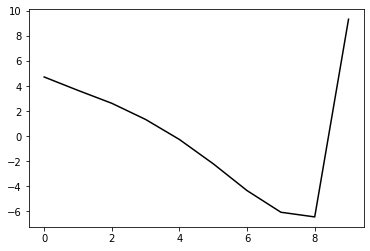

152900 0.3117355658878448
1.897164911343881 0.8485191414542074 -0.6424658609439152 0.4873789392106047
[ 4.58264073  3.79912647  2.79064613  1.51313801 -0.07988305 -2.01958179
 -4.16958683 -5.90939427 -6.26495996  9.23768751]


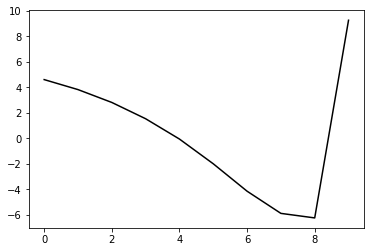

154000 0.32060038558702203
1.8680033360533888 0.8220853980699062 -0.6317573960862762 0.4908427557613396
[ 4.50925856  3.81307362  2.79927543  1.50746205 -0.10685765 -2.0765095
 -4.27143434 -6.06990713 -6.49372029  9.2504957 ]


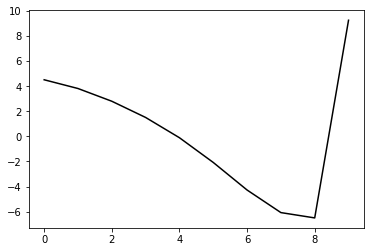

155100 0.38011591496329794
1.930277095437886 0.8058112010849072 -0.6294536285733728 0.5014038594089939
[ 4.53258875  3.84746062  2.84920486  1.57099096 -0.03275198 -1.99440084
 -4.18629316 -5.97036868 -6.290622    9.20810508]


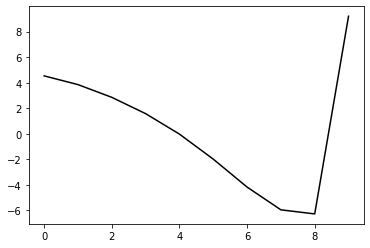

156200 0.30553679193112104
1.8663097417951453 0.7646475581686472 -0.6267288906765014 0.48676622154895544
[ 4.63492338  3.66880364  2.64237756  1.34077954 -0.28865094 -2.28159824
 -4.51813296 -6.36761255 -6.78746414  9.21072649]


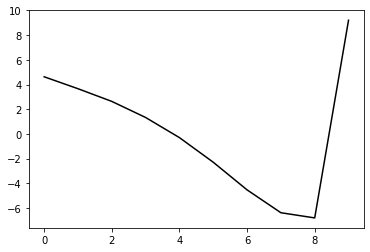

157300 0.28528627801285367
1.89771851758142 0.771343556698878 -0.6379988378671665 0.48005963882276137
[ 4.64988516  3.67074151  2.64372112  1.35037371 -0.2748111  -2.26923384
 -4.51638732 -6.37362098 -6.73887194  9.23023369]


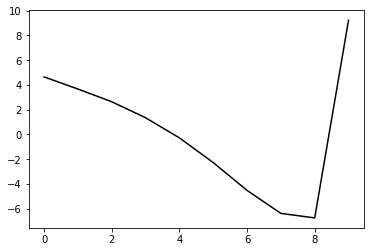

158400 0.4027620355404744
1.8849869881964967 0.7838120699230422 -0.6367539394620648 0.49189751908135043
[ 4.5602489   3.78388544  2.75847792  1.47119461 -0.15357527 -2.15592627
 -4.42434609 -6.31657917 -6.74148575  9.34749285]


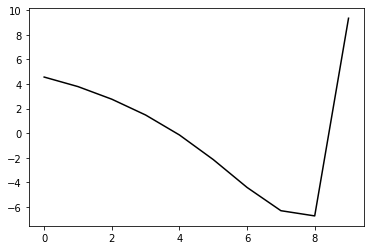

159500 0.28619189652887456
1.96560148750645 0.7792755031270656 -0.6400560982137354 0.5005222313767324
[ 4.66869311  3.754556    2.74849009  1.48153511 -0.12055074 -2.10017071
 -4.34681976 -6.19740857 -6.45167546  9.22839899]


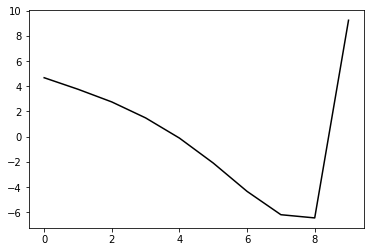

160600 0.34824403001593357
1.8454304274385358 0.7741313068983425 -0.6338133572126572 0.4996234098177573
[ 4.49301322  3.85116197  2.81590664  1.52191519 -0.11479691 -2.14285531
 -4.46081596 -6.42079335 -6.8955966   9.24534402]


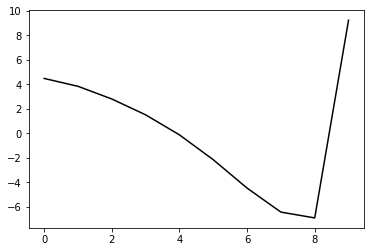

161700 0.46870661379418177
1.8417184048918929 0.748965621851997 -0.6280114030131094 0.504982028037059
[ 4.5955734   3.74299915  2.71299999  1.4140048  -0.22652581 -2.26099245
 -4.59381095 -6.57582045 -7.03046623  9.19744978]


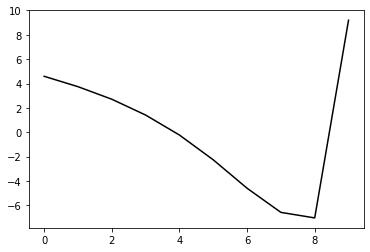

162800 0.4318912285593274
1.9183127863296572 0.7860732348511992 -0.6626516900876895 0.48494928288696315
[ 4.70632197  3.69895213  2.678947    1.39821492 -0.22565887 -2.24627123
 -4.56971679 -6.52904491 -6.85761368  9.28148335]


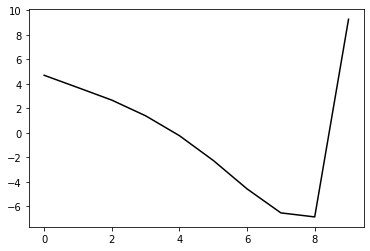

163900 0.3442373047837211
1.875896331189195 0.7447164121655537 -0.6302720687928899 0.5158518737755694
[ 4.59682078  3.79785237  2.7842407   1.49475663 -0.14138848 -2.18268062
 -4.54271891 -6.55884632 -6.98857175  9.18916848]


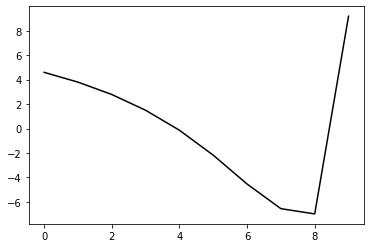

165000 0.3263261555752779
1.9592120533019206 0.7787489910757964 -0.659841446007971 0.5052834924462767
[ 4.73895308  3.74354018  2.74867527  1.48150491 -0.1328664  -2.15284329
 -4.49299732 -6.47662178 -6.78190239  9.24974445]


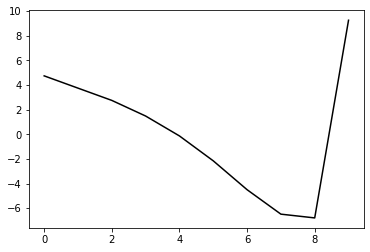

166100 0.36202193651868
1.9296102583050891 0.7802924379969347 -0.6515136010695903 0.517283260948684
[ 4.60371845e+00  3.87963375e+00  2.88221110e+00  1.61522538e+00
 -3.48482372e-03 -2.03526403e+00 -4.40194411e+00 -6.43354933e+00
 -6.81154630e+00  9.20523675e+00]


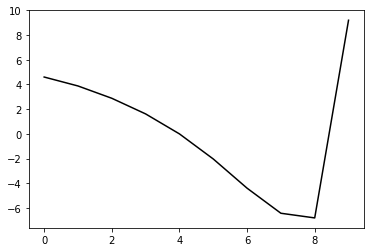

167200 0.3388725990846964
1.949427073428008 0.8054883565624285 -0.6724369151378506 0.5016414686052915
[ 4.73662504  3.7439776   2.75648572  1.49819623 -0.11358418 -2.14310602
 -4.51775073 -6.56284183 -6.89457912  9.25805563]


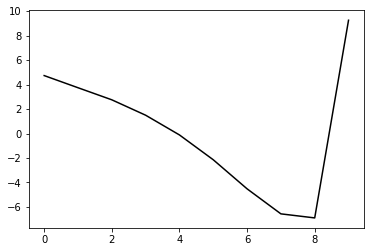

168300 0.2834958776061591
1.9134265817743086 0.8139663391967142 -0.6707210408902229 0.5087401342210776
[ 4.64092564  3.84244893  2.85354859  1.59308275 -0.02564329 -2.07036364
 -4.47568258 -6.57363207 -6.98785715  9.14228542]


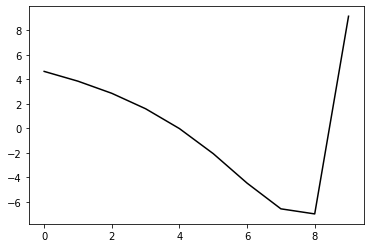

169400 0.36741359680400676
1.8999561424805615 0.8196583361856322 -0.6747829334915808 0.507956536108918
[ 4.71339338  3.76991814  2.7864953   1.52914334 -0.08782147 -2.13509612
 -4.55357555 -6.67805643 -7.09126513  9.26197705]


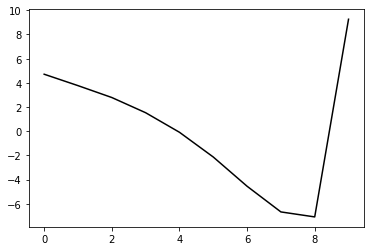

170500 0.2829354787068812
1.8520314699902751 0.8309095204176405 -0.669641321661681 0.5169744430413905
[ 4.51008198  3.96333547  2.99277387  1.74098056  0.1213822  -1.93999487
 -4.39413224 -6.59012668 -7.16714816  9.1817586 ]


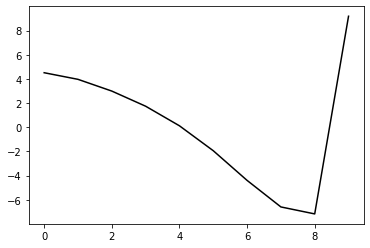

171600 0.37894218509768623
1.856733737444645 0.8354714392923185 -0.6779986697639087 0.5096131391648061
[ 4.67348269  3.77718536  2.82389249  1.57383496 -0.04572508 -2.11129758
 -4.58162333 -6.80798478 -7.32226285  9.23633145]


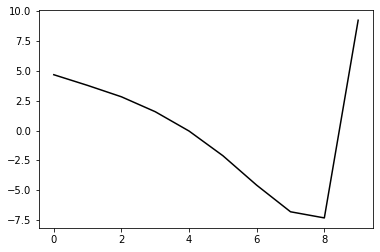

172700 0.463061037251546
1.804160648945883 0.8209786043630429 -0.6645720352821919 0.5217380008386302
[ 4.55007646  3.88787472  2.94463914  1.69188727  0.0624212  -2.02246421
 -4.52895942 -6.81219441 -7.41315326  9.19222861]


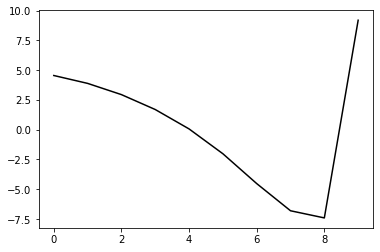

173800 0.397867447146757
1.9169740554533954 0.8369017535541565 -0.6825000038652349 0.5209053015383555
[ 4.66009212  3.8794451   2.96825067  1.75003305  0.15270362 -1.90086507
 -4.37754359 -6.61665763 -7.04241427  9.24595417]


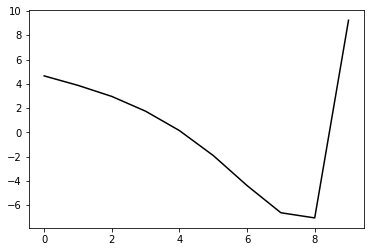

174900 0.3072214337928805
1.9693380651371108 0.8334760381111334 -0.6846663630809744 0.5259438769065234
[ 4.68828157  3.9130093   3.00249034  1.80298816  0.22228913 -1.81909026
 -4.29145276 -6.52814375 -6.88859842  9.16356154]


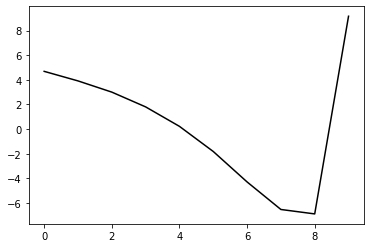

176000 0.3240490589232085
1.8679695923361426 0.7937250342096849 -0.6752185541671083 0.5234640704133829
[ 4.66711499  3.90505255  2.9553949   1.72783396  0.11781672 -1.96133424
 -4.48680238 -6.79759355 -7.28646053  9.19119271]


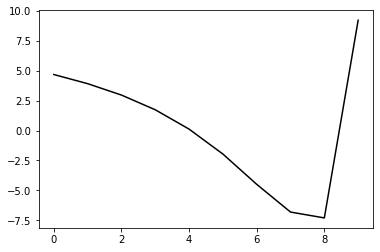

177100 0.3796318755166707
1.941736820657459 0.7867623983680198 -0.6683988723886339 0.5453954064773329
[ 4.61506066  4.0120087   3.07285671  1.85467509  0.25406313 -1.8179906
 -4.33967564 -6.64316952 -7.07358037  9.21385249]


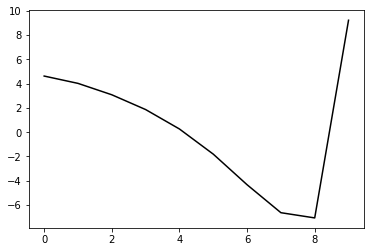

178200 0.29575516135784924
1.9249626653468488 0.7984811093362378 -0.6872112018740376 0.5248237620951801
[ 4.70356415  3.88708397  2.93964976  1.71933606  0.11702028 -1.9596457
 -4.49391223 -6.82391538 -7.27152892  9.29189722]


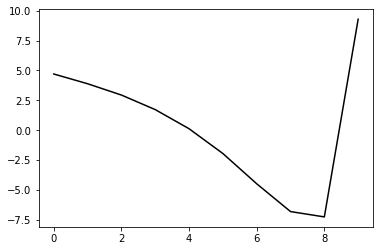

179300 0.2794804004885614
1.918104701810812 0.7902700965610732 -0.6844977244833236 0.5279986467323096
[ 4.6328299   3.94717616  3.00505251  1.78249002  0.17770581 -1.90583144
 -4.45758761 -6.81996587 -7.29353525  9.20828765]


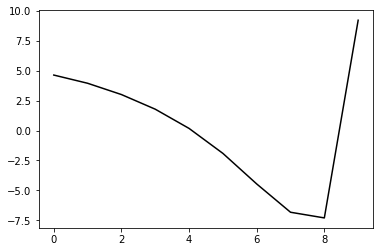

180400 0.424174364472685
1.9138066602209505 0.7824918325319609 -0.6764342462628388 0.5397620800328914
[ 4.61104031  3.9786409   3.03664703  1.81728475  0.21383172 -1.87348735
 -4.43976451 -6.82832039 -7.29381969  9.20773087]


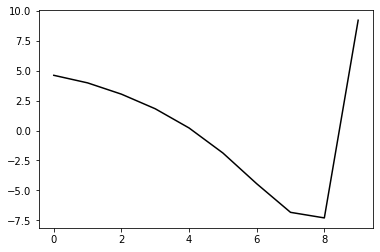

181500 0.31440485612986746
1.9069152308038144 0.7905154585438268 -0.6927965676043057 0.5248131325299275
[ 4.69050208  3.9134018   2.96518695  1.74351695  0.13810427 -1.95491644
 -4.53681929 -6.95393753 -7.42568777  9.12546321]


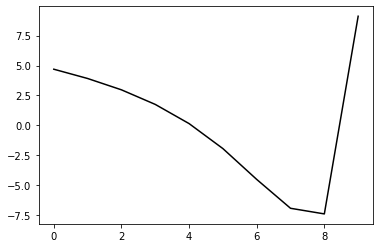

182600 0.3523393405445324
1.9015207947452228 0.7613287563820814 -0.6684356854524431 0.5493852638038318
[ 4.54398212  4.04877625  3.10255428  1.88095951  0.2748787  -1.82332881
 -4.42144011 -6.8691593  -7.36142677  9.24620762]


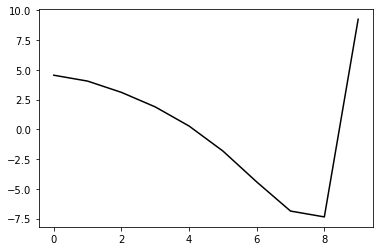

183700 0.4712560457315652
1.9095830165180514 0.7852388786288217 -0.7029630858737523 0.5182284557695928
[ 4.77993843  3.83604034  2.88490769  1.66157138  0.05514291 -2.04488872
 -4.65193247 -7.1211766  -7.59490125  9.18285072]


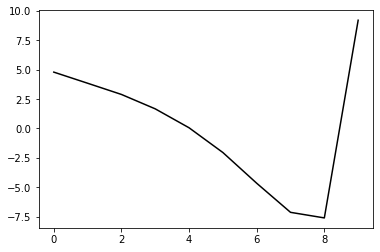

184800 0.3870293526123022
1.8955472850861856 0.7272089013942213 -0.6622972287786513 0.5567637916496782
[ 4.61517382  4.00734995  3.057796    1.83080214  0.22147596 -1.88470116
 -4.50812184 -7.008062   -7.51255947  9.20392142]


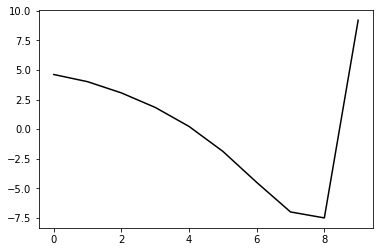

185900 0.33301949029248135
1.9474328088088384 0.7212469636777596 -0.6734100838635241 0.5494209589300649
[ 4.72867563  3.91837442  2.96598627  1.74382535  0.14176584 -1.95723311
 -4.5806748  -7.09394494 -7.52781735  9.27753495]


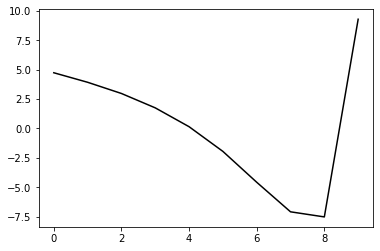

187000 0.32570619782923743
1.9767038774779022 0.7325648234751143 -0.6884995969212503 0.5407732901035616
[ 4.77815412  3.89285031  2.94305709  1.72914584  0.13656759 -1.95405643
 -4.57682354 -7.10306122 -7.48277074  9.19885378]


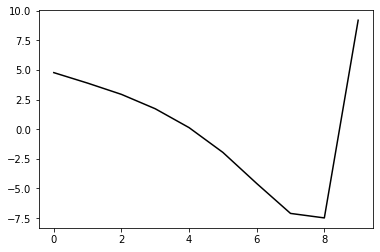

188100 0.38822057280015587
1.973707335397141 0.7396977597505274 -0.6747006460829034 0.566631493516842
[ 4.61648373  4.08475683  3.14444872  1.94178641  0.35755145 -1.73026698
 -4.36267804 -6.92046341 -7.3424127   9.18839782]


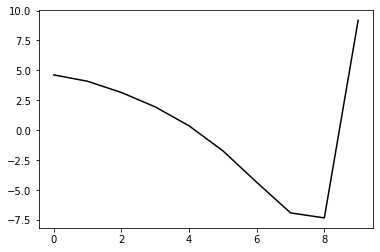

189200 0.33945214888066133
2.030803119418839 0.7483198080961674 -0.6928254475898119 0.5571163066866107
[ 4.82246897  3.94560104  3.00259199  1.80405061  0.22595621 -1.85767123
 -4.49159329 -7.05073809 -7.3877618   9.27997458]


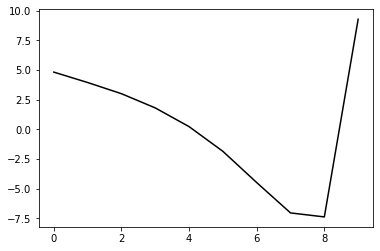

190300 0.28374702272963154
2.0017859284115986 0.7437816618153611 -0.7043788191240827 0.5410102188098671
[ 4.78798089  3.94404889  2.98470983  1.77541282  0.18875888 -1.90551278
 -4.56006995 -7.16344646 -7.55608237  9.18318971]


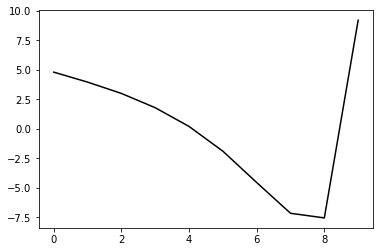

191400 0.3770360957472961
1.9502252841340764 0.7481006947806453 -0.7018518507106734 0.5467648516402399
[ 4.77209004  3.95737858  2.99438333  1.78027791  0.18917872 -1.91225365
 -4.58360838 -7.22822569 -7.67327475  9.18758375]


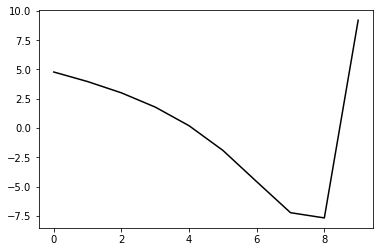

192500 0.2944054969113567
2.0237142598822593 0.7460976554861302 -0.7070285577318188 0.550575987282741
[ 4.77423972  3.99490837  3.05068559  1.85039705  0.27727955 -1.80455915
 -4.46031311 -7.09812151 -7.44828715  9.12836428]


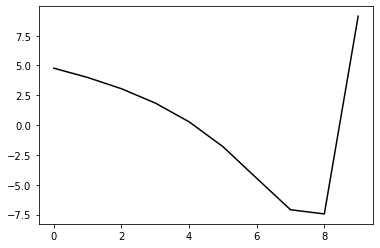

193600 0.35000770878557236
2.040285727280694 0.7134337119361368 -0.6941203359064608 0.5625503174836123
[ 4.70618873  4.07215501  3.11291733  1.90870714  0.33560068 -1.74600137
 -4.40875412 -7.06904511 -7.41237896  9.21710614]


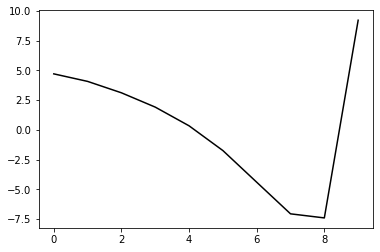

194700 0.503321062581643
2.0359529064769153 0.6828577286164815 -0.6829818379173382 0.5721893059971949
[ 4.72368924  4.05291729  3.08125359  1.86900456  0.29250234 -1.79197794
 -4.46519653 -7.15755778 -7.53381036  9.20623081]


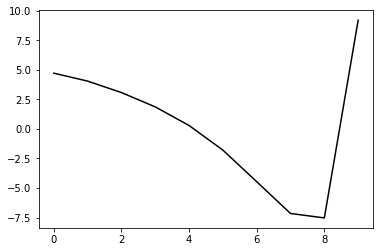

195800 0.39474776755237734
1.9616530680474717 0.714142161856687 -0.7022690052984499 0.5560761256542996
[ 4.74653082  4.01546399  3.03951755  1.82024214  0.23481404 -1.86250833
 -4.5601048  -7.30401187 -7.76682026  9.24760281]


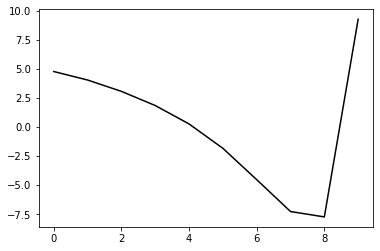

196900 0.31272779787051247
2.0420663818545832 0.7138171521285549 -0.7027907835861256 0.5671086188070658
[ 4.68022625  4.10890506  3.14626996  1.93649986  0.36279823 -1.72088702
 -4.40861862 -7.15960905 -7.55059666  9.15178847]


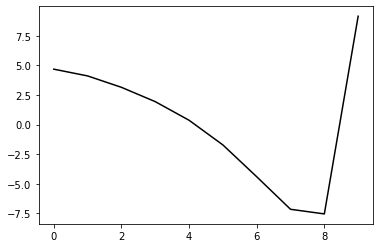

198000 0.3643837095624994
1.992803758389919 0.7277175319747431 -0.7320938575424606 0.5341794118940388
[ 4.87441041  3.88384064  2.92217498  1.70341486  0.11998459 -1.97522559
 -4.68539409 -7.49031906 -7.92317967  9.18929911]


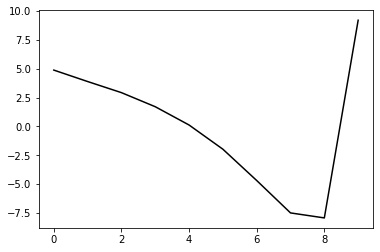

199100 0.3637499338203153
2.0245710012557843 0.7001976193217725 -0.7019983620277718 0.5762234298160075
[ 4.74327066  4.05409176  3.10576935  1.89293484  0.31532517 -1.77401864
 -4.4828367  -7.30007734 -7.71504364  9.1810475 ]


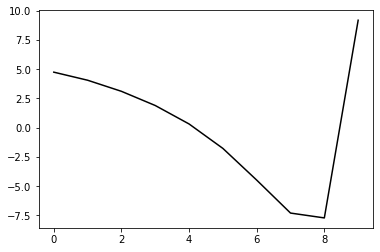

200200 0.30151705702643533
1.9773478116550984 0.6946826894112551 -0.7111350483390257 0.5648314860366787
[ 4.82165785  3.96210781  2.99487934  1.77120931  0.18107921 -1.923523
 -4.6582317  -7.52727579 -8.00750991  9.22623493]


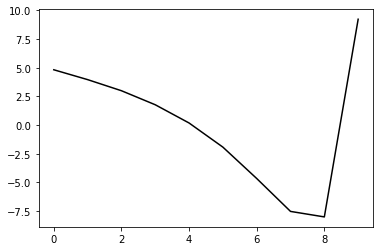

201300 0.2805525782724496
2.0041974858417353 0.7053862975444446 -0.7139038721992262 0.5737671175307038
[ 4.79272043  4.02613079  3.06695328  1.85281593  0.27134633 -1.82528172
 -4.55597037 -7.43376936 -7.87359906  9.12297161]


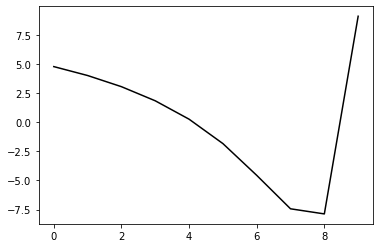

202400 0.4552321866003614
2.049427852044666 0.7307046937040756 -0.7463950174236843 0.5464521047211208
[ 4.99544335  3.85026232  2.89861245  1.69545966  0.12587707 -1.95787973
 -4.67790138 -7.55800574 -7.90442298  9.20968816]


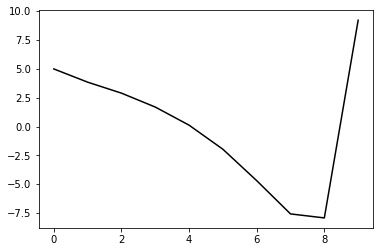

203500 0.3025734805133323
2.027823228959221 0.7028949359959397 -0.7236830687303485 0.5721726951003163
[ 4.83776494  4.01922288  3.05959495  1.84672226  0.26630073 -1.83200833
 -4.57767132 -7.50763854 -7.95210284  9.15159611]


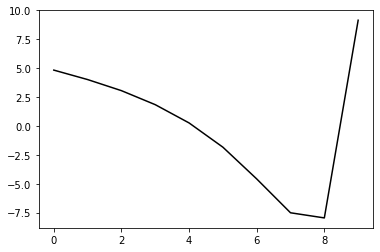

204600 0.31706158295747394
2.047910575375019 0.682845526022764 -0.7189991844875266 0.5792510439581751
[ 4.89980629  3.98168616  3.01150353  1.79992492  0.2232915  -1.87042111
 -4.61467293 -7.5567049  -7.95856907  9.20392236]


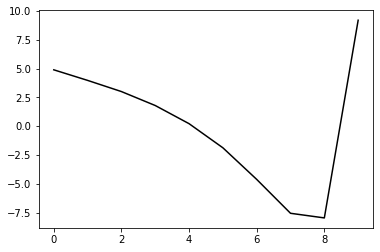

205700 0.4637821416254938
1.9806512057656087 0.7162197473339598 -0.7233336197988339 0.5818636304546128
[ 4.79182204  4.08175007  3.11695914  1.90971224  0.33403746 -1.76244747
 -4.51834602 -7.50944492 -8.03807059  9.07996814]


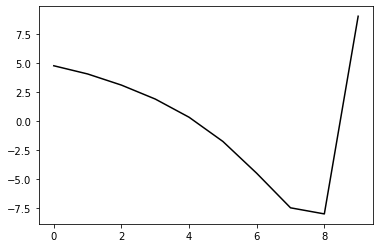

206800 0.4111023149977501
2.033848016221751 0.703530256738237 -0.7143934180769027 0.5964535141824536
[ 4.69358152  4.18253337  3.24276693  2.04866711  0.49176074 -1.5805262
 -4.30884705 -7.28932491 -7.71529721  9.19034691]


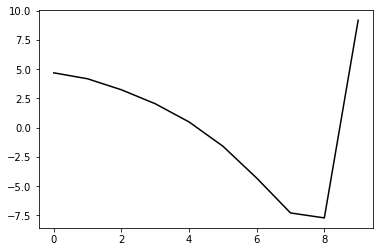

207900 0.32000620899617915
2.00301360241313 0.719487489969767 -0.7366208316055518 0.5777677891913843
[ 4.87910277  4.02552438  3.07342454  1.87173667  0.30561892 -1.77902401
 -4.52814328 -7.54750174 -8.00980647  9.18772591]


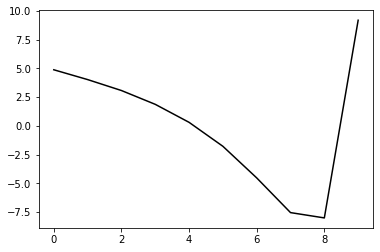

209000 0.32125399793141807
2.0148193157835954 0.7289522882443364 -0.7364463490897976 0.5860921438424102
[ 4.80675016  4.10193757  3.1611508   1.96540665  0.40387299 -1.67715862
 -4.42775099 -7.47260251 -7.94425382  9.25745649]


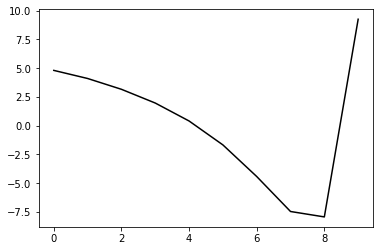

210100 0.39084313348039973
2.0490482375788375 0.7230487802446898 -0.745352903629916 0.5798171033189923
[ 4.88943198  4.0643194   3.12640759  1.93564089  0.37998684 -1.6952778
 -4.44379265 -7.49150294 -7.88880613  9.16234708]


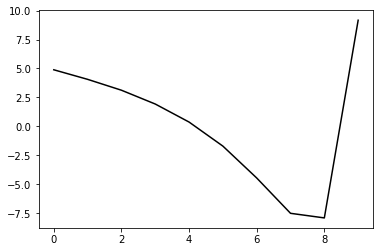

211200 0.30709120015745733
2.0324707095906165 0.6827040069799399 -0.7348600130520626 0.5825849555795497
[ 4.97018845  3.93187987  2.97972948  1.77655761  0.21321297 -1.86750843
 -4.6260898  -7.71156264 -8.14650682  9.1822497 ]


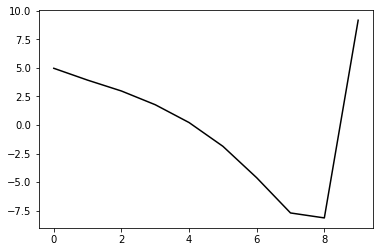

212300 0.27683311429480073
2.0475810132333923 0.6832672812228547 -0.7357830919816096 0.5884181569778508
[ 4.91408348  4.01729001  3.06237839  1.86441129  0.30617797 -1.76892672
 -4.52459791 -7.62668086 -8.03040717  9.13432225]


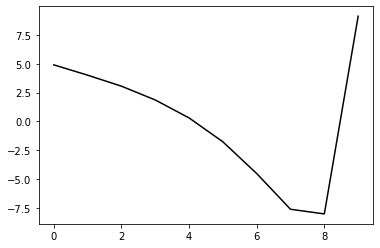

213400 0.4001718814973431
2.0550445642742976 0.677920400350754 -0.7330042277190484 0.5929267572587165
[ 4.8320149   4.08268109  3.12721662  1.93027821  0.37534545 -1.69602198
 -4.45368682 -7.59221671 -8.01467309  9.23824746]


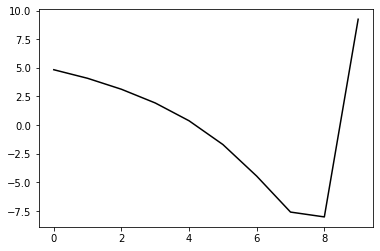

214500 0.3014589721992276
2.0639621770066934 0.6557256452948036 -0.7368579335714096 0.5872050332060039
[ 4.91242302  4.01195161  3.05304451  1.85179846  0.29548646 -1.77566556
 -4.53737319 -7.70514115 -8.12840302  9.10182971]


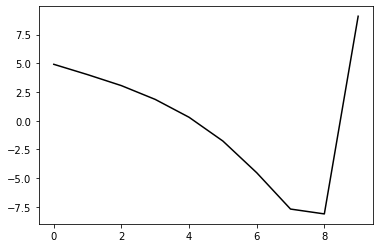

215600 0.31664860952982404
2.109350203072573 0.6350344606662871 -0.7372168638866418 0.5888265952799141
[ 4.94632467  3.98998589  3.01757369  1.82015753  0.271778   -1.78927083
 -4.54337933 -7.72252669 -8.07760721  9.21239204]


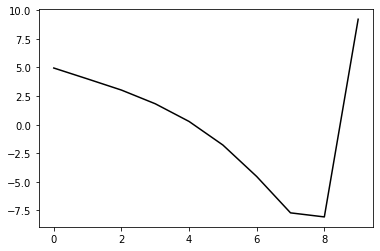

216700 0.45210962177722624
2.0961494126833973 0.6064955751240357 -0.7305270815578642 0.5944589456673137
[ 4.97310543  3.98957892  2.99141784  1.78500288  0.23100149 -1.83666808
 -4.60406262 -7.81195476 -8.18698306  9.16919565]


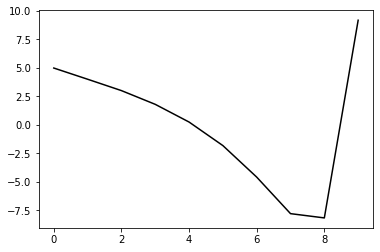

217800 0.3910669945426049
2.138064768380301 0.5702785870102632 -0.7162794608242105 0.6135415424277513
[ 4.88610403  4.11982808  3.11706721  1.90990104  0.3604274  -1.70114364
 -4.46450656 -7.68041673 -8.0272752   9.22167804]


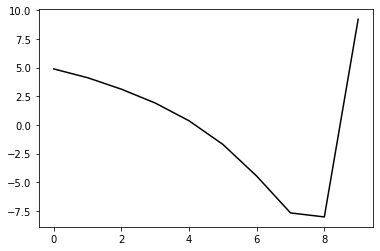

218900 0.3110544498333455
2.129966617819374 0.5870054372084532 -0.7366825696420296 0.593510085619084
[ 4.91896103  4.06003596  3.0427579   1.82903755  0.27728993 -1.78527639
 -4.55374778 -7.80154468 -8.15592274  9.19909744]


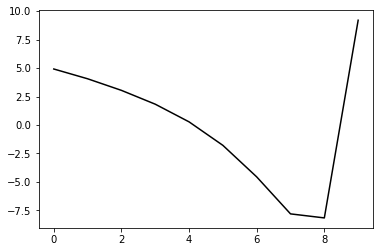

220000 0.3217274794665449
2.147120254520751 0.5598423961324704 -0.7301248671708817 0.6036195778055224
[ 4.91145143  4.10181322  3.0938788   1.87518114  0.32183421 -1.74180782
 -4.5160118  -7.78227226 -8.12407518  9.14084234]


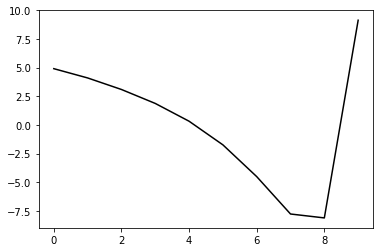

221100 0.3795861433690976
2.122946954521016 0.5166897975481819 -0.7078310892654999 0.6225641377024188
[ 4.82139461  4.16194008  3.15561658  1.92739995  0.36744721 -1.70020465
 -4.48123017 -7.78175007 -8.17810355  9.20117402]


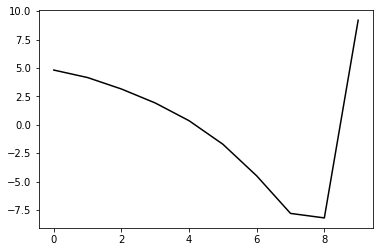

222200 0.3327310457990657
2.120436359183242 0.5613911885389153 -0.7413353897463549 0.5986733262191866
[ 4.87202437  4.11336694  3.10765471  1.8795319   0.31776697 -1.75095876
 -4.53649664 -7.87318506 -8.32596187  9.12973232]


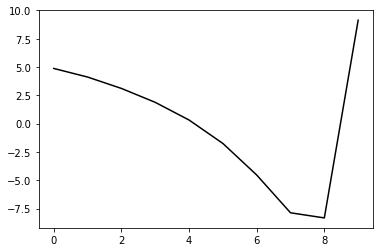

223300 0.2922312477689172
2.134194377985042 0.5618209533015812 -0.7553197989228787 0.587066165671262
[ 5.00929214  3.97927876  2.97613579  1.74980457  0.19146196 -1.87125794
 -4.65193698 -8.00088244 -8.36143746  9.15120446]


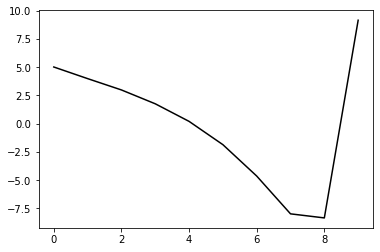

224400 0.3732864926653231
2.144255009876475 0.5707269145952834 -0.7563031433997963 0.5921267309455517
[ 4.99755976  3.99723329  3.00212328  1.78095731  0.22667063 -1.83141108
 -4.61061105 -7.98105959 -8.33418813  9.28123216]


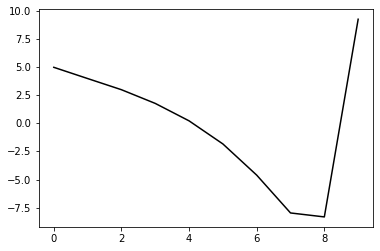

225500 0.3121498153617302
2.1045524079093956 0.5714155719054718 -0.7623050756524656 0.5845787870987692
[ 4.91410647  4.03772302  3.03347857  1.80102777  0.23475236 -1.83491421
 -4.63070191 -8.05144506 -8.5049424   9.14010702]


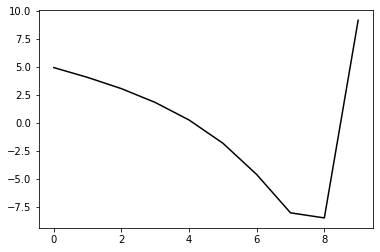

226600 0.327127987057939
2.079085499708118 0.5605233001216563 -0.7501316574066523 0.5969672597110824
[ 4.77178647  4.14523329  3.15635316  1.92178121  0.34979326 -1.72662049
 -4.53579592 -8.00388233 -8.52679481  9.1551444 ]


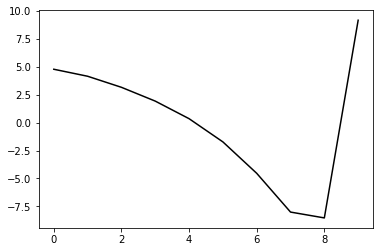

227700 0.44636728193366143
2.1217933908992443 0.5912150493133396 -0.76400150291657 0.5957270487440823
[ 4.76345434  4.16680853  3.21196828  1.99198493  0.42908863 -1.63677706
 -4.43419125 -7.92169042 -8.41989007  9.13340119]


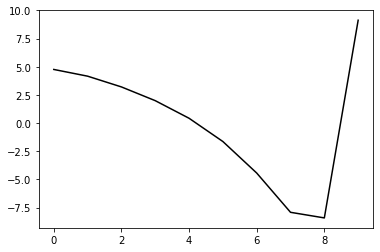

228800 0.4094958029368054
2.0856921877036707 0.5989403906516036 -0.7725024404159033 0.5871942427365482
[ 4.81487523  4.12731081  3.19903236  1.98587396  0.42092576 -1.64949863
 -4.45573533 -7.97097881 -8.49339513  9.14842582]


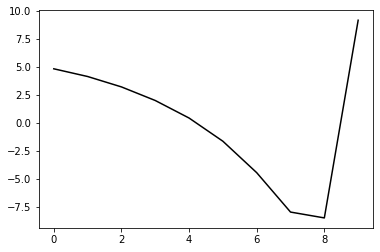

229900 0.30483455625521944
2.129723853040556 0.5992530929697154 -0.7649515149316817 0.6096159608026904
[ 4.79726458  4.21351349  3.32453193  2.12804003  0.57117701 -1.49575893
 -4.30519733 -7.82902713 -8.27737155  9.11535817]


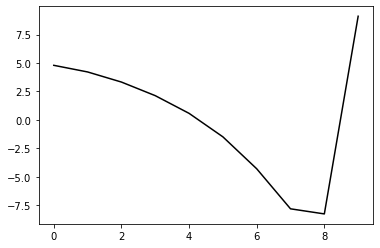

231000 0.3239698903302805
2.0999329014328314 0.5932184982277808 -0.7623248335156684 0.6110649428266071
[ 4.76541352  4.21455739  3.33148928  2.13600942  0.57279167 -1.50345469
 -4.32743749 -7.88858626 -8.39826586  9.19184458]


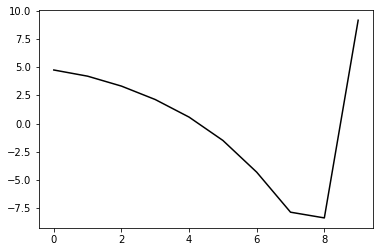

232100 0.35710178871504444
2.064745370977917 0.5847924961678643 -0.7577659307112583 0.6143837319328702
[ 4.73750162  4.2066385   3.32508314  2.13089034  0.5628194  -1.5204682
 -4.35456091 -7.95579072 -8.55905183  9.15097719]


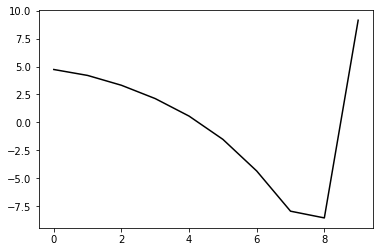

233200 0.300324163875308
2.067021854376277 0.5877711543218641 -0.770927816686415 0.6026890425889649
[ 4.8469104   4.10104962  3.23235601  2.04694388  0.48146149 -1.60283784
 -4.44271246 -8.07452664 -8.67385449  9.20393855]


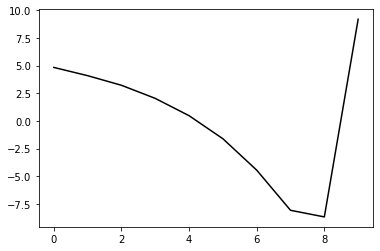

234300 0.27354035483465233
2.159535382902671 0.6130810627142398 -0.7861950251383816 0.6060258383073625
[ 4.89544842  4.15752602  3.32158306  2.16980306  0.63076544 -1.43091369
 -4.24754588 -7.85553254 -8.31407861  9.14346382]


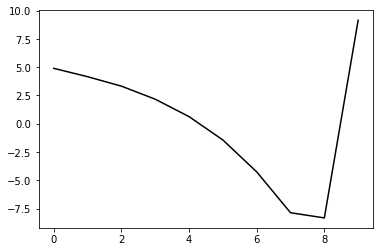

235400 0.399180284810157
2.056234108260776 0.5975044099621898 -0.775036477894687 0.6160280677333894
[ 4.85401202  4.1898079   3.32778103  2.16909258  0.61862395 -1.46104454
 -4.30641634 -7.96376043 -8.56412981  9.1557617 ]


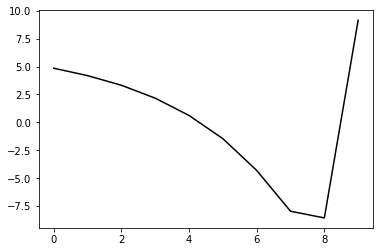

236500 0.3034495149457788
2.0665673710685555 0.6002946408197071 -0.7842095840640478 0.6088897854433691
[ 4.87301205  4.15399656  3.2831911   2.12846194  0.58200372 -1.49554968
 -4.34037654 -8.0197051  -8.63352853  9.26053996]


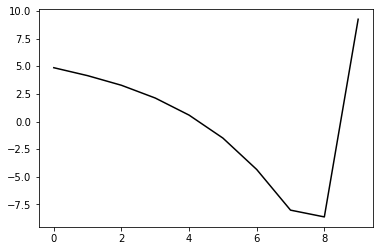

237600 0.3409835531901792
2.0431065176841146 0.5658696641470417 -0.7705491938243858 0.622708707582327
[ 4.85560911  4.1857239   3.29956672  2.14229721  0.59528318 -1.48597799
 -4.34089894 -8.05080089 -8.70135718  9.14509359]


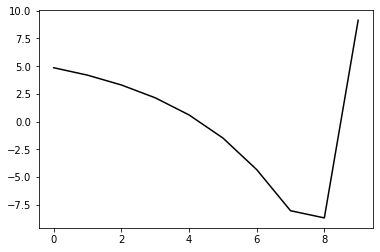

238700 0.5261853855462132
2.0357443165572238 0.5362858191115366 -0.7504597375712784 0.6447001103878528
[ 4.80947614  4.23736107  3.33694761  2.17756478  0.63200001 -1.44911683
 -4.30677167 -8.04614329 -8.76344682  9.13544833]


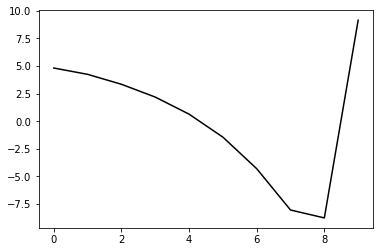

239800 0.4226170021417453
2.0271444362076974 0.588378221594647 -0.795331910056534 0.6052993302987715
[ 4.93777251  4.10349896  3.19639075  2.03990732  0.49966638 -1.57684075
 -4.42913498 -8.18886402 -8.91744634  9.1914651 ]


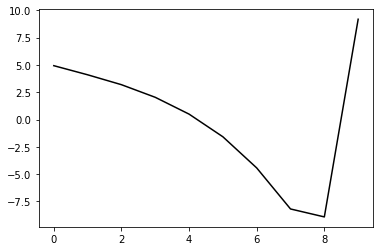

240900 0.31770135407447725
2.0549705049153757 0.6016303646847636 -0.7964916176889095 0.612456449527869
[ 4.88503153  4.17988669  3.30678005  2.16823205  0.64747119 -1.4100671
 -4.24237014 -8.01010664 -8.68723267  9.12268151]


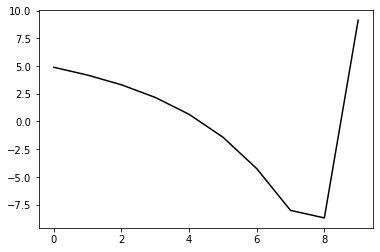

242000 0.3212613498918171
2.08056663405449 0.6049992730962934 -0.794777658226701 0.6237146145381243
[ 4.88662196  4.21208659  3.36432234  2.2348224   0.722142   -1.33109478
 -4.16793909 -7.96274817 -8.62212332  9.15362785]


243100 0.37825086739870234
2.0995815166028806 0.5875088631419171 -0.7972058493055036 0.6214740444161215
[ 4.93511844  4.18768414  3.33917869  2.21382827  0.70619035 -1.34274287
 -4.18042789 -7.9897189  -8.63007044  9.12028291]


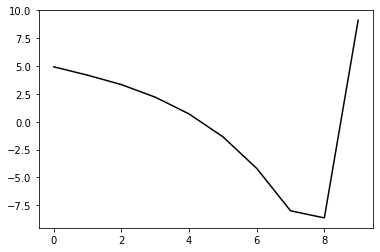

244200 0.3460153994427031
2.046204180349577 0.5931510319549177 -0.7887372947800045 0.6298126545055576
[ 4.7486904   4.32438548  3.4683451   2.34122133  0.82911529 -1.22673405
 -4.07719105 -7.93693655 -8.72842096  9.18240984]


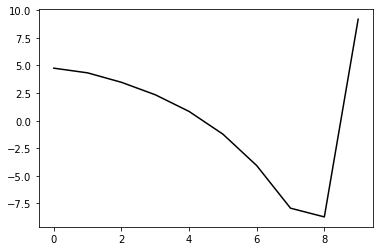

245300 0.27883672495496725
2.059625879553298 0.5928509321119192 -0.7967354283788168 0.6240912888822914
[ 4.81704093  4.27053856  3.41896904  2.29667989  0.79077352 -1.26042722
 -4.11285112 -7.99324628 -8.7436687   9.10147924]


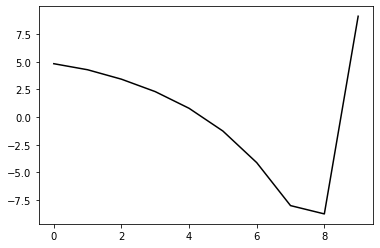

246400 0.3541860471315429
1.9880193110137774 0.6029317177533852 -0.8055113411622458 0.6124948551202777
[ 4.91400974  4.13304031  3.26882647  2.13836069  0.62408624 -1.43681824
 -4.30390747 -8.22988345 -9.13220804  9.1844834 ]


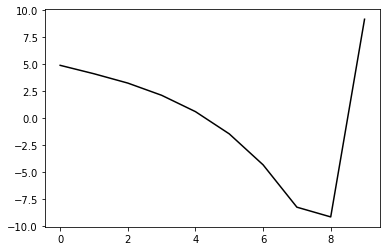

247500 0.31382589994915916
2.030361492916712 0.5670001785656315 -0.7989029517498754 0.6191060057157781
[ 4.9419488   4.1293917   3.27077564  2.14351656  0.63664054 -1.4152861
 -4.27571181 -8.21903812 -9.05255959  9.05844348]


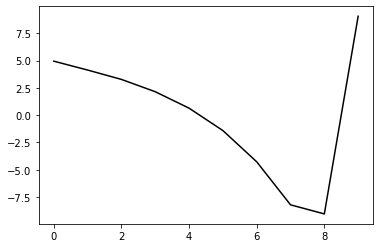

248600 0.3509061780315442
2.088549848124961 0.5408756123540904 -0.7844985331058161 0.6382234554061035
[ 4.87641658  4.21346992  3.35252853  2.2341576   0.73971913 -1.29835365
 -4.14540462 -8.09307596 -8.87681162  9.17182403]


249700 0.4652888294184392
1.9859425599609113 0.5601372031810866 -0.7885355533471667 0.6299662588911366
[ 4.80715187  4.20632423  3.33749232  2.208379    0.70212934 -1.35064149
 -4.22215267 -8.2446325  -9.20423014  9.11665977]


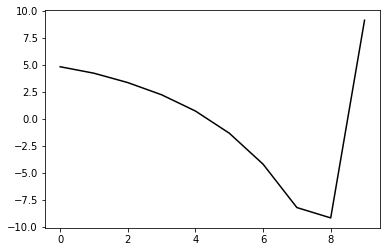

250800 0.3686196328182856
2.025401120906117 0.5423714729440842 -0.7830563909311964 0.640172045355555
[ 4.76157126  4.27517672  3.43868398  2.31973521  0.82461872 -1.21639146
 -4.0795318  -8.11813791 -9.0352813   9.18417269]


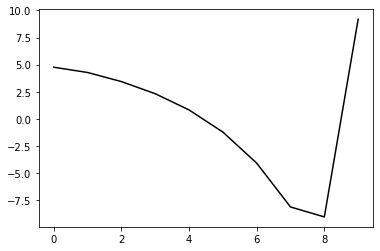

251900 0.3290338728534112
2.019905699501527 0.5427863525299852 -0.7928226321824254 0.6367801030555486
[ 4.86249728  4.23946822  3.39912085  2.28468255  0.79054933 -1.25163743
 -4.12241656 -8.18308199 -9.08353577  9.10753266]


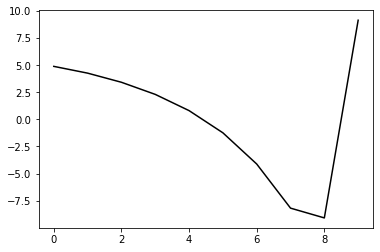

253000 0.32114656528920327
2.0199451660921968 0.5406744961073549 -0.8014880773295545 0.629280648170863
[ 4.88708407  4.20431976  3.35986359  2.24681868  0.75426893 -1.28582548
 -4.15596726 -8.24209612 -9.1758936   9.12035353]


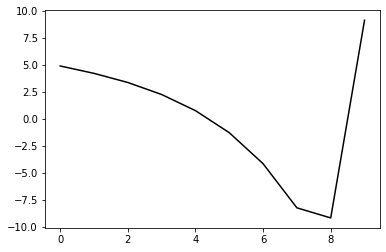

254100 0.3551604923611941
1.9879055515368294 0.5125725358226496 -0.7825111256908837 0.6449143970278769
[ 4.76293016  4.28915063  3.44617476  2.32798706  0.83062296 -1.2152372
 -4.09742168 -8.2323469  -9.27040719  9.04913467]


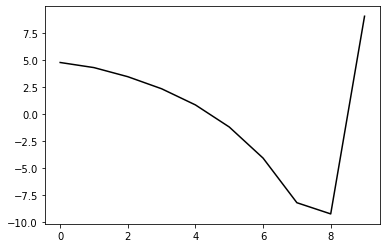

255200 0.3724515066184098
2.0376802707610233 0.5353984830897534 -0.7892886666972959 0.6566559913632456
[ 4.85763697  4.28757389  3.46259826  2.36472515  0.88535851 -1.1441401
 -4.01216193 -8.15003971 -9.10059442  9.11517713]


256300 0.28444629532914695
2.005100501615034 0.5460894750952691 -0.8161033754154771 0.6258876945391335
[ 4.95387389  4.16220522  3.32146484  2.21897983  0.73640215 -1.2959898
 -4.16951837 -8.33538037 -9.34256399  9.10619521]


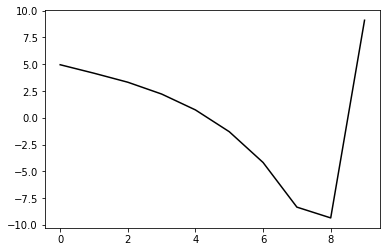

257400 0.4267368349762861
2.0482274783080308 0.577115954896256 -0.839130661595302 0.6143766106715618
[ 5.11125917  4.04515872  3.21532317  2.1304441   0.66593849 -1.34946696
 -4.20794219 -8.37155826 -9.2776019   9.07890999]


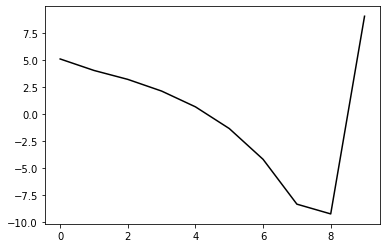

258500 0.35401414360961775
2.09500672429162 0.5868899962326224 -0.8415430171830038 0.6260754637542888
[ 5.06220722  4.15246864  3.31562178  2.23886958  0.78337249 -1.22570786
 -4.08598204 -8.2691962  -9.11244953  9.11628601]


259600 0.35558669377768565
2.035062348562078 0.5154512110507039 -0.7937396787177375 0.6634611574151624
[ 4.88482996  4.28876734  3.43084379  2.33687111  0.87034857 -1.14911139
 -4.0262443  -8.25444554 -9.23729975  9.20435544]


260700 0.5395759380196592
2.047754328911348 0.5016179775543478 -0.785575521868152 0.6777538879421342
[ 4.86414613  4.34239422  3.47470808  2.38021986  0.91842953 -1.09450828
 -3.96596683 -8.20520061 -9.22491985  9.12350784]


261800 0.3835033305315126
2.042236544582694 0.5408579889859603 -0.8132833478567738 0.6591588710219154
[ 4.93906643  4.28478999  3.4193169   2.32541246  0.86572348 -1.14594415
 -4.02072992 -8.28472176 -9.31980769  9.12453855]


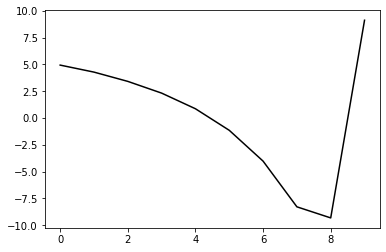

262900 0.3281285606039905
2.035056343976626 0.5226225869209686 -0.8139546293478842 0.655526805698889
[ 4.98328873  4.22710391  3.35281469  2.25109607  0.78903583 -1.221929
 -4.09696617 -8.38583263 -9.42405541  9.04413952]


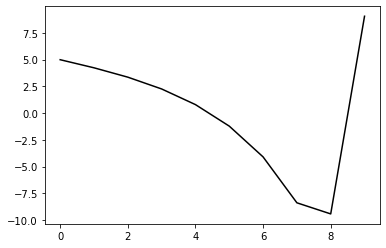

264000 0.3246353931510153
2.037706976731567 0.5253955666445989 -0.8228972227538239 0.6503269928709253
[ 5.01644591  4.19529877  3.31609369  2.21147381  0.75063921 -1.25487873
 -4.11870769 -8.39768456 -9.50693645  9.16097289]


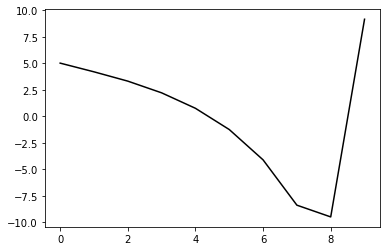

265100 0.4183310249314911
2.098144876740859 0.5378116200381811 -0.8126655680210165 0.6785764956647492
[ 4.79496829  4.48749401  3.63765245  2.5576765   1.12299014 -0.8510714
 -3.6666506  -7.85845585 -9.02225013  9.0996734 ]


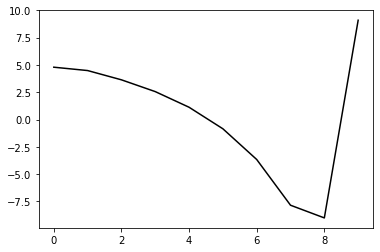

266200 0.3418711850733068
2.080128672328865 0.5455460967661119 -0.824657173418231 0.671001515894644
[ 5.00141713  4.31300255  3.46624409  2.38195553  0.94157166 -1.0431745
 -3.88898041 -8.15450927 -9.27847294  9.15389043]


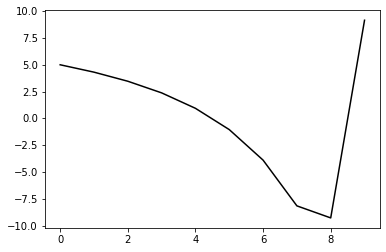

267300 0.2920356381249965
2.08551657331173 0.5628112864642907 -0.849869831520288 0.6469172786426598
[ 5.04911383  4.25556716  3.3977014   2.31399256  0.87651603 -1.1033154
 -3.94446687 -8.21317768 -9.35783738  9.07196974]


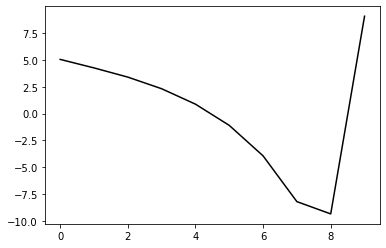

268400 0.5257449742110513
2.099164161325505 0.5905118889918703 -0.8763931149293597 0.6254041406894246
[ 5.25292676  4.05686706  3.21080798  2.13608021  0.70864592 -1.25929645
 -4.08755367 -8.34987559 -9.42801348  9.16103705]


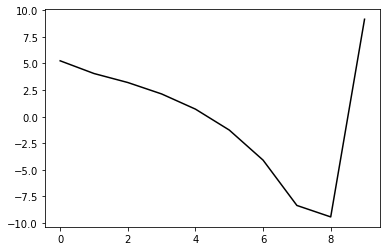

269500 0.30998624315876977
2.044965494121023 0.570552532463973 -0.8505449649969015 0.6573554590279393
[ 5.04001225  4.2823137   3.41823898  2.33433697  0.89673631 -1.08437153
 -3.93843045 -8.27082156 -9.46921463  9.05287932]


270600 0.34805921418278796
2.0546539389851737 0.5492371955098972 -0.8286686181479267 0.6846317733215722
[ 4.91418261  4.42021622  3.55480306  2.47388277  1.04128815 -0.93458794
 -3.78748368 -8.14239986 -9.31409111  9.16650281]


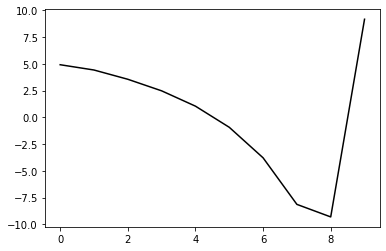

271700 0.44189399314081135
2.1062825072632667 0.5681899527810038 -0.8549645472381524 0.6669059655301249
[ 5.16730522  4.22411826  3.36471451  2.29262229  0.87189745 -1.09093782
 -3.93204769 -8.28473268 -9.33727243  9.08115914]


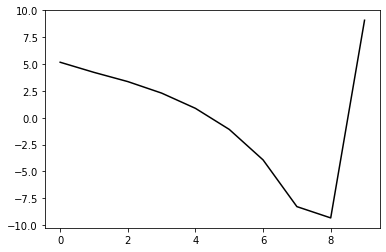

272800 0.3944477579953227
1.9830873115415366 0.553633578153317 -0.8369037338748796 0.6804549627071967
[ 5.05339036  4.27328019  3.39018126  2.29455072  0.85150191 -1.13460464
 -4.00851198 -8.4503585  -9.74698491  9.12006599]


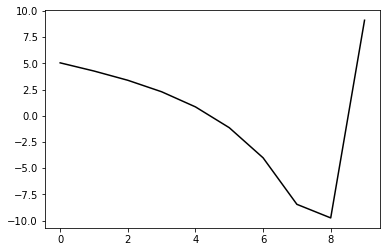

273900 0.3127684624357906
2.0760466854076505 0.5640410266602468 -0.8503519048706378 0.6788861894421461
[ 5.08526316  4.31569046  3.44633773  2.366738    0.94226502 -1.02345327
 -3.87456497 -8.29928554 -9.43930317  9.08004244]


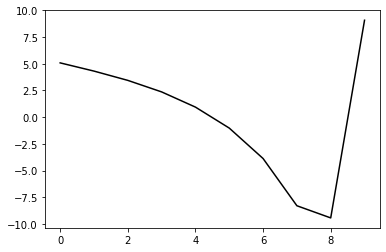

275000 0.320479164194017
2.101256237540022 0.5732679667508875 -0.8683012648740214 0.663177735790816
[ 5.21542866  4.18232664  3.31757294  2.24118641  0.82347233 -1.1327432
 -3.973235   -8.38375282 -9.50240289  9.17460568]


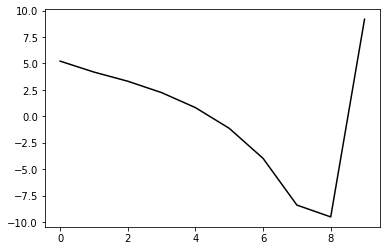

276100 0.3665755832054667
2.0828006443130627 0.5358975654807688 -0.8407192636830504 0.6889375198582199
[ 5.00115576  4.39418291  3.51601466  2.42832671  1.00196959 -0.96174622
 -3.81566638 -8.27828129 -9.46330515  9.0957196 ]


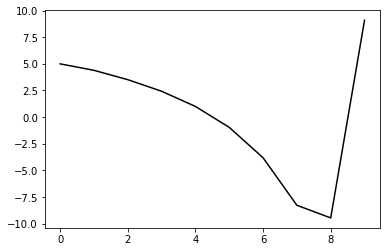

277200 0.30332535654974213
2.1098815571710925 0.539395871104327 -0.8539371135688955 0.678151660954733
[ 5.14033161  4.25742912  3.37887696  2.29217159  0.87093534 -1.08425224
 -3.92791989 -8.38030326 -9.55189595  9.12104733]


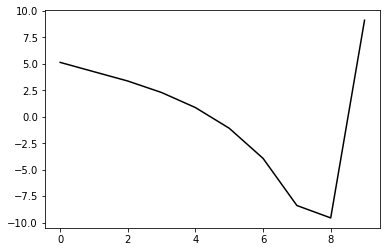

278300 0.2857042304253834
2.108515344323606 0.5499166166219575 -0.863108758538017 0.6758342734222014
[ 5.17350785  4.27475971  3.39827781  2.31480464  0.89657247 -1.05679691
 -3.90626682 -8.40553827 -9.53352539  9.0510109 ]


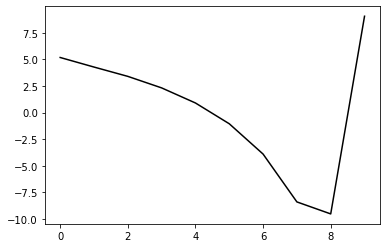

279400 0.3790495821540023
1.9971399571420008 0.5427405359809189 -0.8555209968935515 0.6733430232267507
[ 4.98904366  4.33414439  3.43653216  2.32959207  0.88962844 -1.08305331
 -3.95285954 -8.48490553 -9.83980248  9.09581413]


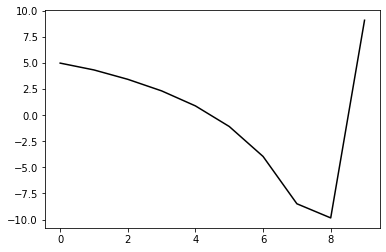

280500 0.32029367887042104
2.0261193625926066 0.5568957093630417 -0.8691065591108417 0.6665096159288836
[ 5.09310927  4.25166575  3.37261143  2.27581105  0.8470767  -1.11035527
 -3.95687458 -8.43073055 -9.77794415  9.09166604]


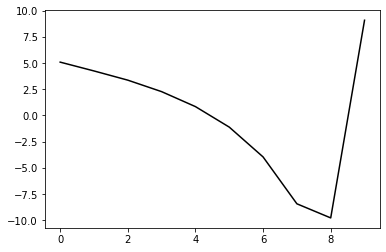

281600 0.348418728176825
2.0733591644969502 0.5220617085566348 -0.8513444947285241 0.6924200757714315
[ 5.03488529  4.39156038  3.52170848  2.4274639   1.00099604 -0.95539937
 -3.81347438 -8.41059858 -9.61156698  9.18750357]


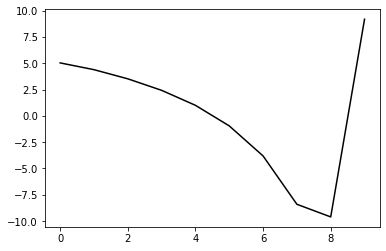

282700 0.4747013924373051
2.0027693650317984 0.5034182994436408 -0.8420545244402048 0.6931836858474079
[ 4.95006422  4.40313492  3.51294756  2.40735398  0.96995808 -0.99568036
 -3.86554563 -8.51406368 -9.83218827  9.05651978]


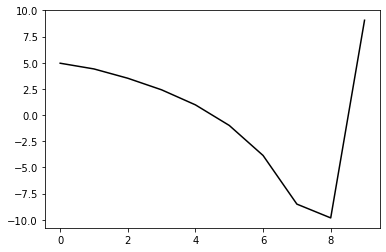

283800 0.3672720622287194
2.0865402309245504 0.4795489740297126 -0.8438260130918672 0.6980642094654717
[ 5.02903823  4.37169466  3.48946817  2.39280261  0.96879428 -0.97760002
 -3.81846944 -8.39332973 -9.67311633  9.11561333]


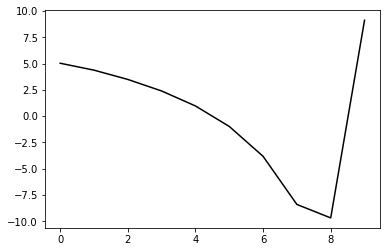

284900 0.30625326642775874
2.1501068509749564 0.4826081567206029 -0.8531452710185563 0.6991095625514906
[ 5.06646559  4.41810749  3.52436209  2.43997267  1.03049192 -0.89935224
 -3.71995893 -8.22315247 -9.51648656  9.09829273]


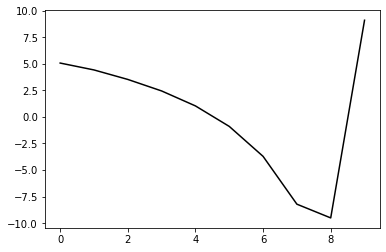

286000 0.32710897572897735
2.160180977460322 0.4433927470433821 -0.8511422913981359 0.6978505167242194
[ 5.19387764  4.2927174   3.37913798  2.2843366   0.87336391 -1.0541062
 -3.87270658 -8.3830951  -9.68014068  9.13262212]


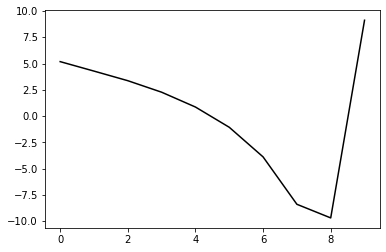

287100 0.37112460317743184
2.134303479556246 0.44589079660114245 -0.8416217403909564 0.7141571935615199
[ 5.06906126  4.42958569  3.50994778  2.41511387  1.00613406 -0.91782804
 -3.73053092 -8.24371775 -9.58786558  9.05070258]


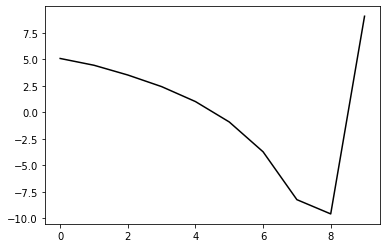

288200 0.34364034419460265
2.164755722646286 0.45358113708334913 -0.8566728390013361 0.7040004199424476
[ 5.12665021  4.35931102  3.4259377   2.32511589  0.9152719  -1.00748272
 -3.82117978 -8.36256495 -9.67094072  9.1064631 ]


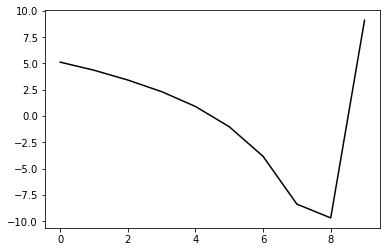

289300 0.274164163336511
2.170654115667036 0.47402487771603874 -0.870052964020346 0.6989284883904718
[ 5.17509788  4.34911899  3.42257428  2.32261977  0.91651756 -1.00119151
 -3.81088646 -8.36097879 -9.64170964  9.08681742]


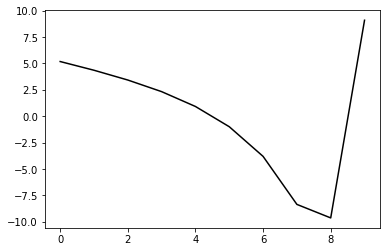

290400 0.43691139192178513
2.1229076217676677 0.4906954621172474 -0.8940664350696269 0.667637602845774
[ 5.2278506   4.18898846  3.24718901  2.13257549  0.71742696 -1.20156799
 -3.99736232 -8.40815818 -9.96678616  9.15682511]


291500 0.29305882316324866
2.1311968136537156 0.46041829603807444 -0.8597200826024956 0.7072343822272791
[ 4.93374074  4.47804217  3.56901679  2.45397506  1.03764836 -0.88163649
 -3.68412353 -8.21686377 -9.74494097  9.07437492]


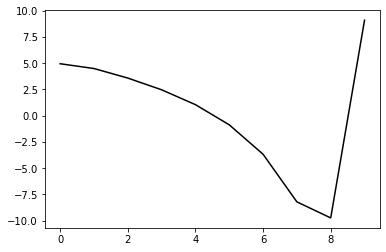

292600 0.359554726835122
2.126878639495587 0.46157657837987254 -0.8532142001114543 0.7207746735049737
[ 4.92728177  4.52790376  3.64287048  2.53775551  1.12401153 -0.79559546
 -3.61112233 -8.24673305 -9.68145408  9.09635721]


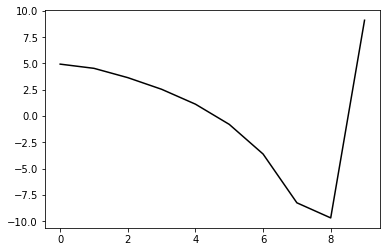

293700 0.5201771674069484
2.095224619829335 0.4553526044574025 -0.8512648826921727 0.7255985013870107
[ 4.98096334  4.47473599  3.58903603  2.48224533  1.06440826 -0.8586831
 -3.68002085 -8.35261546 -9.8151603   9.01749582]


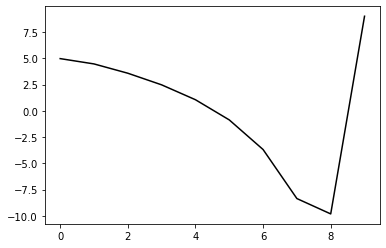

294800 0.3843251769396667
2.1394206602562518 0.4808381533408521 -0.8788804443102207 0.7073774905162942
[ 5.09137392  4.39965541  3.53078373  2.4340872   1.02423854 -0.88945604
 -3.69855173 -8.32958085 -9.76865775  9.08840947]


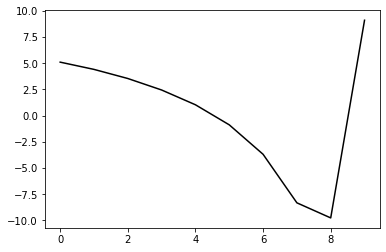

295900 0.307065536016238
2.164170931470766 0.47979897009193245 -0.875391636946874 0.7168463340476979
[ 5.06125749  4.45955228  3.59208078  2.50665668  1.10605304 -0.79751291
 -3.5934009  -8.18336819 -9.63249598  9.10474216]


297000 0.3218376455270181
2.0861467108831797 0.4840957801976328 -0.8832126456419201 0.7036516957621644
[  5.11547088   4.34771833   3.46198238   2.3615586    0.94482545
  -0.97484348  -3.79017909  -8.4663676  -10.01411534   9.0824885 ]


298100 0.3582313513416449
2.0754275370920556 0.4761891217592408 -0.87513726741871 0.7118202447861631
[  5.02507031   4.39668305   3.52332914   2.42295179   1.00539445
  -0.91355269  -3.72329343  -8.3144208  -10.01933      9.08617974]


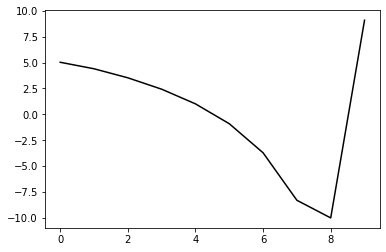

299200 0.3817277609930697
2.093603832845675 0.4657996286871015 -0.8647544587530664 0.7277689765700878
[ 4.99832856  4.45131162  3.59174942  2.496892    1.08188416 -0.83491902
 -3.64154927 -8.50270201 -9.91983899  9.06165735]


300300 0.3449225809859042
2.081052183318518 0.5086619849395875 -0.9132061173635643 0.6813736430103129
[  5.18380101   4.26061675   3.39041133   2.29903999   0.88498536
  -1.03101962  -3.83804528  -8.50563622 -10.13773002   9.06959386]


301400 0.36207459587693486
2.064492817590908 0.483497923425673 -0.8932065588796038 0.7016524185213174
[  5.14037887   4.29378075   3.4230978    2.32811006   0.91095153
  -1.00711807  -3.8153312   -8.25405216 -10.17907483   9.17119256]


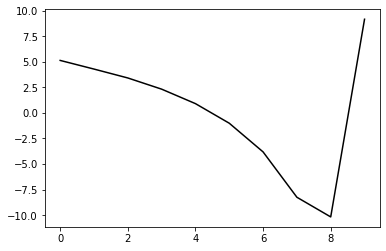

302500 0.31291318550997166
2.078204616438166 0.4714646881379139 -0.8990757836896657 0.696048988988646
[  5.11245786   4.32552231   3.4460809    2.35193053   0.93691636
  -0.97832419  -3.78201044  -8.31871797 -10.13881906   9.06406342]


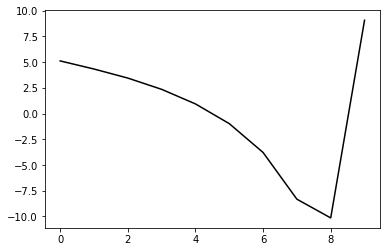

303600 0.3497081277561433
2.0528571677657816 0.4739885698379435 -0.8738185524200563 0.730686748909855
[ 4.96164172  4.49203555  3.62345239  2.54082268  1.13338318 -0.77727159
 -3.57728101 -8.48270259 -9.93676606  9.1301679 ]


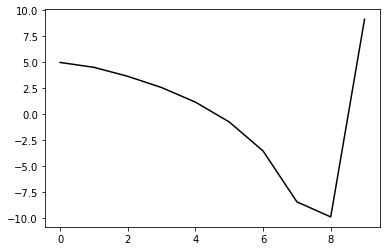

304700 0.45872451982835105
2.017877172435882 0.48795721958207344 -0.8891910137117504 0.7184747985355571
[  5.08761747   4.35847572   3.48680335   2.39747812   0.98327252
  -0.93537852  -3.7525888   -8.62577303 -10.1711221    9.05909536]


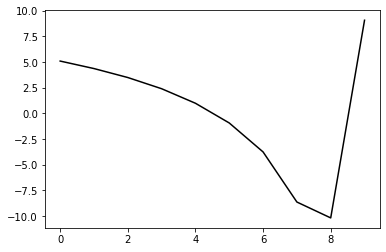

305800 0.3959778210235709
2.079369857344755 0.49401681711359424 -0.8990270929699928 0.7167388962778664
[ 5.09369166  4.39172548  3.53599218  2.46058856  1.06083432 -0.84284434
 -3.64406663 -8.42722626 -9.94311122  9.08222135]


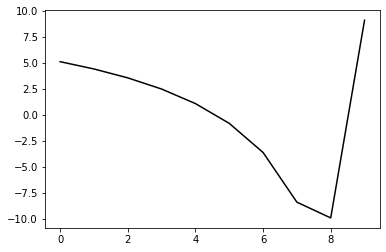

306900 0.3258166997863341
2.065197896490929 0.5103410069556195 -0.9123532847572258 0.7077808226953507
[  5.1719925    4.32028887   3.47080893   2.39706954   0.9975711
  -0.9077734   -3.71811613  -8.60193202 -10.04604262   8.99687355]


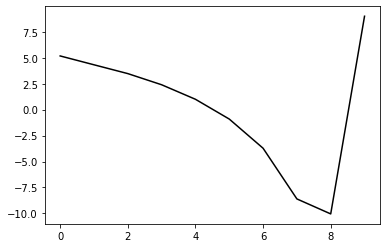

308000 0.323856848070908
2.1313596453906065 0.4923396323300866 -0.899889438894454 0.7289727776343897
[ 5.11031707  4.43044075  3.58385515  2.52301547  1.13863477 -0.74937706
 -3.53125394 -8.0043754  -9.76456364  9.12234673]


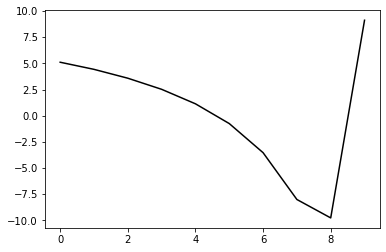

309100 0.4050145383842639
2.087073782633686 0.4692773364754398 -0.882403397104775 0.7400663134367577
[ 4.83994409  4.61722742  3.76392885  2.6925907   1.29772341 -0.60277283
 -3.40153555 -8.20064891 -9.80033381  9.07177122]


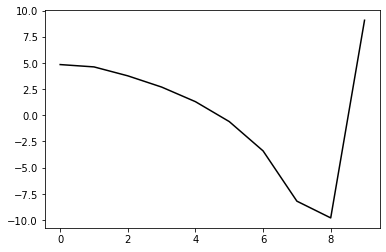

310200 0.34819347090102065
2.082768755589822 0.502318749278451 -0.9227682490170852 0.7039835791000297
[  5.20471965   4.28145349   3.44251506   2.37246284   0.97806399
  -0.92210824  -3.72561251  -8.4587418  -10.09578225   9.12561302]


311300 0.2939857575389449
2.0521206410596817 0.47371298971799625 -0.8937194670969724 0.7341637280590914
[ 5.01261695  4.47601086  3.6461223   2.57599045  1.17912474 -0.72324002
 -3.52622382 -8.19059156 -9.97447606  9.01892872]


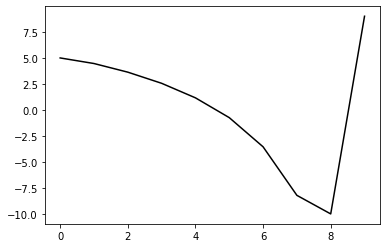

312400 0.4401665055874546
2.0329433128703527 0.5097968850027746 -0.9360590534186267 0.6898028189112884
[  5.24566185   4.18541044   3.34149487   2.26834478   0.86785169
  -1.0365808   -3.83367121  -7.91696745 -10.33953737   9.09343138]


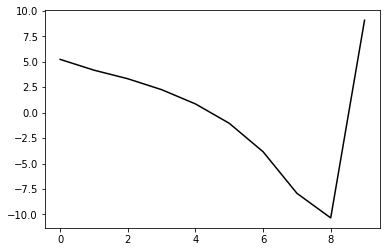

313500 0.2934480268731556
2.068833120460348 0.4948451151873647 -0.9136695662393649 0.7245462830657752
[ 5.10320855  4.39960488  3.56656998  2.50453116  1.11259337 -0.7883468
 -3.59859077 -8.34039144 -9.97417054  9.05658418]


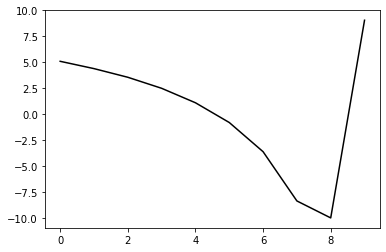

314600 0.34821690202469685
2.0513413841305295 0.4612196736561001 -0.892140197562563 0.7414053180331673
[ 4.95525171  4.4883909   3.64479426  2.57811273  1.18426935 -0.71653215
 -3.51645639 -8.13711777 -9.97380198  9.12240925]


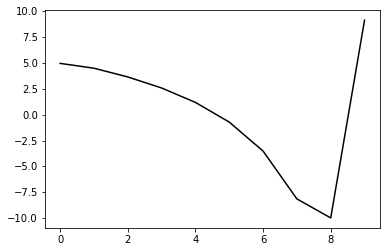

315700 0.4642064241612674
2.0300030001078184 0.48335948169371934 -0.9239478144253408 0.7082267275270935
[  5.11694878   4.31552882   3.45592211   2.38225366   0.98251154
  -0.9245488   -3.72932136  -8.25348313 -10.24463317   9.02356436]


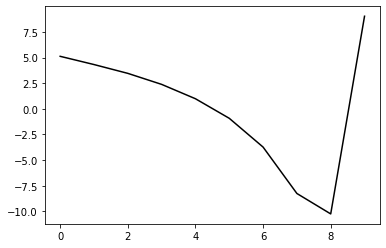

316800 0.3693922051337387
2.062635367897735 0.4587069723067529 -0.8987940557441713 0.7415633999650304
[ 5.03260024  4.46990919  3.63461844  2.57180275  1.18177516 -0.71769773
 -3.52534215 -8.55156685 -9.98459948  9.11151823]


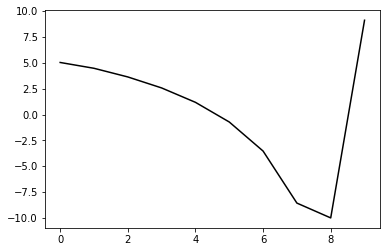

317900 0.32638030390422074
1.9879524978965342 0.47166149022505605 -0.9027563793786969 0.7363065228384128
[  5.04772907   4.4188197    3.5736767    2.50558503   1.10738741
  -0.80170944  -3.62559166  -8.54949253 -10.19653052   9.06199731]


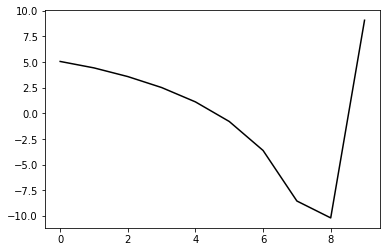

319000 0.3206863825781448
1.9778946636312715 0.4876438401701414 -0.9140702358750974 0.7361242656131141
[  5.08261722   4.42262931   3.58828283   2.52415196   1.12787582
  -0.7824919   -3.62304929  -8.87734593 -10.11334102   9.10370443]


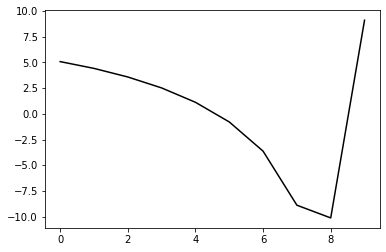

320100 0.40090302342674433
1.9731184158097892 0.5153090281472741 -0.9363102432226956 0.7174961115322315
[  5.10563527   4.38974293   3.55368816   2.49349083   1.09999528
  -0.80798546  -3.64804283  -8.72826151 -10.1098349    9.02041615]


321200 0.31036834816205033
1.9935085854488486 0.5105134238496164 -0.9253980782069495 0.7341210410531371
[ 5.0317758   4.44674575  3.63083371  2.57895758  1.19330018 -0.706687
 -3.53409855 -8.47583842 -9.98649471  9.12430376]


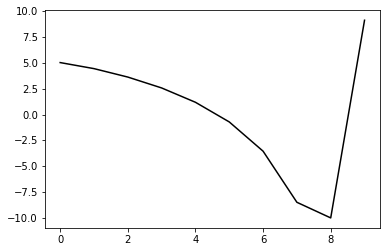

322300 0.2841534434382193
1.9767402155116909 0.5147563302450108 -0.9329613626368011 0.7293956125128278
[  5.13170946   4.3759669    3.55557448   2.50641596   1.1222805
  -0.77874875  -3.61930388  -8.75644751 -10.05480856   9.06574986]


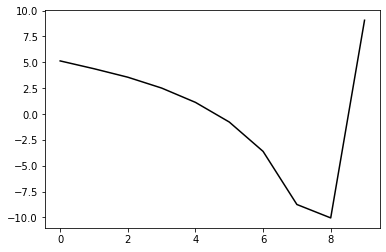

323400 0.3757538005677757
1.9228438398831869 0.5052403729805962 -0.9348019744007712 0.7197674063058078
[  5.16541521   4.2566153    3.43243679   2.37408093   0.98332673
  -0.92094169  -3.75378464  -8.16193067 -10.32405746   9.09362386]


324500 0.31645784861346665
1.9187840993617182 0.47584563453951995 -0.9254262122944654 0.7252105608873715
[  5.0949654    4.30539105   3.47159345   2.40920601   1.0154374
  -0.89326963  -3.73583498  -8.26063297 -10.28994159   9.13561975]


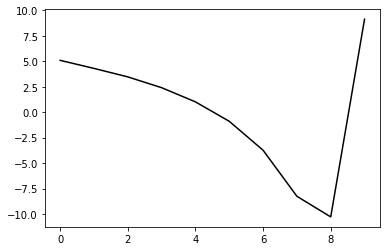

325600 0.35057623899678236
1.9510984568514753 0.48106537388221327 -0.9160322016469791 0.74504544229073
[  5.0067622    4.44612705   3.61715302   2.5717857    1.19173334
  -0.70674512  -3.53541663  -8.43440651 -10.02148975   9.09800451]


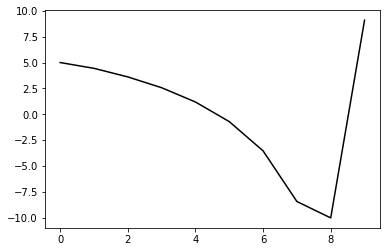

326700 0.4702588790223373
1.9579944014375579 0.46017672105848717 -0.9120336482488601 0.7496258119973106
[  5.1033308    4.36962384   3.5224457    2.47040171   1.08822239
  -0.81238167  -3.64531889  -8.53554698 -10.13445859   9.07883312]


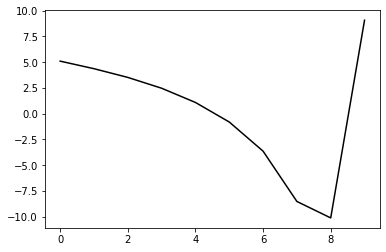

327800 0.3740553867799302
1.9496345945721194 0.4632795084779101 -0.9098180770085498 0.7553652839564977
[  5.02914486   4.44579163   3.60948163   2.55998574   1.18195915
  -0.71487283  -3.54450712  -8.46430356 -10.03645007   9.08490096]


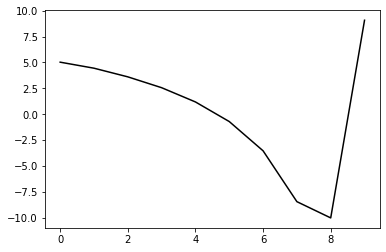

328900 0.3193665815333639
1.9860504878886478 0.44860711234984957 -0.9114056271459743 0.755527591611625
[ 5.06014952  4.43395138  3.59563428  2.54988157  1.17976152 -0.70766653
 -3.52561028 -8.42549091 -9.95820693  9.08328979]


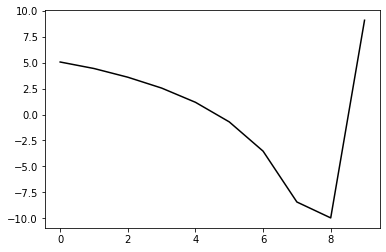

330000 0.32133869813173405
1.9716482602890468 0.4653845666742378 -0.9229038215933674 0.746229944682945
[  5.06455561   4.38947972   3.54447496   2.49492086   1.12181454
  -0.76961278  -3.59387804  -8.45820415 -10.04122308   9.10173475]


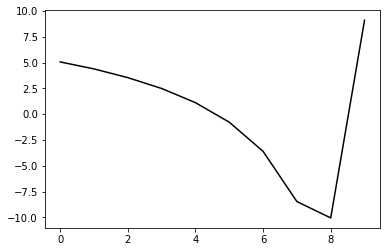

331100 0.3630494571596699
2.004958167795218 0.4590915081350513 -0.9303909160274277 0.7430344733954638
[ 5.10278074  4.38788477  3.54290434  2.49924342  1.13552427 -0.74434246
 -3.55231792 -8.38782469 -9.97572312  9.07409184]


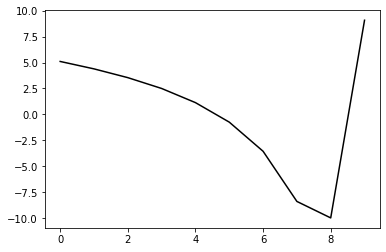

332200 0.3125374570225433
1.9660819713824655 0.4444080608075014 -0.9238973636819504 0.7467996204428966
[  5.1434281    4.31553435   3.45128215   2.39491094   1.02115625
  -0.86759819  -3.68546177  -8.36519244 -10.17450014   9.15575901]


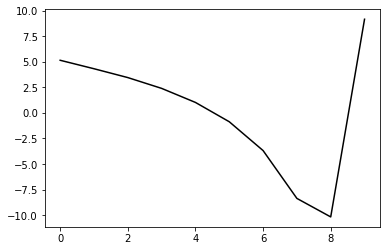

333300 0.2775778993297625
1.9939094770244346 0.4517408782313717 -0.9299399993235533 0.7486578917640403
[  5.15511699   4.34008112   3.47751072   2.42767141   1.06281842
  -0.8164911   -3.62193512  -8.35061079 -10.03610712   9.07253001]


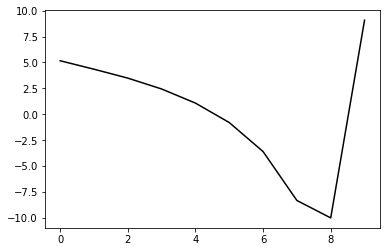

334400 0.3695085161584514
1.9719382588600813 0.44470647204231095 -0.9418594849177939 0.7302256204038962
[  5.21261851   4.20992476   3.32303963   2.25961946   0.88941162
  -0.98829122  -3.76984448  -7.84907699 -10.29099239   9.08332328]


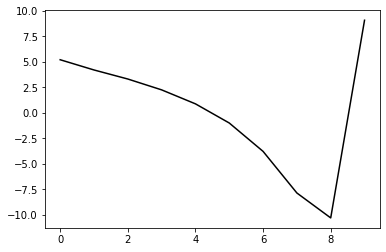

335500 0.28162489918178274
1.974785806021914 0.4200463099798964 -0.9257254878612797 0.7465392925008374
[  5.03917771   4.36825037   3.48214002   2.40844082   1.03175557
  -0.84982287  -3.62870252  -7.95978367 -10.20199148   9.02312956]


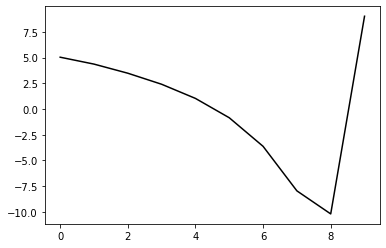

336600 0.3462188821586235
1.9586381901829575 0.44158115198164744 -0.9260441321128176 0.7532199343686026
[  4.98178762   4.41914658   3.55006442   2.48253278   1.10882475
  -0.76852546  -3.52668043  -7.94193784 -10.08685828   9.14362895]


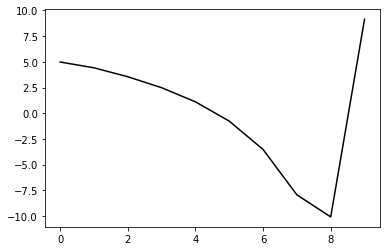

337700 0.4627924270586227
1.9036247988848445 0.4416865401978972 -0.9423468377147013 0.7281874620455676
[  5.0055821    4.31435524   3.41957934   2.32908962   0.9335132
  -0.96128277  -3.7250929   -7.75359456 -10.45407296   9.02487776]


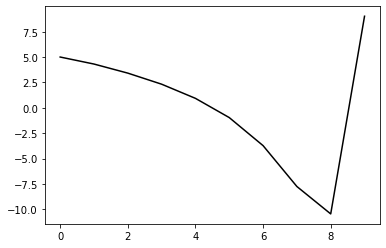

338800 0.3973959936573483
1.9591289137873031 0.4758684040906692 -0.9530381251193532 0.7351974068003277
[  5.03658718   4.37261499   3.52837725   2.46687922   1.09429916
  -0.77917631  -3.51983337  -8.00415462 -10.08414318   9.09906672]


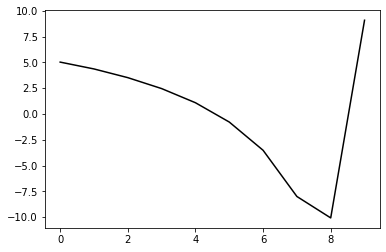

339900 0.31927924388431894
1.941550794694857 0.4672941765526173 -0.9365648630235456 0.7562007067354402
[  4.95559383   4.45043337   3.62579111   2.56694115   1.19320016
  -0.68097382  -3.42616172  -8.0853366  -10.01204259   9.07778366]


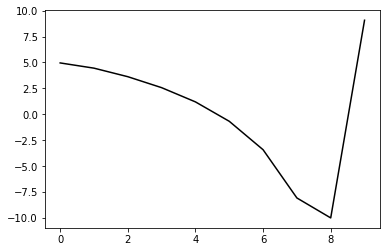

341000 0.31813543111033443
1.891109955333223 0.4615442329148488 -0.936610184188115 0.7514157983858997
[  4.92260794   4.39619456   3.5838661    2.51395176   1.12412366
  -0.7656236   -3.53101943  -8.01534715 -10.19604961   9.14877919]


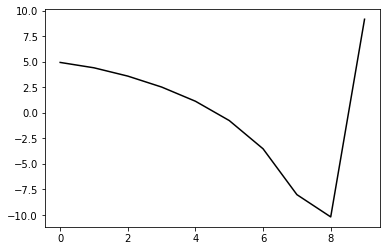

342100 0.35870337137057795
1.9414848276499275 0.45627436164692403 -0.9396832820238684 0.7567109773927839
[  5.00503211   4.36859356   3.57174434   2.51806306   1.13930454
  -0.74021713  -3.50048321  -8.12774791 -10.06526029   9.07589116]


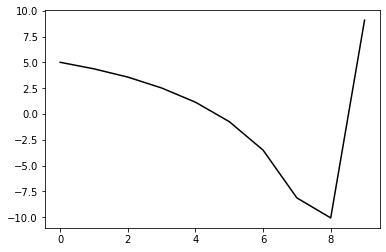

343200 0.3103479500811442
1.9194308043579809 0.4611398619973975 -0.9424314154504585 0.7565933846039505
[  5.04422849   4.32271781   3.53226644   2.48112057   1.09878754
  -0.78681287  -3.56053114  -8.3384847  -10.10938184   9.09795734]


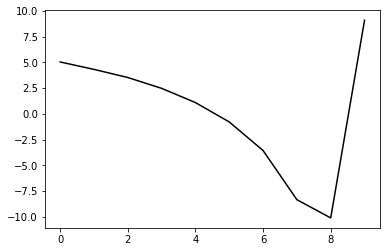

344300 0.2816731920484176
1.8719224436808959 0.4476521483525637 -0.9404628110197789 0.7530417553886017
[  4.96583269   4.36415713   3.56311857   2.50811084   1.12037185
  -0.76989769  -3.54792775  -8.18646979 -10.18265468   9.03625219]


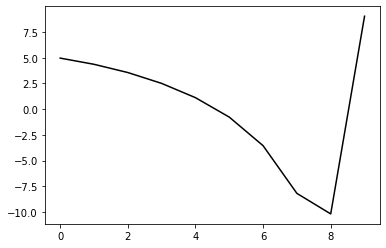

345400 0.41362511963198
1.8601705805599522 0.42883522541728863 -0.9370644616179196 0.7554490244990253
[  4.92328207   4.39141038   3.571472     2.51115763   1.11701568
  -0.78170021  -3.57882067  -8.33163936 -10.2101071    9.07635817]


346500 0.312747492294753
1.8684745121461095 0.4680642035301733 -0.9597327373965299 0.7435664100113467
[  5.00910587   4.36019657   3.5550721    2.50936523   1.12451271
  -0.76883814  -3.56204728  -8.3108763  -10.14767242   9.16352686]


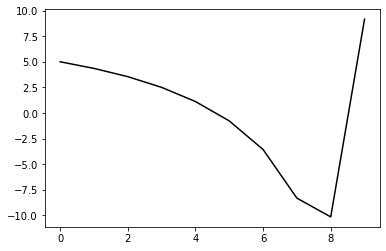

347600 0.32524510876109886
1.902206534410225 0.4389859496236991 -0.94297536960158 0.7634075536411312
[  5.06499535   4.32317993   3.51893212   2.48027353   1.10531442
  -0.77694337  -3.55389498  -8.18649969 -10.07209527   9.09617091]


348700 0.4576931012753491
1.837164007654198 0.4801006956834158 -0.9610081636199912 0.7494431775197882
[  5.00073009   4.359701     3.53395974   2.49440615   1.11453491
  -0.77796153  -3.57186079  -8.36231078 -10.20641887   9.07248023]


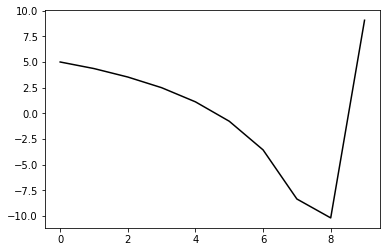

349800 0.38526755826756603
1.8425399650998515 0.4521900456899797 -0.942637151094109 0.7675961057729327
[  4.97624447   4.38211705   3.56075465   2.52148162   1.14608583
  -0.74137848  -3.52895487  -8.21505401 -10.12396685   9.15925018]


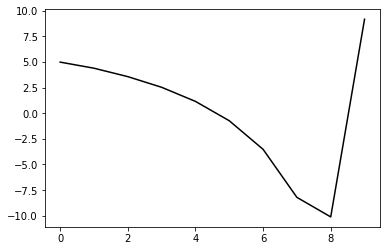

350900 0.32769594649369754
1.8794536221160296 0.45483969727704027 -0.9433166883761651 0.7740091555844427
[ 4.90528545  4.48161148  3.66203107  2.63004979  1.2645258  -0.61179451
 -3.37580486 -8.14940065 -9.92579221  9.09499567]


352000 0.3147908916945804
1.852297911681702 0.4183608509761427 -0.9313890077125169 0.7788013499684079
[  4.96507377   4.3853758    3.55571599   2.50804396   1.13237882
  -0.75461233  -3.54329723  -8.24160545 -10.1210838    9.07638569]


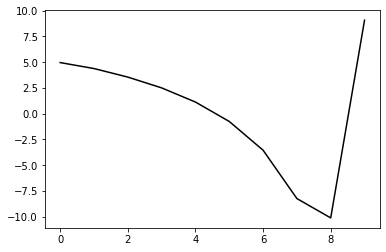

353100 0.373040325441753
1.8459841366409395 0.4332922018408844 -0.9368164407194992 0.7802991167417368
[ 4.91619869  4.4606052   3.63856483  2.60395115  1.24076827 -0.63192163
 -3.38404447 -8.09446939 -9.91351831  9.06215528]


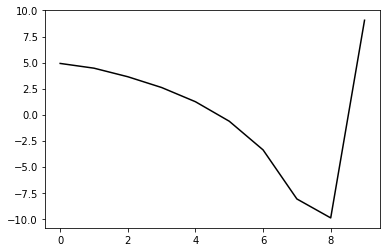

354200 0.31059363315601357
1.8496004116362343 0.4434589472828968 -0.9526254733507953 0.7671470998644703
[  5.08053306   4.32026276   3.49168013   2.45303323   1.08647668
  -0.79273543  -3.56833604  -8.36776651 -10.04894125   9.0989139 ]


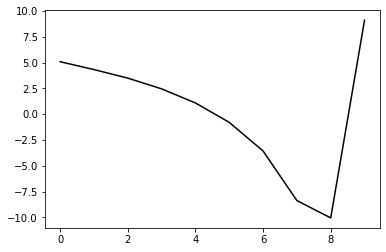

355300 0.2892812864274472
1.809215518831288 0.4447951123204012 -0.957984792617357 0.761613971277568
[  5.07377204   4.31158601   3.47871247   2.43493206   1.06552514
  -0.81535554  -3.59365096  -8.22941535 -10.14872538   9.01597737]


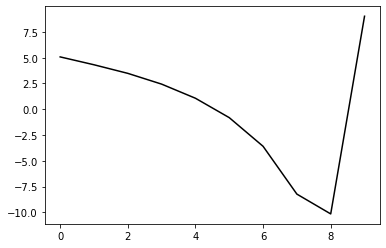

356400 0.42633068643071453
1.846423149920154 0.4800772990403199 -0.9880304938460956 0.7415834054135462
[  5.22711358   4.21691968   3.39582692   2.36493677   1.00679695
  -0.86527822  -3.6430196   -8.47757885 -10.08428452   9.12055151]


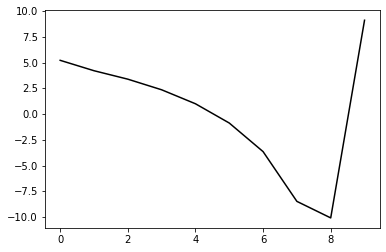

357500 0.30185635389462023
1.8638056423666947 0.4638710090535901 -0.9708844808315078 0.7667506983863484
[ 5.08093882  4.39214505  3.56015576  2.52602139  1.16634557 -0.70744466
 -3.49634899 -8.53690558 -9.97097156  9.06923187]


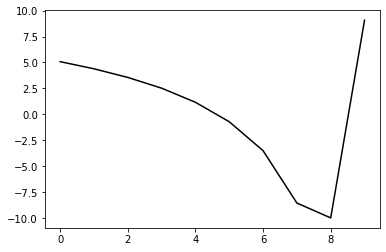

358600 0.3482490772821144
1.8272530345222773 0.43987143463933165 -0.9490572612796273 0.7850952784568329
[ 4.82733438  4.57737462  3.73746014  2.69193935  1.32297794 -0.55971506
 -3.36463314 -8.62001068 -9.93964286  9.08943549]


359700 0.48152990628954645
1.906729745446991 0.476619584728709 -0.9906825814002966 0.7561176008350903
[ 5.23116305  4.27955953  3.46657476  2.43752714  1.08438895 -0.78381804
 -3.58582464 -8.74311905 -9.95701322  9.02345933]


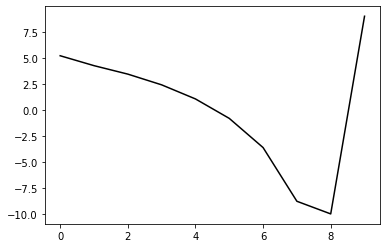

360800 0.3844919662637213
1.8365044894901716 0.43420010843086204 -0.9603836282893181 0.7771635356705623
[  5.0094901    4.41754906   3.59169997   2.54509009   1.17689711
  -0.70432752  -3.5242937   -8.61635434 -10.08233857   9.1037491 ]


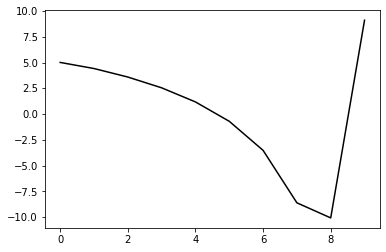

361900 0.3448839071756357
1.8481857406644417 0.46118296562226835 -0.9881236919577648 0.7533977574523679
[  5.12074409   4.3267487    3.50049954   2.46148779   1.09907938
  -0.77639017  -3.59246201  -8.58935284 -10.0998679    9.08065872]


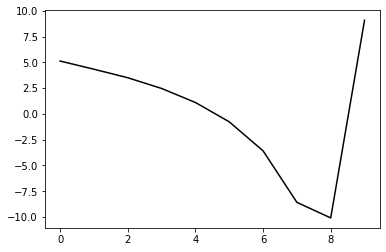

363000 0.32070615223089
1.8732884619218961 0.43105620207605116 -0.9712095960451919 0.7739520461677281
[ 5.04707957  4.43258192  3.60987324  2.56548647  1.19937994 -0.68019762
 -3.51081716 -8.7546881  -9.96987122  9.13026293]


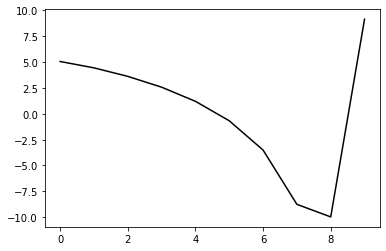

364100 0.3841977308521296
1.841627286816852 0.4347594315739932 -0.9799469907603576 0.7629546578961443
[  4.98171585   4.45968748   3.62233129   2.57181828   1.19911354
  -0.68655698  -3.5267361   -8.76372161 -10.0398675    9.07436742]


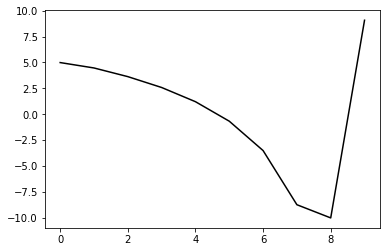

365200 0.3226789935131478
1.934818426266397 0.43339386666834645 -0.9802283316843051 0.7748895791384289
[ 5.08083921  4.43551557  3.62330945  2.58932389  1.23210247 -0.63924733
 -3.46803668 -8.60642451 -9.85168985  9.10196762]


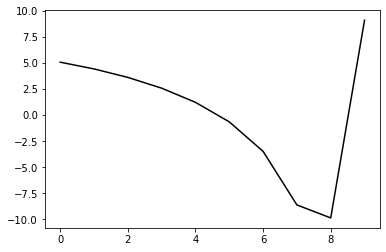

366300 0.28894705373439983
1.8667023021855331 0.43137884862228615 -0.9902708375335547 0.7599100524312881
[  5.16147371   4.32633909   3.4993869    2.45611591   1.09008965
  -0.79028446  -3.63378018  -8.69287218 -10.12769272   9.00999168]


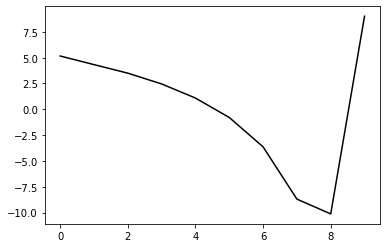

367400 0.3891818985638319
1.848758243187837 0.3948978884110503 -0.9868716085053502 0.7538413160554877
[  5.25712459   4.16010747   3.32058012   2.2681332    0.8997134
  -0.9747981   -3.78454451  -7.95296794 -10.40826388   9.05686387]


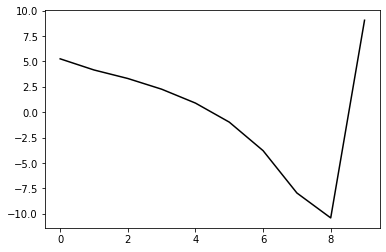

368500 0.3183206497616537
1.8704877059705303 0.4228395266104096 -0.9949425179324066 0.7576959392265722
[  5.15189878   4.34244737   3.50179797   2.45886972   1.09387841
  -0.78622074  -3.62152331  -8.39336735 -10.13498828   9.07137196]


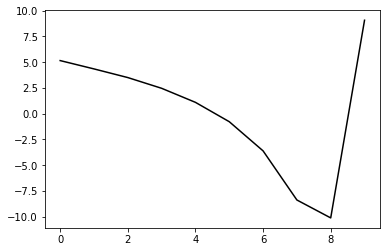

369600 0.32614460939518486
1.8816467605973162 0.3984042714010658 -0.9778389419524413 0.7800264065443511
[  5.06974054   4.44519251   3.59537881   2.55064327   1.18570559
  -0.69509009  -3.53319809  -8.49906191 -10.02603551   9.17722302]


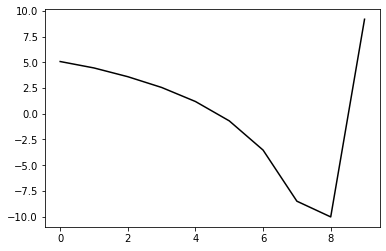

370700 0.5098354573975763
1.8665482672174918 0.386682015606536 -0.9538066543052186 0.8108994265103434
[  5.06788338   4.48440996   3.63604749   2.5909425    1.22536743
  -0.65945689  -3.51120126  -8.9495801  -10.00843229   9.05690638]


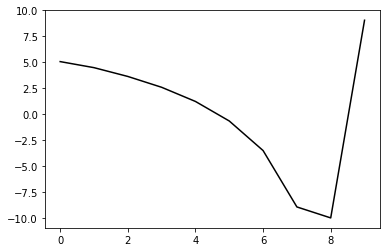

371800 0.3989682143035121
1.9276852742538697 0.4166345936722989 -0.991671440510335 0.7817304993694519
[ 5.20159044  4.39020516  3.54227702  2.50233434  1.14406168 -0.7331134
 -3.5813744  -8.89643432 -9.95883517  9.08945472]


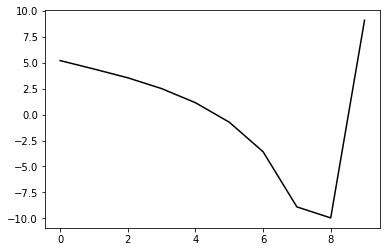

372900 0.3154955495692618
1.9207908283061328 0.41289817044662874 -0.9885883067380515 0.7888041360654854
[  5.24760587   4.36354525   3.51248549   2.46916349   1.1094061
  -0.76989133  -3.62736074  -8.95123973 -10.0577563    9.06145029]


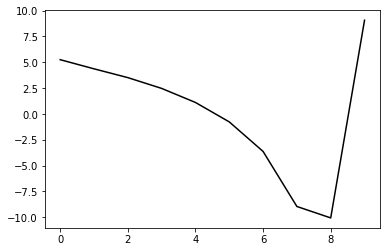

374000 0.3214072810058544
1.8746377338541134 0.40541840083995956 -0.9836156953578291 0.7909016510731098
[  5.08886079   4.46153611   3.59482473   2.54082105   1.17223051
  -0.71475119  -3.5810833   -8.77881217 -10.12913399   9.14170937]


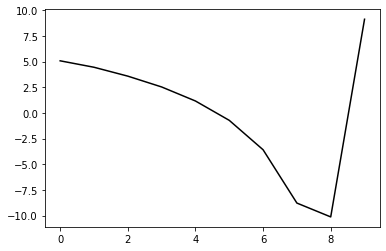

375100 0.4105345121262619
1.8396520901137796 0.40596654277686567 -1.0010477582186652 0.7694200367441101
[  5.20029735   4.31711453   3.44575014   2.38111056   1.00559395
  -0.88684157  -3.7583848   -8.52135882 -10.29049522   9.04174586]


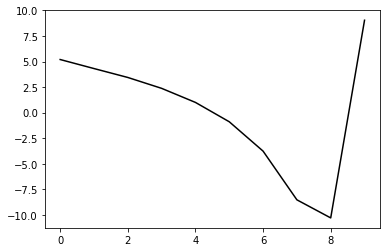

376200 0.2998971062854718
1.7697256469757583 0.3765785878950269 -0.9863633129363724 0.7752989468737943
[  5.13271401   4.28972362   3.41851083   2.33601078   0.94544627
  -0.95974336  -3.83864141  -8.35493948 -10.50879186   9.06035594]


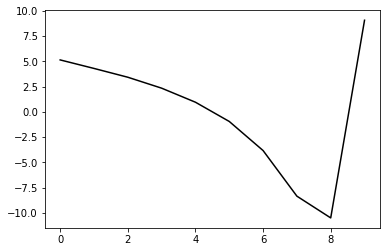

377300 0.3046971582172762
1.8726396479759617 0.36904134203629424 -0.9740842484816328 0.8019432315256132
[ 5.04391554  4.51479639  3.68689104  2.62837881  1.25614366 -0.6325006
 -3.48920311 -8.68854086 -9.96816284  9.12992109]


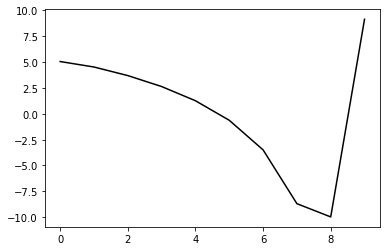

378400 0.36594730246710083
1.9222743928682402 0.4002132908301624 -1.0082876760845076 0.7749742803664446
[ 5.28779156  4.31477776  3.4943738   2.45290546  1.09321779 -0.78383223
 -3.62964101 -8.70440636 -9.97906252  9.15019963]


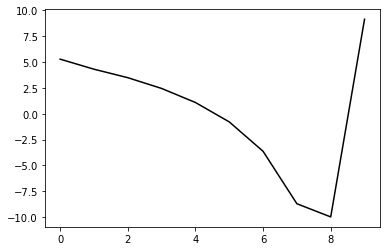

379500 0.2850497934037901
1.9278107646376463 0.3683763904115646 -0.9935506081123116 0.7875727084017081
[ 5.1463997   4.44899251  3.60686214  2.55925453  1.19566847 -0.68330185
 -3.53025358 -8.57672791 -9.92408729  9.06699677]


380600 0.3303051256876145
1.9706448287276532 0.3679271050579533 -0.9982584099374486 0.7894592857651509
[ 5.19408139  4.45228382  3.60536556  2.56351967  1.20623869 -0.66729322
 -3.51251029 -8.60774638 -9.84789618  9.1049533 ]


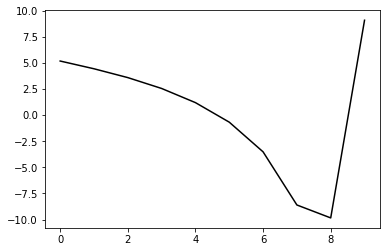

381700 0.5059083431975567
1.9431777663895908 0.327980153692525 -0.9724524597808892 0.8127239812070323
[ 5.11623437  4.50370693  3.63442203  2.57824407  1.21087601 -0.67235556
 -3.53164351 -8.83535535 -9.97097195  9.04804945]


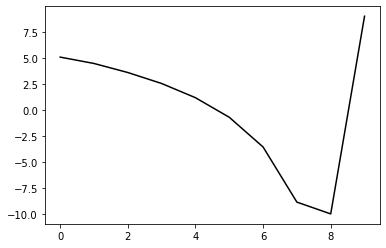

382800 0.3781207519133743
1.8406896646158486 0.34422725297277923 -0.980094151349325 0.8021021830089465
[  5.09217781   4.46916183   3.58744495   2.5182922    1.13860094
  -0.75764124  -3.63602521  -8.88315351 -10.20426846   9.12665326]


383900 0.32500544450578495
1.865277750400381 0.3349778755200943 -0.9874898930178816 0.7957846281453089
[  5.17099679   4.40180624   3.52789321   2.45770358   1.07981871
  -0.81329879  -3.68851693  -8.73777287 -10.13835255   9.07528236]


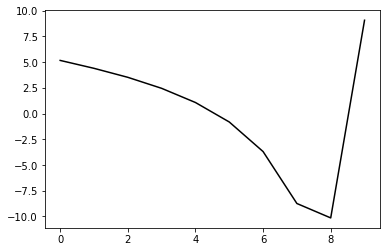

385000 0.32810003261131887
1.8713906864670247 0.36775897918882394 -1.0068622339878999 0.7889352444493339
[  5.2447117    4.37490538   3.5084226    2.44313735   1.06766862
  -0.82472621  -3.70379765  -8.88036856 -10.10065272   9.08365776]


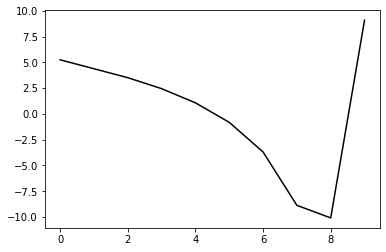

386100 0.3601983165368909
1.8770660693044634 0.3696335715586978 -1.0040957278922664 0.7977536640168992
[ 5.1678138   4.46327729  3.59898099  2.53509982  1.1601507  -0.73252975
 -3.61551127 -8.98117759 -9.97258968  8.9930842 ]


387200 0.33884567884105365
1.8459725931827504 0.3868501213601084 -1.021998072548471 0.7784150434077134
[  5.28006202   4.28606252   3.42489027   2.35631027   0.9768047
  -0.91958389  -3.80753297  -8.79443944 -10.21154897   9.08079649]


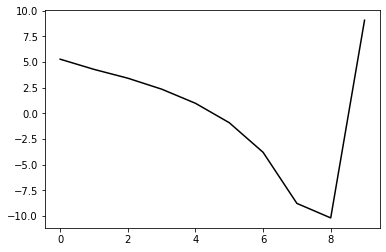

388300 0.28410608114812214
1.8231638600695665 0.38454984631791894 -0.9999271948487845 0.8058594139020684
[ 5.03415375  4.52428471  3.67200807  2.60829014  1.22976811 -0.66713715
 -3.55395467 -8.79138161 -9.99822896  9.06725225]


389400 0.40965712714264385
1.8203580050705208 0.3586556494668471 -0.9976766537955472 0.8030106920908184
[  5.08012071   4.45591137   3.60144377   2.52811599   1.14357389
  -0.75631241  -3.64066219  -8.55442141 -10.14406053   9.05483229]


390500 0.3603411712861498
1.9088471218174174 0.4216300403041948 -1.0414493375870453 0.7770833711991152
[ 5.25642135  4.37647297  3.54139732  2.49745133  1.13495199 -0.74609829
 -3.60127027 -8.488837   -9.95051163  9.0765899 ]


391600 0.41198790090909715
1.8105546119321947 0.407975054800889 -1.0326609898585213 0.778512613921573
[  5.20795239   4.37192509   3.51368649   2.452371     1.07298396
  -0.82423415  -3.69081958  -8.46016341 -10.25483366   8.98210158]


392700 0.46636338629134444
1.8393225642318096 0.38696170520443984 -1.0104917245065386 0.8061469986196869
[  5.10977963   4.48234254   3.63883793   2.58126297   1.20523222
  -0.68968605  -3.55559524  -8.63337634 -10.07598845   9.06266988]


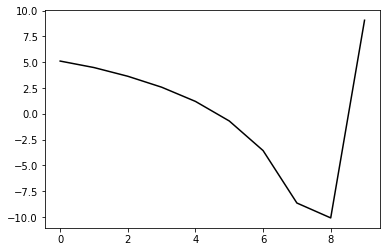

393800 0.39844608014185173
1.7604774900586908 0.33700182279573615 -0.9958056187227948 0.804411081380762
[  5.09861687   4.37586338   3.51357474   2.43111092   1.03466841
  -0.87613287  -3.7514699   -8.2500917  -10.42529803   9.07384749]


394900 0.3256310927031411
1.8210387646222381 0.34578795064161805 -1.0042902133516902 0.8056189848564286
[  5.12064344   4.4202028    3.58131595   2.51528898   1.13210016
  -0.76638252  -3.61972115  -8.33889031 -10.14029747   9.02644889]


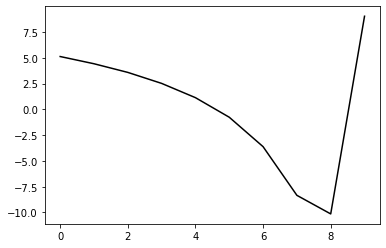

396000 0.3215678567844228
1.855365411918234 0.36698322090112095 -1.0129888791258064 0.8067828688608497
[  5.08182426   4.47155422   3.65790681   2.6032979    1.22570792
  -0.66883091  -3.51565796  -8.44532706 -10.0137615    9.11133976]


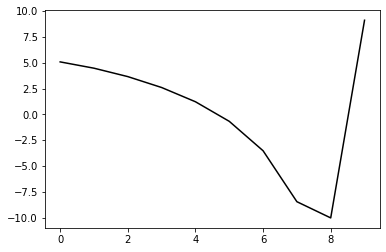

397100 0.3630487261380777
1.8552533399403401 0.3716591028717352 -1.0175507956530483 0.8059993706189587
[  5.11587709   4.43430491   3.62150082   2.57104784   1.19370284
  -0.70198959  -3.55347667  -8.53046552 -10.02785234   9.07425417]


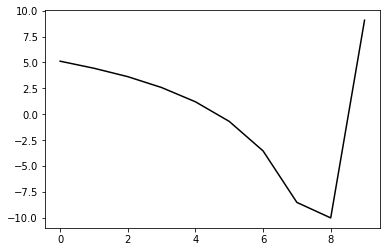

398200 0.3278674157334157
1.8130618158053164 0.3378018805234908 -1.003342623576626 0.8119678664542176
[  5.03825462   4.42169909   3.5950074    2.5329997    1.14522839
  -0.75968362  -3.62262687  -8.48941593 -10.18402314   9.10325712]


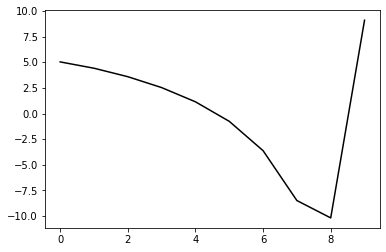

399300 0.2850014513851361
1.8024345212103705 0.3727854177608082 -1.0309823071319486 0.7893583913516297
[  5.16110505   4.30845007   3.46825641   2.41098744   1.02521799
  -0.88093474  -3.74774105  -8.42782452 -10.27050028   8.99912313]


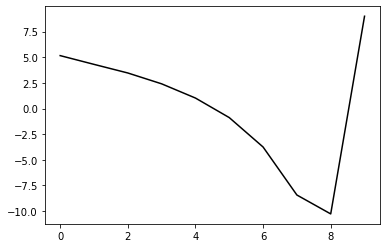

400400 0.39281698062088843
1.8567472714986715 0.35040704933927397 -1.0179778276804208 0.8098938838588335
[  5.2320431    4.30123658   3.46987503   2.42191345   1.0468812
  -0.84895457  -3.70187317  -8.60891903 -10.10095063   9.09543549]


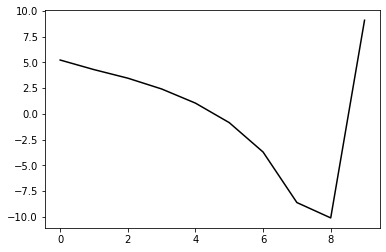

401500 0.3095842805871764
1.8384134379457517 0.3629703690138358 -1.02831940978501 0.8007758345052509
[  5.1736536    4.34220699   3.484139     2.43362054   1.05733046
  -0.84032603  -3.69382668  -8.59180886 -10.1277126    9.05594033]


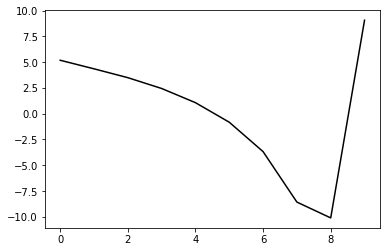

402600 0.324771230005569
1.857566336093252 0.36439037281075826 -1.0277448222536867 0.806802219546951
[  5.19876524   4.33723917   3.47419877   2.4245062    1.05176966
  -0.84337836  -3.69884827  -8.70028912 -10.10478753   9.13195947]


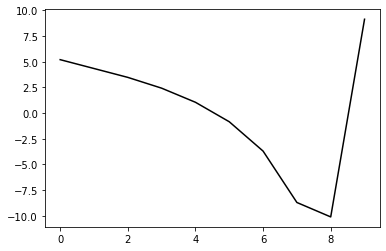

403700 0.4718035528653199
1.8706833600506845 0.37592157598686055 -1.041606770171058 0.7958041641610692
[  5.22888271   4.30008053   3.43894026   2.39013152   1.02264908
  -0.86526235  -3.70789711  -8.51049332 -10.09934418   9.02971596]


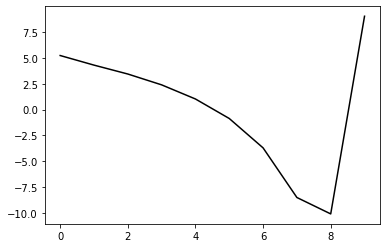

404800 0.38398166570339176
1.7903907231625038 0.3585799120756914 -1.0105516169978421 0.8284584542447367
[  5.05657706   4.42373623   3.56580945   2.50320921   1.12102954
  -0.78419262  -3.65328433  -8.71340513 -10.18354429   9.09437021]


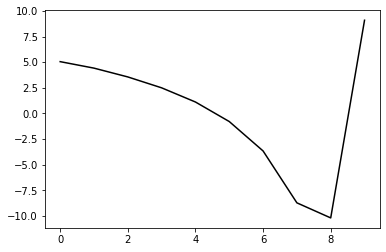

405900 0.3194648469580567
1.8312994350631304 0.3762932958223905 -1.0376530648851574 0.8068155174095873
[  5.13257706   4.36844327   3.51693853   2.45956106   1.08333345
  -0.81472249  -3.67563174  -8.64964124 -10.10836162   9.0671772 ]


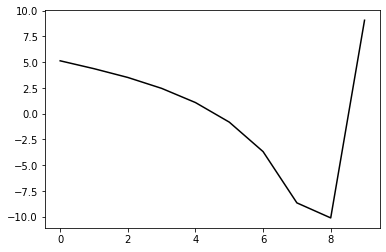

407000 0.3209172630492581
1.8814816645670602 0.3441581129064353 -1.023177041302808 0.8220538246082829
[ 5.11833721  4.37531097  3.53863645  2.48385447  1.11365844 -0.77512458
 -3.62002912 -8.48842131 -9.99886894  9.12813966]


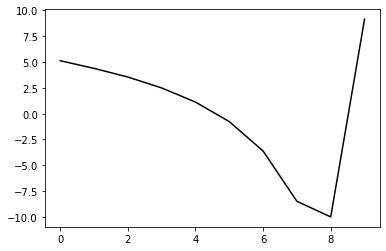

408100 0.3558167534589704
1.8692066631089475 0.36130354215551597 -1.0289522621764502 0.8209044761603442
[ 5.07712011  4.41070885  3.58712037  2.53745643  1.16851959 -0.71893323
 -3.56056138 -8.42912462 -9.93617662  9.04450541]


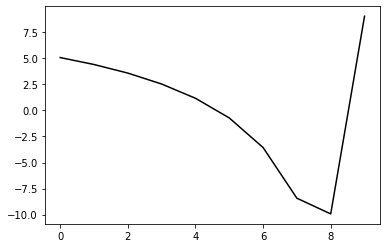

409200 0.30807285911451104
1.8837611136156216 0.399215263511336 -1.0468949860813703 0.8125773434221865
[ 5.1128533   4.39085984  3.58650791  2.55223039  1.19135541 -0.69268467
 -3.54029869 -8.65991909 -9.91401449  9.09721107]


410300 0.2811800104561027
1.826217284144472 0.3601498872931241 -1.029209272452124 0.8227627333318107
[  5.01298498   4.43772323   3.62089692   2.56757005   1.18886291
  -0.71209187  -3.58717614  -8.95432622 -10.03396789   9.0592371 ]


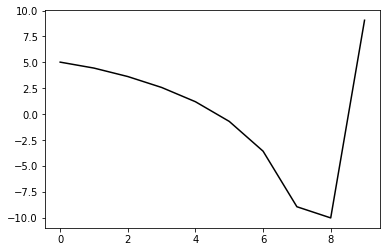

411400 0.3556923136513785
1.8559350670555594 0.34453699806725063 -1.0422117907761206 0.8084635984988888
[  5.15944008   4.29208157   3.47311739   2.42182688   1.04659698
  -0.84887905  -3.72010532  -8.87619509 -10.11221916   9.09699892]


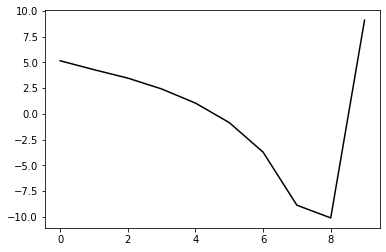

412500 0.28870391775572557
1.8259742937465904 0.32064354741873974 -1.0179155182781834 0.8319808776978481
[  5.02620252   4.40476799   3.56537986   2.50797433   1.12477824
  -0.77965356  -3.66378525  -8.77764389 -10.20955766   9.07791261]


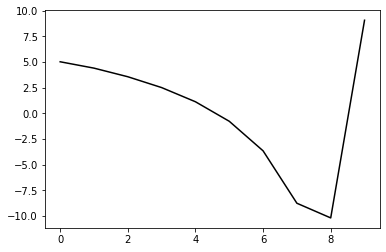

413600 0.3646671500899567
1.761016358148981 0.3122304845084235 -1.001959222139575 0.8434672039933778
[  4.80182826   4.55260191   3.71846922   2.65503938   1.26340575
  -0.6524459   -3.55279513  -8.75268905 -10.17727587   8.97650026]


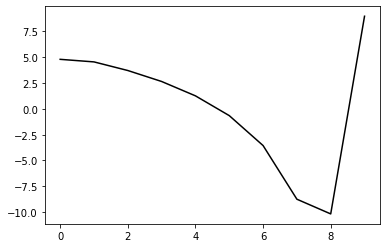

414700 0.48976608376202857
1.7899351061942965 0.31125098563367437 -1.0146716496921782 0.8351141873235304
[  4.98174148   4.41746456   3.59832159   2.53919279   1.15069082
  -0.76266673  -3.65972273  -8.68725145 -10.17713346   9.07625379]


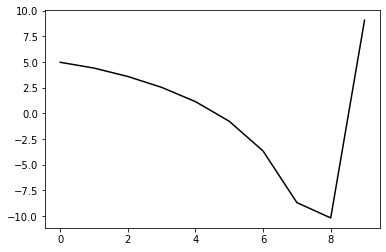

415800 0.3999304438646889
1.8067582171536807 0.34846851261217854 -1.0392168921469178 0.8215742359479873
[  5.09316253   4.3412107    3.52720427   2.47740779   1.09432637
  -0.81595357  -3.70778604  -8.74884041 -10.17608977   9.07615066]


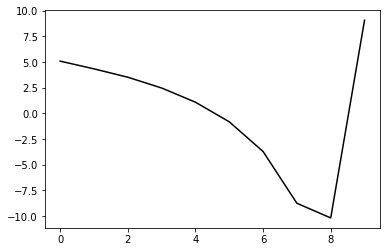

416900 0.3170923660768356
1.8537791508404813 0.3370099407630305 -1.047946525072625 0.8145333786249666
[  5.09118312   4.34486346   3.5195095    2.47417294   1.098067
  -0.80291033  -3.67501343  -8.51904961 -10.09231163   9.0296593 ]


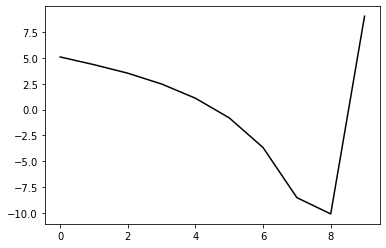

418000 0.32360231459103395
1.9131402767496573 0.3243140076185097 -1.0473454175803136 0.8232532048638341
[ 5.14602695  4.37973944  3.56221673  2.52557543  1.15794835 -0.73678034
 -3.61101889 -8.88156109 -9.9192264   9.09501788]


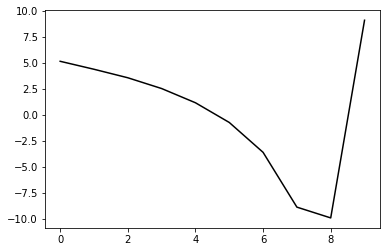

419100 0.37045301219088705
1.8900518727281468 0.31734656114784726 -1.0333295232662625 0.8425746282283336
[ 5.07969451  4.46967386  3.64532609  2.60951082  1.24203924 -0.65429403
 -3.5372379  -8.93494163 -9.89320426  9.06526144]


420200 0.33500053319619205
1.8282491124196167 0.30456672006820606 -1.0327866403688861 0.8348679014402798
[  5.01123224   4.44300778   3.59325634   2.54190824   1.16291922
  -0.74299173  -3.6345084   -8.7454691  -10.16199131   9.14085613]


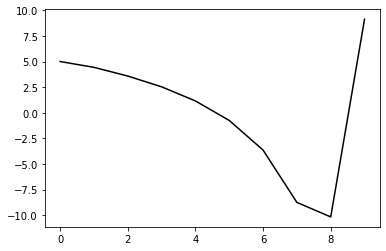

421300 0.29683206519302574
1.86274989257787 0.34472509979944926 -1.0660044054515094 0.8103915091775435
[  5.16676248   4.33195336   3.48285197   2.43590289   1.062366
  -0.84010447  -3.73244747  -8.78352663 -10.09617945   9.07767734]


422400 0.45668152097529785
1.8923779936745084 0.36405313755914515 -1.082299641690904 0.8012018081979148
[  5.32362041   4.21299642   3.38257302   2.34498463   0.98134149
  -0.91204964  -3.79621669  -8.92097069 -10.03192176   9.0802784 ]


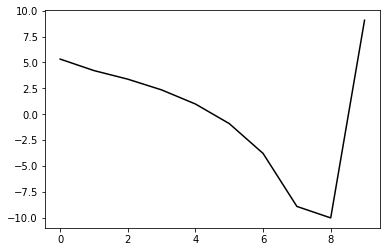

423500 0.36016554168018
1.8059156342429767 0.3381085461233094 -1.0738003389161597 0.7984517393268351
[  5.22802921   4.20706518   3.34199641   2.28252954   0.90232869
  -1.00225318  -3.88282135  -8.39292401 -10.40025088   9.0569105 ]


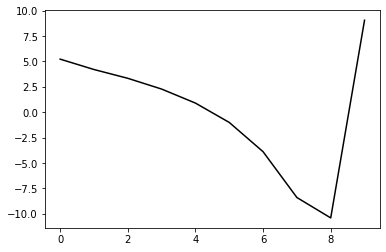

424600 0.3444942671531474
1.8530177506093044 0.3098144930081341 -1.0472240122383252 0.8329322348442164
[ 5.06365472  4.45430221  3.61112169  2.56016341  1.18655511 -0.71738441
 -3.61762611 -8.98054636 -9.99153179  9.08252412]


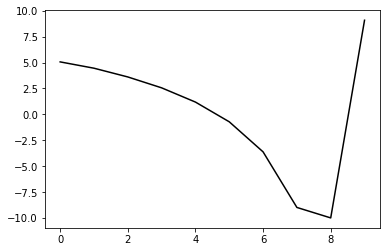

425700 0.46778225822272873
1.8209711523036638 0.3025443579395474 -1.0417799755003407 0.835900895204243
[  5.06764377   4.38991369   3.5464624    2.48763582   1.10710367
  -0.80288385  -3.71204784  -8.89978616 -10.14982644   9.05911075]


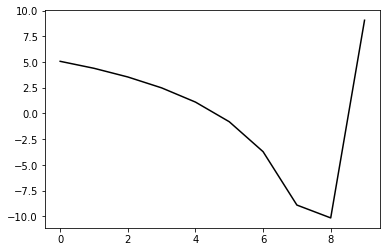

426800 0.39319164332115497
1.877917275203303 0.2948927264443592 -1.0366069869966434 0.8487766072896727
[ 4.9732632   4.50722452  3.67517592  2.62705894  1.25700283 -0.6410262
 -3.53168995 -8.72806849 -9.88520074  9.09804184]


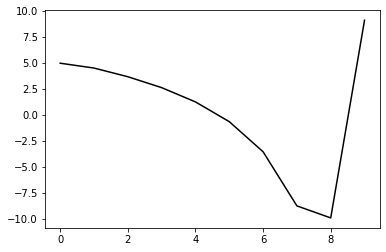

427900 0.31429076564571756
1.8375016359009657 0.31464523810232203 -1.0503048499977392 0.8382102749120351
[  5.15204194   4.36279056   3.52297641   2.47300068   1.09996257
  -0.80259017  -3.70666885  -9.0530067  -10.08514622   9.01713495]


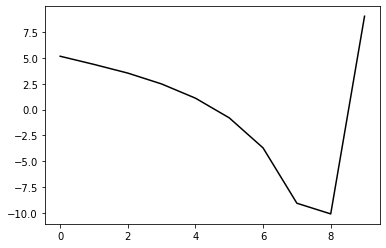

429000 0.3230452217183302
1.8141355688813927 0.32031898201720777 -1.057322370515801 0.8296940652401248
[  5.10531642   4.36172358   3.51423731   2.45956968   1.08240503
  -0.82360808  -3.73214352  -8.94442369 -10.15248272   9.08184788]


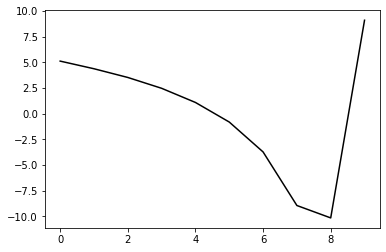

430100 0.35916593569018057
1.8840212527455171 0.32129361972979725 -1.055480147267155 0.8427865111625524
[ 5.07982281  4.4671407   3.64006883  2.59907342  1.23450854 -0.65986275
 -3.55806775 -8.94203611 -9.8401915   9.08634437]


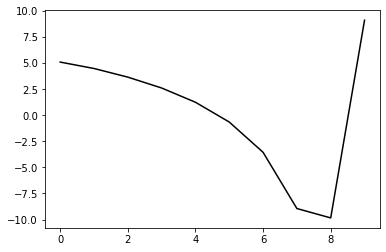

431200 0.32072955062852926
1.851232284698136 0.31071583402030967 -1.0563894800595963 0.8367181103195716
[  5.1027595    4.37032608   3.52568422   2.47199459   1.09751077
  -0.80466706  -3.71064063  -8.8318948  -10.14849756   9.15984341]


432300 0.2788098257961097
1.8475526664169508 0.32338196364285904 -1.0568724013041315 0.8458906584424926
[  5.12194253   4.3955103    3.55638807   2.50817026   1.13694451
  -0.76480669  -3.67714148  -8.98344415 -10.00934072   9.06078847]


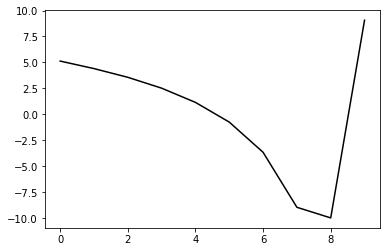

433400 0.43631209674925037
1.8382001450073135 0.3387215590097565 -1.0888903694041938 0.8121027137195771
[  5.3037764    4.18909783   3.33203089   2.27848839   0.90570967
  -0.9941294   -3.89143262  -8.52945934 -10.27569022   9.09391423]


434500 0.3334791996642557
1.8017671607869623 0.3470561267099646 -1.0836348592796128 0.8214822721295387
[  5.14993249   4.31626081   3.44761198   2.38751819   1.00732881
  -0.90208733  -3.81261817  -8.67567218 -10.25140229   9.04327097]


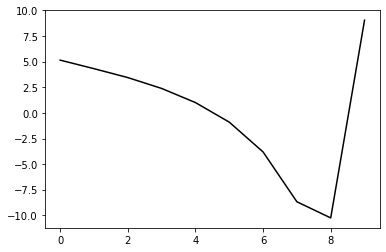

435600 0.3579143280566789
1.786497092338766 0.30412217020105975 -1.045649206485991 0.860231682892512
[  4.99491855   4.4730251    3.60915529   2.54266501   1.15772528
  -0.75689991  -3.67790378  -8.90452426 -10.10931822   9.15308297]


436700 0.46347142889944337
1.8301026523906205 0.31876570512683106 -1.0776001107276574 0.830325101523999
[  5.23704059   4.25025016   3.39187509   2.33083842   0.95328035
  -0.95190957  -3.85618933  -8.7040965  -10.13617688   9.02519169]


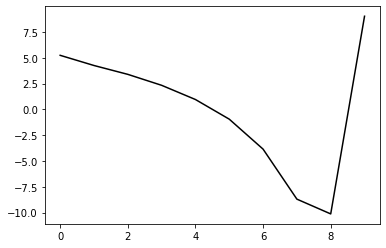

437800 0.39414602048578434
1.7577616211530287 0.29195107423598704 -1.0574180699162248 0.8425508194561987
[  5.02101253   4.36308605   3.48816685   2.40729849   1.01113469
  -0.91112972  -3.8253974   -8.49317334 -10.28493135   9.08347321]


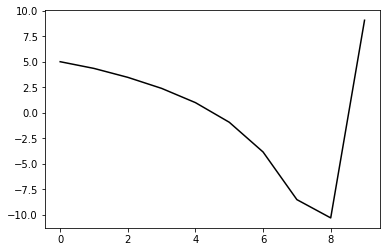

438900 0.30828177563198733
1.846781715312201 0.28263836589894376 -1.0546642034907445 0.8571712004225034
[ 5.0829779   4.41704484  3.5637433   2.49602933  1.11147939 -0.79990834
 -3.70179249 -8.76935101 -9.97882425  9.0824528 ]


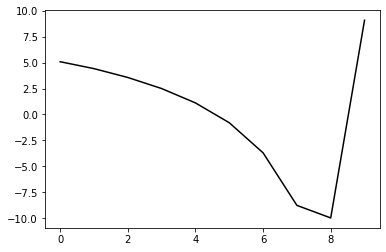

440000 0.32034526108969497
1.8036239813284891 0.25238051768039943 -1.0410995107224608 0.8639605880773684
[  4.95285174   4.47551528   3.61035937   2.53223937   1.13818484
  -0.78133681  -3.68730391  -8.75032666 -10.0407742    9.13614236]


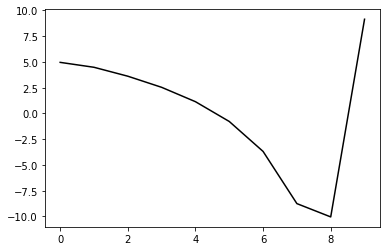

441100 0.3532188605809616
1.8317017418367678 0.25196647210451373 -1.0517699807684844 0.856927419681182
[  5.03846158   4.40202422   3.53692291   2.45926317   1.06663261
  -0.84987028  -3.74663084  -8.68299915 -10.0613094    9.0822874 ]


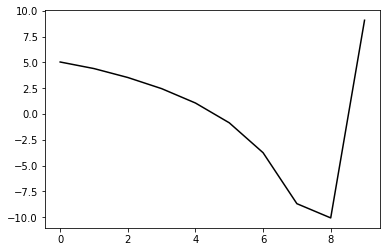

442200 0.3437006392754785
1.848920203823558 0.310253166506505 -1.0879126269876602 0.8302089981890269
[  5.21478737   4.24700456   3.38961196   2.32453314   0.94048732
  -0.96813568  -3.8448815   -8.60073797 -10.04423473   9.14829952]


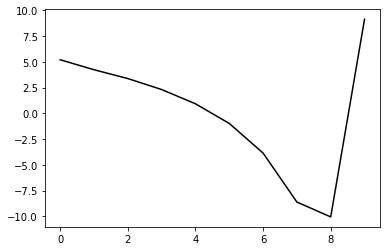

443300 0.2836958202928005
1.8094357694651093 0.3064352087249162 -1.0835380580496934 0.8310496154424049
[  5.04363098   4.33890943   3.47545305   2.40111193   1.00721283
  -0.90939406  -3.78495798  -8.52095699 -10.13108002   9.05835135]


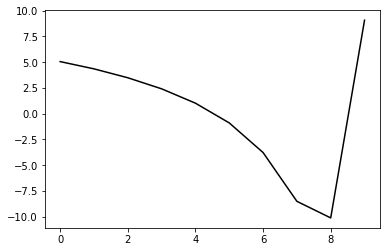

444400 0.3832217717008157
1.7596813412611627 0.3051697630546849 -1.0762121897099246 0.8401690654330756
[  5.03746462   4.35061814   3.49272525   2.41321404   1.01184003
  -0.91401244  -3.80570812  -8.70416723 -10.1655902    9.08653748]


445500 0.2790132564679203
1.820055704404043 0.29959421206246234 -1.0748735196284727 0.8484345915377759
[ 4.97004013  4.43749507  3.60650323  2.53980762  1.15042465 -0.76032334
 -3.62213093 -8.38268409 -9.90684907  9.04105905]


446600 0.34810637350331575
1.8181627660439676 0.28952880197255415 -1.0650197939639923 0.8599899614986528
[ 4.86389356  4.5397448   3.7037801   2.63644149  1.24176554 -0.6775237
 -3.56159546 -8.67130819 -9.92129738  9.13939685]


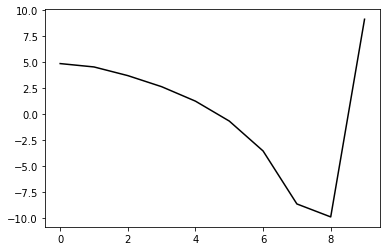

447700 0.4788848017684443
1.7863571474055795 0.3716739417885134 -1.1275984234110021 0.80647229297205
[  5.18956549   4.25100468   3.427036     2.36920049   0.9784936
  -0.93866372  -3.82195764  -8.85602291 -10.14736744   9.04676023]


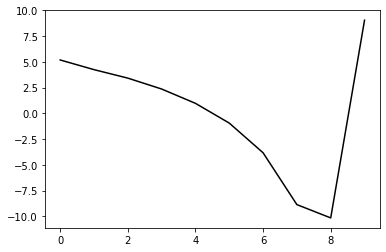

448800 0.37761006626497007
1.6968327737597677 0.28991818206013165 -1.0586528127022468 0.8613402408824565
[  4.86982919   4.47108802   3.64239704   2.56667791   1.15893019
  -0.77428482  -3.67799844  -8.77365591 -10.22969484   9.09613734]


449900 0.32662097521555256
1.732522911691296 0.2972459374633826 -1.0690963238417852 0.8578612963935007
[  5.0033995    4.38933024   3.58566592   2.52126075   1.12093972
  -0.80608723  -3.70579684  -8.78048938 -10.1033855    9.06464683]


451000 0.3162449886278243
1.7098742499427093 0.2712829262357089 -1.0583626297099085 0.8647311916458229
[  4.96589312   4.39190301   3.58270732   2.51375352   1.10683431
  -0.82762513  -3.74059878  -8.85695739 -10.17526806   9.10473843]


452100 0.34950301192826533
1.7219365171895158 0.2558172635760637 -1.0613959932836916 0.8608479487423113
[  4.99625493   4.35151141   3.53737982   2.47023661   1.06464297
  -0.8678839   -3.774658    -8.75452993 -10.17040783   9.00443106]


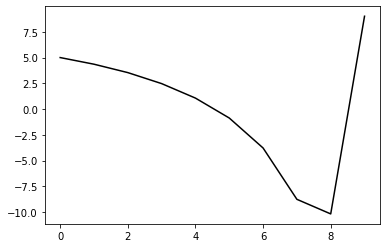

453200 0.3207570631320357
1.746167074872538 0.25917591174761934 -1.069786405871037 0.8567478978170762
[  5.11461914   4.2724417    3.45420072   2.39424352   0.99456543
  -0.93429018  -3.83770304  -8.76586442 -10.14994866   9.04253946]


454300 0.284811765728367
1.7109498558191512 0.28628974209605546 -1.0911298196451475 0.8371407728406566
[  5.09208505   4.27520076   3.43523451   2.37520101   0.97459479
  -0.95623752  -3.85587193  -8.66363275 -10.21454093   9.07328393]


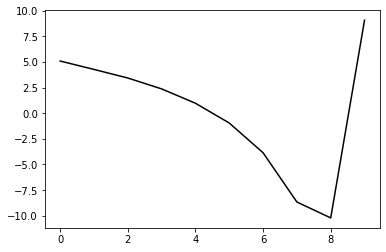

455400 0.3689703684332347
1.7202548912742162 0.31198207630614916 -1.1021182936975582 0.833841015723352
[  5.12282536   4.25999265   3.43209362   2.37774792   0.98186982
  -0.9463815   -3.84286549  -8.72316549 -10.15102541   9.06540444]


456500 0.3169025648213244
1.7328466963675062 0.306825878660827 -1.103948044260079 0.8343172798371691
[  5.11099449   4.27740076   3.45492885   2.40243753   1.00893856
  -0.91730211  -3.81439595  -8.84638365 -10.08812044   9.01015619]


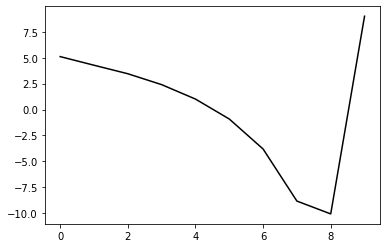

457600 0.36325616771525754
1.7024301889025968 0.24007966209935216 -1.0598967553772958 0.871495518064126
[  4.88175118   4.48170693   3.64820126   2.58634462   1.18556826
  -0.74798515  -3.65978785  -9.130994   -10.0215711    9.08758106]


458700 0.46485977628233127
1.7148201477488278 0.2377543969272043 -1.0718266625103923 0.8608476601724472
[  5.03976885   4.33165474   3.48913155   2.42581896   1.02541789
  -0.90762738  -3.8236215   -9.15300152 -10.09867772   9.12751044]


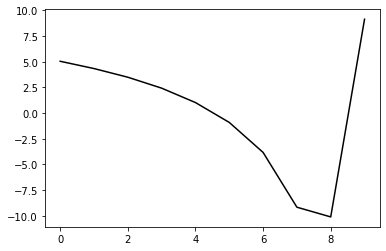

459800 0.39612528364068683
1.7212952054876491 0.25448101973086146 -1.086142620442631 0.8497943824141864
[  5.04882981   4.32564261   3.47654017   2.41622401   1.01965853
  -0.9098125   -3.8238504   -9.05632565 -10.10454092   9.06624655]


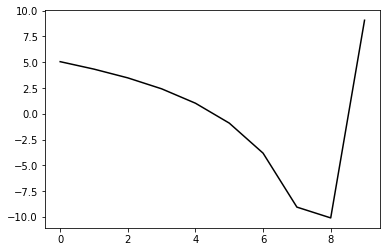

460900 0.308816211355894
1.82332601910889 0.2621282176096113 -1.0975613275887306 0.8542301132481751
[ 5.14036886  4.35679238  3.51776871  2.47220914  1.09145236 -0.82363411
 -3.72839922 -9.11784458 -9.82746855  9.10153173]


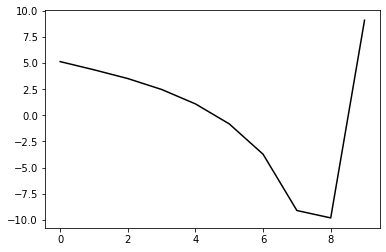

462000 0.326811221132116
1.775225786145515 0.2604580857935534 -1.0990993123480797 0.850102297605076
[  5.14803041   4.31929937   3.46961042   2.41665651   1.03083646
  -0.88920282  -3.80303369  -9.14621304 -10.01059186   9.15648944]


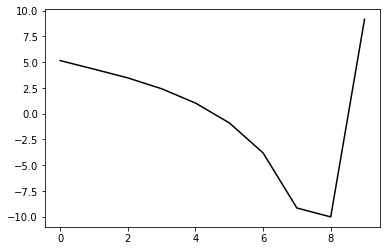

463100 0.3762391014451672
1.776123819075307 0.2636758447009227 -1.076530414198406 0.8804949381716081
[ 4.9196797   4.54654871  3.70639376  2.65852316  1.27719393 -0.6400152
 -3.55459302 -9.05959242 -9.80598728  9.0886754 ]


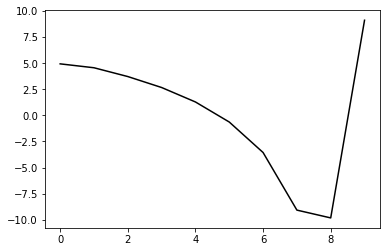

464200 0.32891091844733694
1.7498858547845315 0.25155151734669523 -1.0867081147467537 0.8659591044558349
[  5.09203898   4.35138934   3.505469     2.44640516   1.05826373
  -0.86384295  -3.7882007   -9.18667099 -10.10607263   9.08867073]


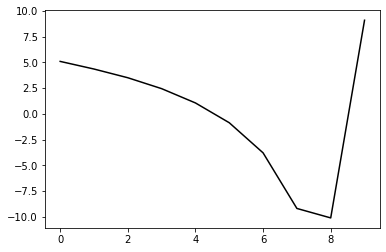

465300 0.2792134418451128
1.7618174462974983 0.2788711718644704 -1.1043905119586102 0.8550773278619579
[ 5.10745379  4.36399144  3.52415661  2.47115817  1.08799645 -0.83027867
 -3.75293476 -9.23208266 -9.95391641  9.00901395]


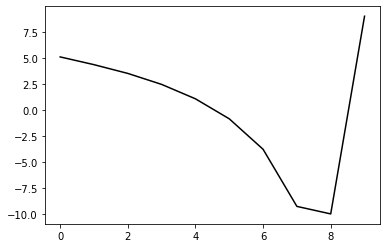

466400 0.3864779569859792
1.7251863973865162 0.2750666953469853 -1.116891291318943 0.8363524711777455
[  5.18751314   4.21736119   3.3767869    2.31874347   0.93286104
  -0.98595328  -3.91014091  -9.12857679 -10.13159765   9.08397596]


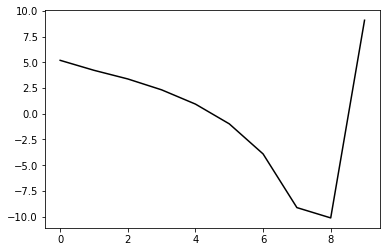

467500 0.2901646417328056
1.7124006195477601 0.25925454613836774 -1.089370887214609 0.8666315140415947
[ 4.89653068  4.48794999  3.65014023  2.59127623  1.20372782 -0.71596507
 -3.63383006 -8.81455752 -9.9577903   9.06034114]


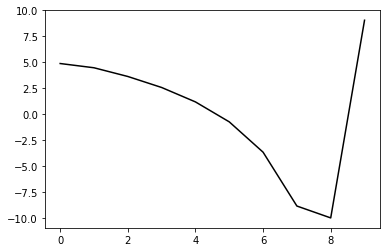

468600 0.34824028177679905
1.801432173623448 0.25525491821102464 -1.10158753960602 0.8652844076473358
[ 5.06864554  4.43701651  3.62333611  2.57876179  1.20444827 -0.70315635
 -3.61221222 -8.9018451  -9.75927382  9.14349388]


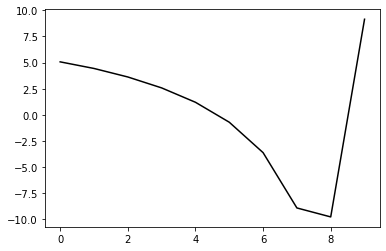

469700 0.44885531898185344
1.7222581736404874 0.25345894145190195 -1.1063802664307312 0.8527091602567535
[  5.1065216    4.32837235   3.48224004   2.42414457   1.03708422
  -0.88209964  -3.80186987  -8.96099986 -10.15153217   9.06360839]


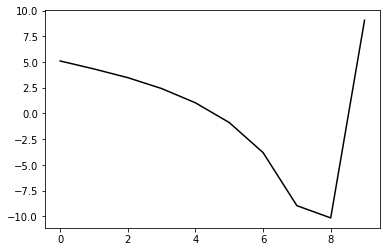

470800 0.38730036900901116
1.7187666839022115 0.26899252300103527 -1.1036511049930597 0.8616609079250394
[  4.97511454   4.45861496   3.62532701   2.57149623   1.18621399
  -0.73397205  -3.66152549  -9.0732015  -10.03422171   9.07705869]


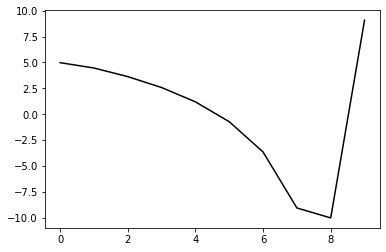

471900 0.31533715895035513
1.7382613918591883 0.2768461481324582 -1.103679824937613 0.8692157784248329
[ 5.00906381  4.46418878  3.65359751  2.60891978  1.23032856 -0.68483519
 -3.61279431 -9.11977828 -9.94940764  9.02126987]


473000 0.3245241500270456
1.7519173926328133 0.28054721422581924 -1.1039556207707082 0.8735295924142236
[ 4.98797993  4.4858448   3.67913282  2.63836866  1.26165974 -0.65185858
 -3.57884114 -8.90638446 -9.98077833  9.10483791]


474100 0.35697396244656465
1.7357090521234146 0.2955004801631183 -1.109760144593078 0.8707609183134956
[ 5.00165688  4.46620974  3.6730582   2.63637225  1.26076818 -0.65350426
 -3.58476835 -9.0531284  -9.98299859  9.08178904]


475200 0.3124295882593869
1.7415146629883178 0.2907373989944731 -1.1118788007962606 0.8689189972136677
[  5.05994447   4.37841355   3.60116962   2.56606913   1.1905434
  -0.72360967  -3.65716712  -9.02929639 -10.05506493   9.13945685]


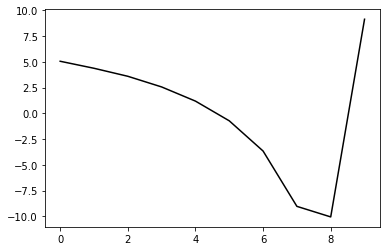

476300 0.28725442913758825
1.7255303585889439 0.30868488750343337 -1.1275717580478135 0.8553281566622345
[  5.08648083   4.3375137    3.55324181   2.52501943   1.15302441
  -0.75934876  -3.69345012  -9.03402351 -10.09111645   9.07632602]


477400 0.4037172813216241
1.6987003472491522 0.2883153447287161 -1.1133834885522096 0.8653064652921529
[  4.94535807   4.41649633   3.63115024   2.60026315   1.22338734
  -0.6953378   -3.64169709  -9.19611225 -10.14533648   9.07054039]


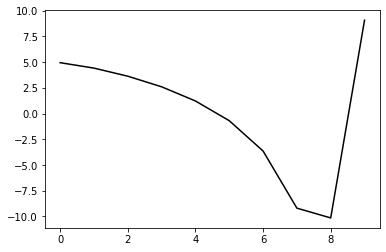

478500 0.31116288396902503
1.7163387954334934 0.29346583082956806 -1.1254916938071258 0.8562590418696531
[  5.03197572   4.3311681    3.54946529   2.5258477    1.15469228
  -0.75996189  -3.70656925  -9.15409933 -10.14640947   9.0455307 ]


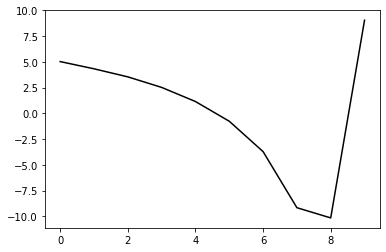

479600 0.3506832926230126
1.6840907033303862 0.31690265146845986 -1.1323872362779013 0.855921760763141
[  5.0614091    4.33084744   3.54512219   2.52902897   1.16186667
  -0.75252495  -3.705335    -9.44551215 -10.16150036   9.0852468 ]


480700 0.4442147843962716
1.6921927263961223 0.29775684682227266 -1.119049031938297 0.8700022870622645
[  5.0493428    4.34318203   3.55639455   2.54286914   1.17993521
  -0.73085187  -3.68475275  -9.35335741 -10.08104698   9.06170125]


481800 0.37914233008226034
1.7268608485738162 0.28058759826487917 -1.1112171422774575 0.8802414657725517
[ 4.92577077  4.45881122  3.66891494  2.65714275  1.30020403 -0.60474832
 -3.55027239 -8.9851199  -9.89702241  9.14813215]


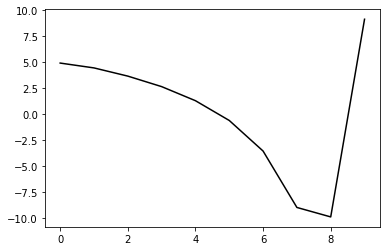

482900 0.3385455270190615
1.6838188026427716 0.2970212718219842 -1.1340213941552706 0.8517304703304021
[  5.04062497   4.28301166   3.47872867   2.46339885   1.10464911
  -0.80282912  -3.74999413  -9.04728376 -10.11851539   9.07657662]


484000 0.31759779996437054
1.7199305086116863 0.31039522029260963 -1.1312505159537984 0.8656082012298101
[ 4.95744423  4.38500159  3.60447528  2.59776336  1.24773003 -0.65339678
 -3.59402516 -8.97194321 -9.92607764  9.09418946]


485100 0.38518936430720385
1.6729456931479352 0.32364313278109197 -1.1347312060259573 0.8607901906453246
[ 4.84720654  4.45683073  3.68763915  2.67902625  1.32324645 -0.58658658
 -3.5437725  -9.0712965  -9.99892922  9.01396702]


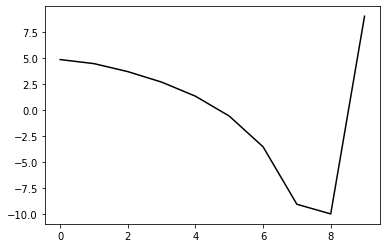

486200 0.3172871096771648
1.617443937415022 0.3214389828945457 -1.1227876600346405 0.871365851081275
[  4.77844412   4.48642092   3.73709179   2.72880856   1.36886029
  -0.5467816   -3.51221753  -9.1585369  -10.11850339   9.08383681]


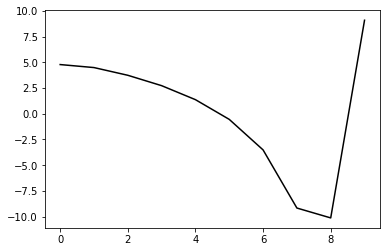

487300 0.2869542959919826
1.622516952593986 0.30407933157266476 -1.1157213884485349 0.8785302149883698
[  4.80772172   4.46782745   3.72937799   2.72432568   1.36531937
  -0.54920651  -3.51283555  -9.08927663 -10.03540346   9.07452341]


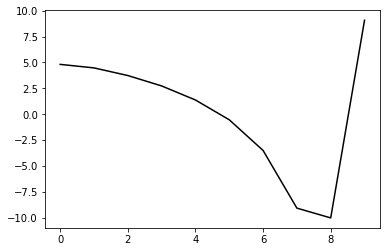

488400 0.40642983992752696
1.599033848127744 0.33729573364021664 -1.151857337148197 0.8422548180761017
[  5.01765538   4.22837156   3.5047694    2.50775171   1.15117732
  -0.76168628  -3.71502903  -8.73565783 -10.2064991    9.06435856]


489500 0.3012702369939662
1.6488510569564248 0.3201238498802763 -1.1339617083577551 0.8694370635257124
[ 4.89637796  4.40708306  3.69021625  2.70322588  1.35262018 -0.55712551
 -3.51302495 -8.99546027 -9.96344109  9.07754258]


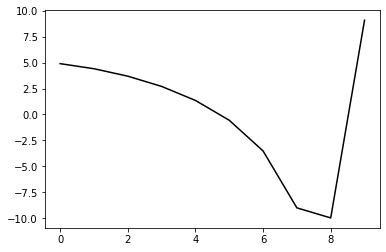

490600 0.33592930010511235
1.62666597170795 0.28643903125831305 -1.1192675806320733 0.8778025837067054
[  4.86354616   4.41813137   3.68721931   2.69614882   1.34217619
  -0.57089308  -3.52651005  -8.90016849 -10.03897304   9.0350886 ]


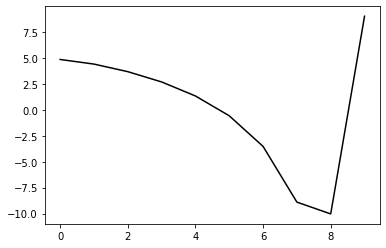

491700 0.4715213601422982
1.6340351029362201 0.2853150460850299 -1.1157320383431129 0.8890841225679915
[  5.00959842   4.34372968   3.61118982   2.6303027    1.28496614
  -0.62303739  -3.57803374  -9.05909082 -10.07262351   9.08592908]


492800 0.389074606826262
1.6151511553262783 0.29183290323713174 -1.120504041597736 0.8853699001190213
[  4.98959706   4.35118145   3.61242771   2.63149111   1.28694365
  -0.62155831  -3.57941724  -9.01908726 -10.08183665   8.97316993]


493900 0.31871065364631085
1.6571219036267966 0.3114153107908206 -1.1409862933718324 0.8716186236543727
[  5.05363178   4.31202506   3.56324234   2.58995726   1.2539555
  -0.6479169   -3.60204463  -9.089226   -10.01192429   9.07716251]


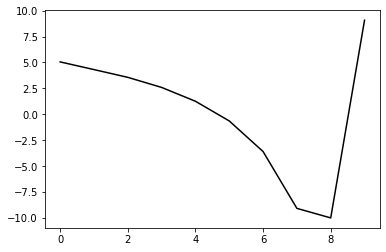

495000 0.3217805399996761
1.6949036362602226 0.28757653405782596 -1.1278559493964473 0.887846932507826
[ 5.00317456  4.38458654  3.63194716  2.65856833  1.32803774 -0.56850622
 -3.51803942 -8.94337449 -9.91698488  9.10165171]


496100 0.3698305118590741
1.6848075119765407 0.28832199671560826 -1.1206424104573616 0.8992555275142959
[ 4.94787824  4.44847321  3.69944344  2.72641238  1.39815825 -0.49704779
 -3.44731068 -8.82658233 -9.87089881  8.99737126]


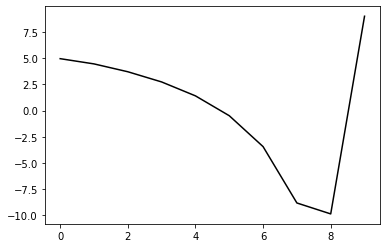

497200 0.33941233450805686
1.6727173609815083 0.2990850655195635 -1.1295211079890002 0.8920362090983008
[ 4.93977563  4.42672377  3.65744749  2.6798944   1.34951251 -0.54832016
 -3.50142225 -8.89974783 -9.97174921  9.08537374]


498300 0.2869893343791485
1.6644050787455043 0.30294896023969653 -1.1467950840027394 0.8719237043538235
[  5.07394398   4.27641395   3.50123954   2.51885373   1.18942294
  -0.70639532  -3.65905326  -8.96162519 -10.11840539   9.07049245]


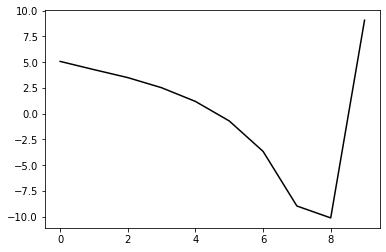

499400 0.41877419770478547
1.66206245735632 0.31291646502532955 -1.156857005877214 0.8646322136156354
[  5.16531488   4.18911691   3.41766379   2.43497709   1.10707586
  -0.78737175  -3.74444828  -9.12320851 -10.16933817   9.04743904]


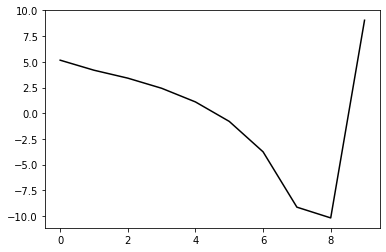

In [70]:
optimizer=tf.optimizers.Adam(learning_rate=0.001)
for j in range (5000):    
    with tf.GradientTape() as g:
        loss=Error_func(h, m2, lam, alpha, beta, Positive[j%10], Negative[j%10])
        gradients=g.gradient(loss, [h, m2, lam, alpha, beta])
    for i in range (80):
        optimizer.apply_gradients(zip(gradients, [h]))
    for i in range (20):
        optimizer.apply_gradients(zip(gradients, [h, m2, lam, alpha, beta]))
    if j%11==0: 
        print(j*100, Error_func(h, m2, lam, alpha, beta, Positive[j%10], Negative[j%10]).numpy())
        print(m2.numpy(), lam.numpy(), alpha.numpy(), beta.numpy()), print(h.numpy())
        plt.plot(h.numpy(), 'k-'), plt.show()

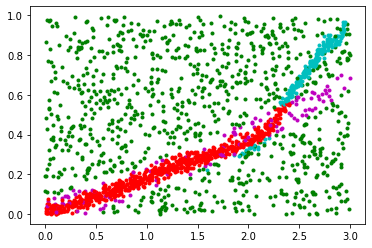

In [71]:
for i in range (set):
    [Positive0[i], Positive1[i]]=NN_func_01(h, m2, lam, alpha, beta, Positive[i])
    [Negative0[i], Negative1[i]]=NN_func_01(h, m2, lam, alpha, beta, Negative[i])
for i in range (set):
    x_data1[i]=[v[0] for v in Positive0[i]]
    y_data1[i]=[v[1] for v in Positive0[i]]
    x_data2[i]=[v[0] for v in Positive1[i]]
    y_data2[i]=[v[1] for v in Positive1[i]]
    x_data3[i]=[v[0] for v in Negative0[i]]
    y_data3[i]=[v[1] for v in Negative0[i]]
    x_data4[i]=[v[0] for v in Negative1[i]]
    y_data4[i]=[v[1] for v in Negative1[i]]
    plt.plot(x_data4[i], y_data4[i], 'g.')
    plt.plot(x_data2[i], y_data2[i], 'c.')
    plt.plot(x_data1[i], y_data1[i], 'r.')
    plt.plot(x_data3[i], y_data3[i], 'm.')
plt.show()